<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [55]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools

import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## OEC data API functions

In [0]:
# Functions adapted from https://github.com/yahiaali/oec for OEC API calls
def build_call(*args):
    call_url = 'http://atlas.media.mit.edu/'
    for val in args:
        call_url += str(val) + '/'
    return call_url


def request_data(call_url):
    r = requests.get(call_url)
    response_dict = r.json()
    json_list = response_dict['data']  # list of dicts containing data
    return json_list


def get_countries(filename=None):
    call = build_call('attr', 'country')
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_products(classification, filename=None):
    call = build_call('attr', classification)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_trade(classification, trade_flow, year, origin, destination,product, filename=None):
    call = build_call(classification, trade_flow, year, origin, destination,
                      product)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def trade_params(classification, trade_flow, year, origin, destination,product):
    parameters = {'classification': classification,
                  'trade_flow': trade_flow,
                  'year': year,
                  'origin': origin,
                  'destination': destination,
                  'product': product}
    return parameters


def get_header(json_list):
    header = set()
    for dict in json_list:
        header.update(dict.keys())
    header = list(header)
    header.sort()
    return header


def create_csv(json_list, filename):
    with open(filename, 'w') as csvfile:
        header = get_header(json_list)
        cw = csv.writer(csvfile)
        cw.writerow(header)
        for dict in json_list:
            row = dict_to_list(dict, header)
            cw.writerow(row)


def dict_to_list(dict, header):
    row = []
    for field in header:
        if field in dict:
            row.append(str(dict[field]))
        else:
            row.append(None)
    return row


### Custom functions
def get_countries_and_products():
  countries = get_countries()
  products = get_products(trade_classification)
  create_csv(countries,f'{PATH}/list_countries.csv')
  create_csv(products,f'{PATH}/list_products.csv')

def download_data(list_of_codes):
  for i in trade_codes:
    csv_name = f"{trade_classification}-{i}"
    # Set parameters to extract top exporters from the API documentation
    params = {'classification': trade_classification,
          'trade_flow': 'export',
          'year': 'all',
          'origin': 'show', #Set origin to all for comparison
          'destination': 'all',
          'product': i} #Set code for product of interest
    print(f'Processing data for {i}.....')
    oec_data = get_trade(**params)
    # Save the results in CSV file
    if path.exists(PATH):
      create_csv(oec_data,f'{csv_name}.csv')
    else:
      print('Choose destination directory')

def create_df(path:str):
  trade_data = [i for i in os.listdir(path) if i.startswith('sitc') and '.csv' in i]
  print(f'List of csv files contentated into one dataframe \n: {list(trade_data)} \n \n')
  trade_history = []
  for file in trade_data:
    file_df = pd.read_csv(os.path.join(path,file))
    trade_history.append(file_df)
  products_dataframe = pd.concat(trade_history)
  return products_dataframe

def underscore_header_names(df):
  '''
  Renaming product names after aggregation with pivot tables
  '''
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
  return df.columns


# Generic data processors
def remove_null_values(df,threshold:int=0.8):
  pct_null = df.isnull().sum() / len(df)
  missing_features = pct_null[pct_null > threshold].index
  df.drop(missing_features, axis=1, inplace=True)
  df.fillna(0,inplace=True)

def check_outliers(df):
    col = list(df)
    outliers = pd.DataFrame(columns=['columns','Outliers'])
    
    for column in col:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25) 
            q3 = df[column].quantile(0.75)
            below = q1 - (1.5*q3 - q1)
            above = q3 + (1.5*q3 - q1)
            outliers = outliers.append({'columns':column,'Outliers':df.loc[(df[column] < below) | (df[column] > above)].shape[0]},ignore_index=True)
    return outliers
    
def removing_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    
    return dataframe

## Generate dataset
- OEC API endpoint down as at 16 June 2020

- This data has been downloaded and saved in the folder indicated
No need to run this if there no new data needed
- [Resource on nicer sns and plt plots](https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib)


In [57]:
# Generate lists for countries and products
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
trade_classification = 'sitc'
# get_countries_and_products()
trade_codes = ['6519','6531','8471','6571','7849','7810','7842','7764',
               '7723','7522','2924','5419','5417','7763','7711','7188']
# download_data(trade_codes)
# Load trade data
include_list = ['year','origin_id','sitc_id','export_val']
trade_data = create_df(PATH)
trade_df = trade_data[include_list]

# Load country names
country_list = pd.read_csv(f'{PATH}/list_countries.csv',usecols=['id','name'],
                        na_values='',na_filter=True)
country_list.rename(columns=lambda x: x.replace('name','country'), inplace=True)
country_list.rename(columns=lambda x: x.replace('id','origin_id'), inplace=True)

# Update country names
trade_dframe = trade_df.merge(country_list, on=['origin_id'],how='inner')
trade_dframe['sitc_id'].astype('category')
trade_dframe.fillna(0,inplace=True)

# Load product list
products = pd.read_csv(f'{PATH}/list_products.csv',usecols=['id','name','display_id'])
products.rename(columns={'id':'sitc_id'},inplace=True)
products = products[products['display_id'].isin(trade_codes)]
products['name'] = products.name.astype('category')

# Update product names in dataframe
products['sitc_id'] = products.sitc_id.astype(int)
trade_dframe['product_name'] = trade_dframe.sitc_id\
.map(products.set_index('sitc_id')['name'].to_dict())

# Rename long product names
dict_of_name_options = {'Yarn of Textile Fibers':'yarn_fiber',
             'Synthetic Woven Fabrics':'synthetic_fiber',
             'Textile Fabrics Clothing Accessories':'accessory_fabrics',
             'Vehicles Parts and Accessories':'vehicle_parts',
             'Personal Computers':'computers',
             'Pharmaceutical Flora':'pharma_flora',
             'Non-Medicinal Pharmaceutical Products':'non_medicinals',
             'Diodes, Transistors and Photocells':'diodes_transistors_photocells',
             'Miscellaneous Engines':'engines_misc'
             }
trade_dframe['product_name']= trade_dframe['product_name'].map(
    dict_of_name_options)\
    .fillna(trade_dframe['product_name'])

# Remove unspecified country names included in the list  
unknown_origin_list = {'Areas',
                       'United States Unspecified',
                       'Northern Africa',
                       'Other Africa Not Elsewhere Specified',
                       'Europe Other Not Elsewhere Specified',
                       'European Union Not Elsewhere Specified',
                       'Neutral Zone'}
trade_dframe = trade_dframe[~trade_dframe['country'].isin(unknown_origin_list)]
trade_dframe['year'] = pd.to_datetime(trade_dframe['year'],format='%Y')
trade_dframe['year'] = trade_dframe['year'].dt.year

# Checking for countries with 'x' in origin_id
s = trade_dframe['origin_id'].astype(str)
x_country = list(s[s.str.contains('x')].unique())
unspecified = trade_dframe[trade_dframe['origin_id'].isin(x_country)]
print(f'\n Checking if countries to exclude is successful : \n {unspecified["country"].unique()}')

# from datetime import datetime
# # trade_dframe['year'].astype('datetime64[ns]')
# # df['Time stamp'] = pd.to_datetime(df['Time stamp'].str.strip(), format='%d/%m/%Y')
trade_dframe.head()

List of csv files contentated into one dataframe 
: ['sitc-6519.csv', 'sitc-6531.csv', 'sitc-7842.csv', 'sitc-8471.csv', 'sitc-7764.csv', 'sitc-6571.csv', 'sitc-7723.csv', 'sitc-7522.csv', 'sitc-7849.csv', 'sitc-5417.csv', 'sitc-7810.csv', 'sitc-2924.csv', 'sitc-7763.csv', 'sitc-7711.csv', 'sitc-5419.csv', 'sitc-7188.csv'] 
 


 Checking if countries to exclude is successful : 
 ['Mexico' 'Other Asia' 'Saint Kitts, Nevis and Anguilla'
 'Christmas Island' 'China Free Trade Zone (FTZ)' 'Belgium-Luxembourg'
 'Luxembourg' 'Oceania' 'British Antarctic Territory']


year origin_id  sitc_id  export_val        country product_name
0  1962     afciv   606519      3000.0  Cote d'Ivoire   yarn_fiber
1  1963     afciv   606519     15000.0  Cote d'Ivoire   yarn_fiber
2  1964     afciv   606519      4000.0  Cote d'Ivoire   yarn_fiber
3  1966     afciv   606519      2000.0  Cote d'Ivoire   yarn_fiber
4  1967     afciv   606519      7000.0  Cote d'Ivoire   yarn_fiber

## Plots from pivot table aggregates
* Random country South africa
* Country trade basket
* Export comparison for countries (random country examples)
* [Link to presentation: ](https://docs.google.com/presentation/d/1tR2p-pcJcCsv_8f3Ee6oT_X4imdrwVrzvOpIFr04LWg/edit?usp=sharing)

In [0]:
random.seed(20)
c = str(sample(list(trade_dframe['country'].unique()), 1)[0])
agg_south_africa = pd.pivot_table(trade_dframe[trade_dframe.country=='South Africa'], index='year', columns='product_name', values='export_val', aggfunc=np.mean)
agg_south_africa.fillna(0,inplace=True)
underscore_header_names(agg_south_africa)

# https://pbpython.com/pandas-pivot-table-explained.html
agg_product = pd.pivot_table(trade_dframe, index='year', columns='product_name', values='export_val', aggfunc=np.mean)
remove_null_values(agg_product)
underscore_header_names(agg_product)

agg_country = pd.pivot_table(trade_dframe, index='year', columns='country', values='export_val', aggfunc=np.mean)
remove_null_values(agg_country)

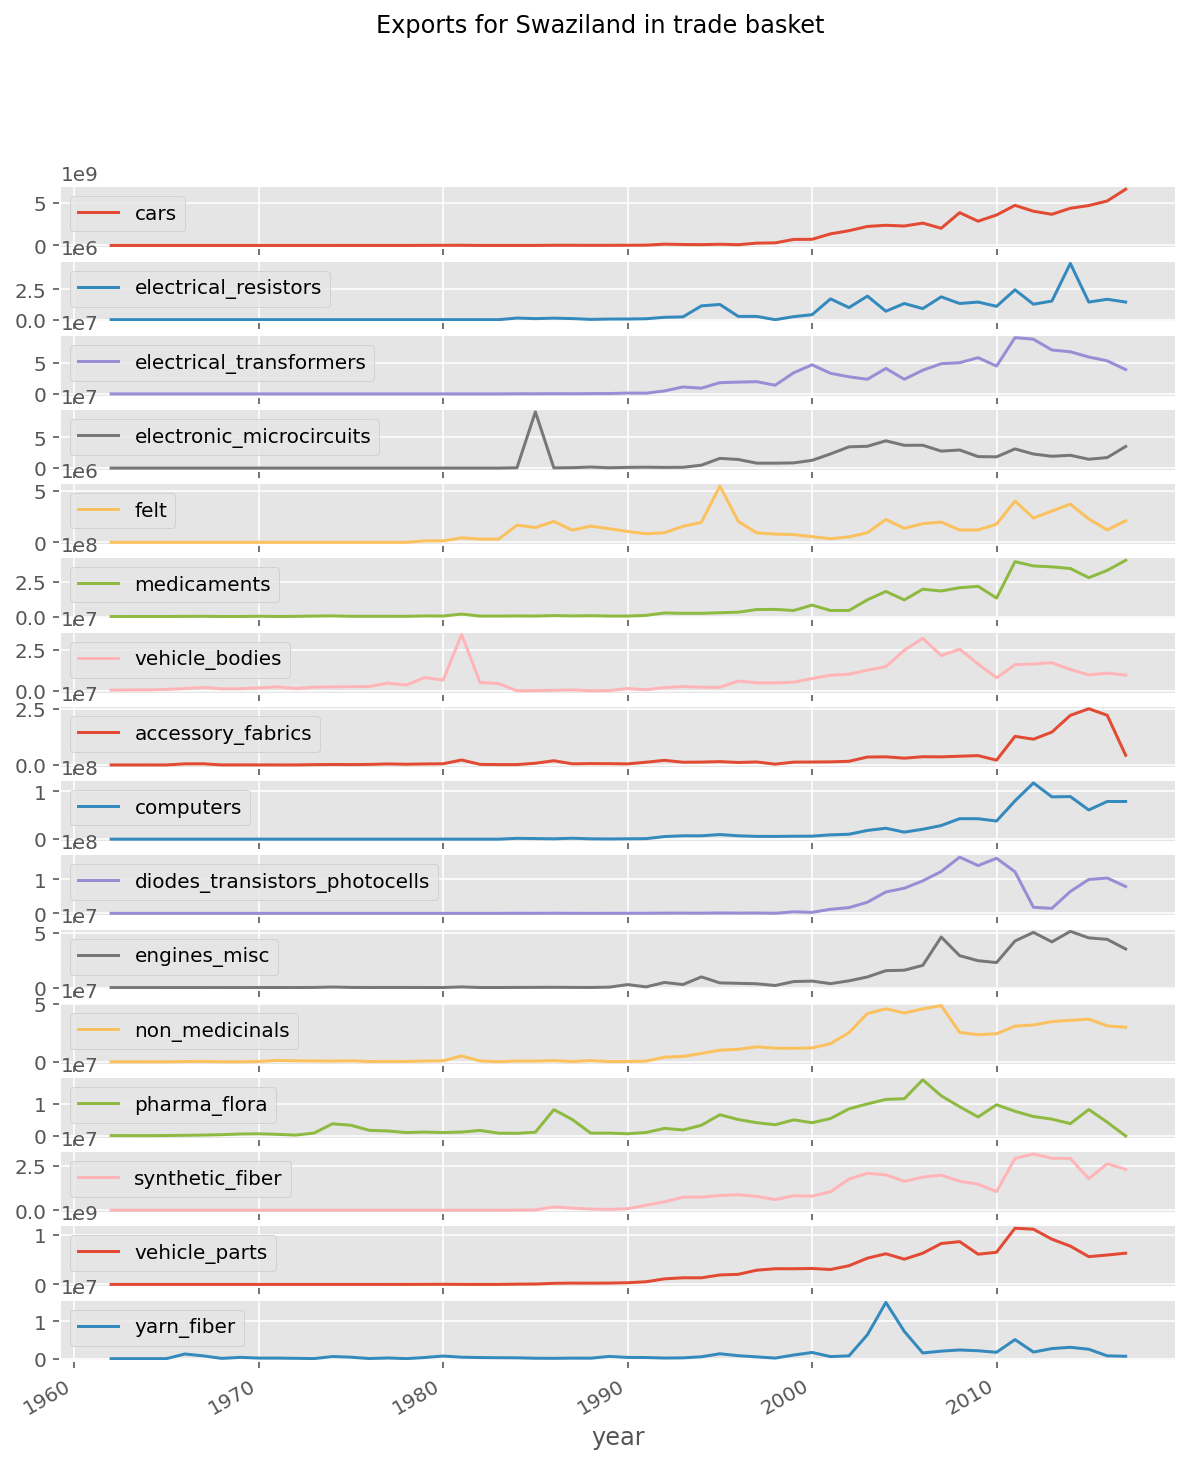

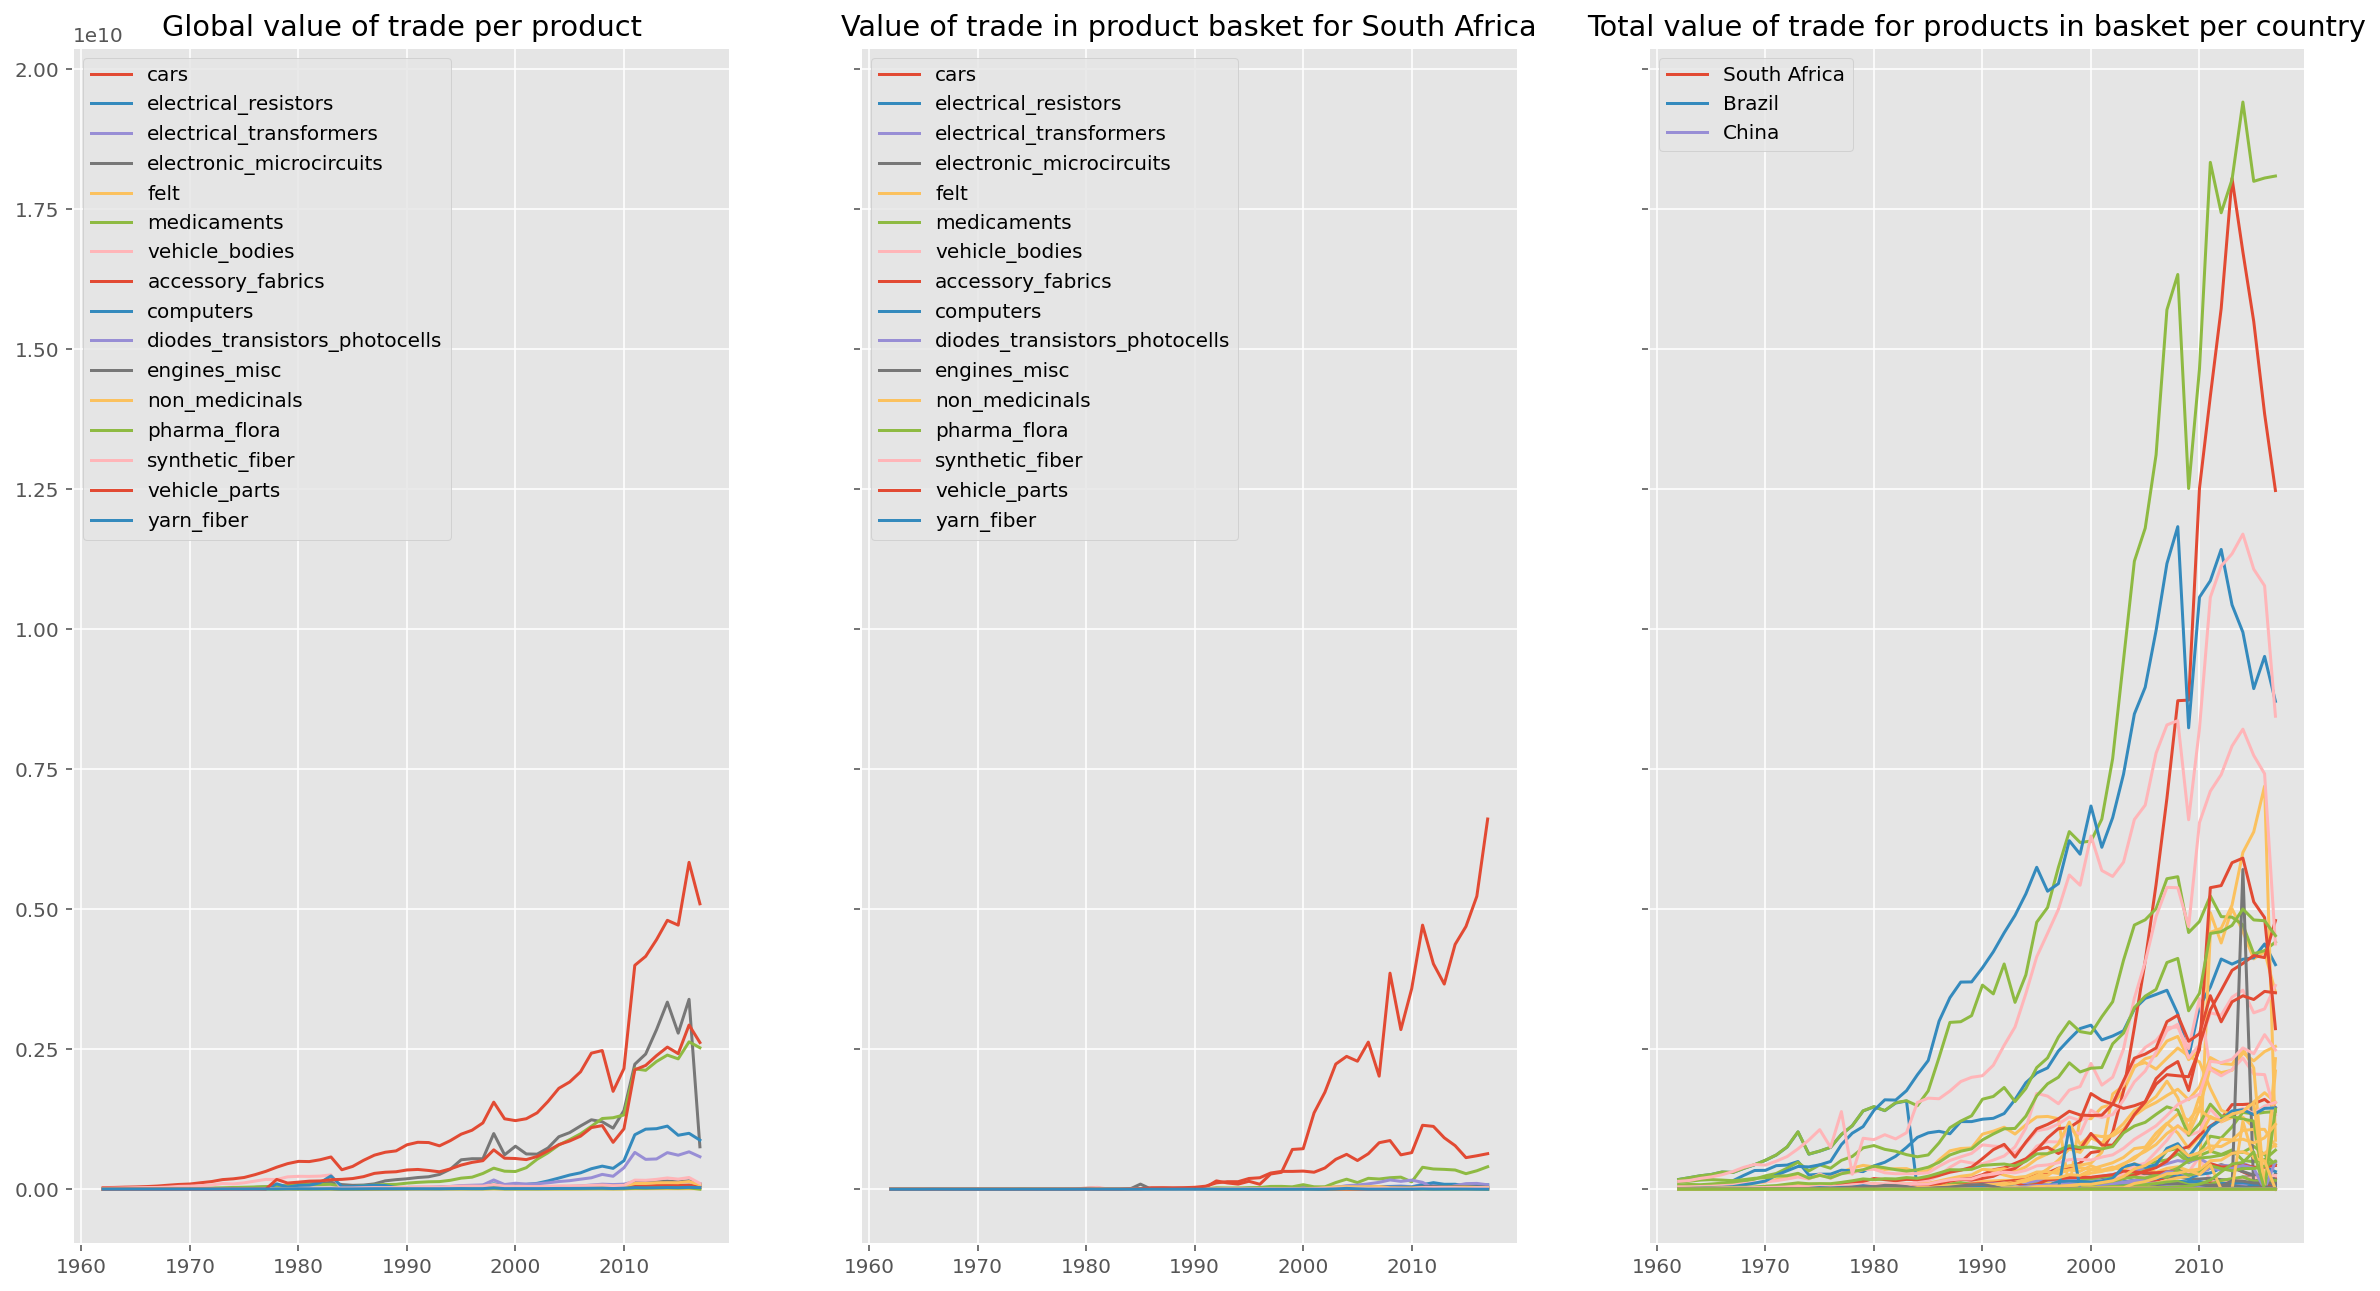

In [59]:
agg_south_africa.plot(subplots=True,figsize=(10, 12),title=f"Exports for {c} in trade basket",sharey=False)
plt.savefig(f"{PATH}/images/raw_south_africa")
plt.show()

fig, ((ax1, ax2,ax3)) = plt.subplots(nrows=1, ncols=3,sharey=True,figsize=(20, 11))

ax1.plot(agg_product)
ax1.title.set_text("Global value of trade per product")
ax1.legend(agg_product.columns,loc="upper left")

ax2.plot(agg_south_africa)
ax2.title.set_text("Value of trade in product basket for South Africa")
ax2.legend(agg_south_africa.columns,loc="upper left")

ax3.plot(agg_country)
ax3.title.set_text("Total value of trade for products in basket per country")
ax3.legend(['South Africa','Brazil','China'],loc="upper left")
# plt.plot(agg_south_africa,'--')
plt.savefig(f"{PATH}/images/global_overview_raw")
plt.show()

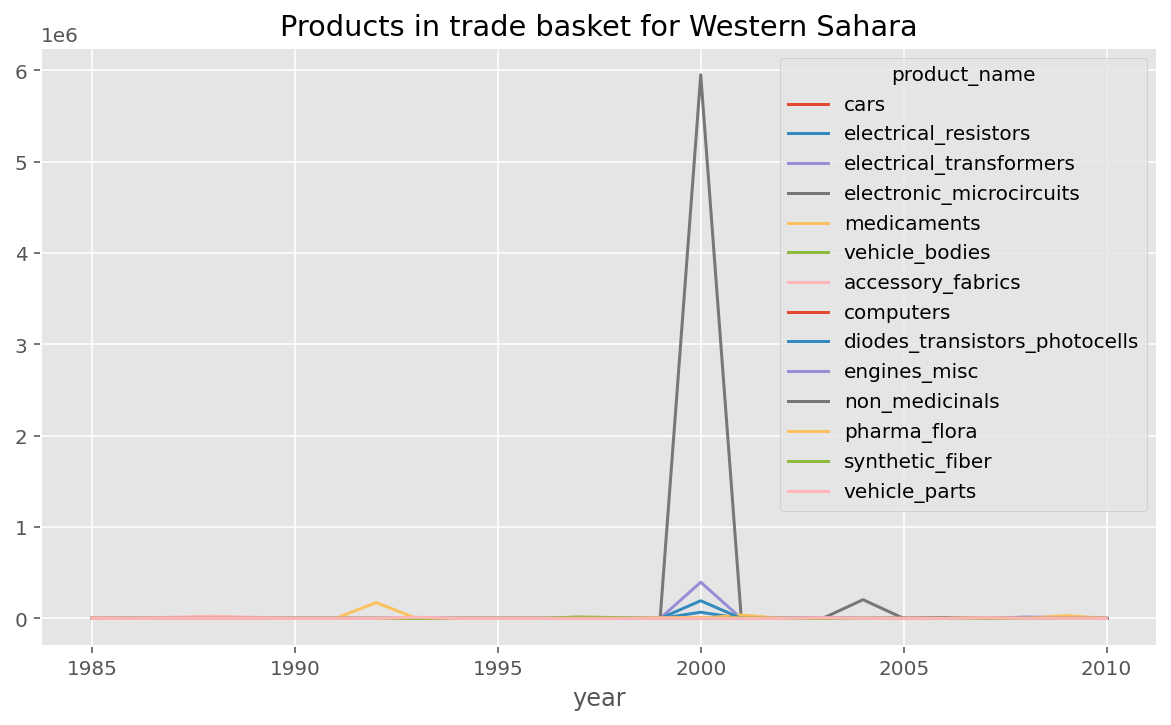

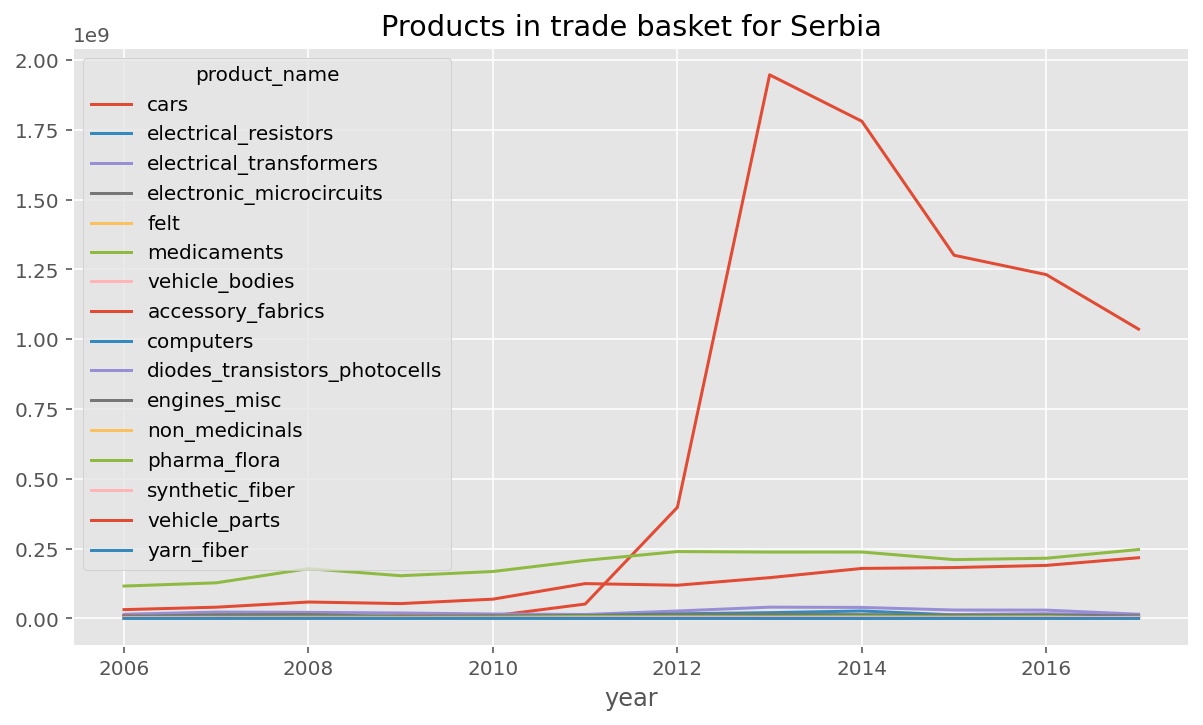

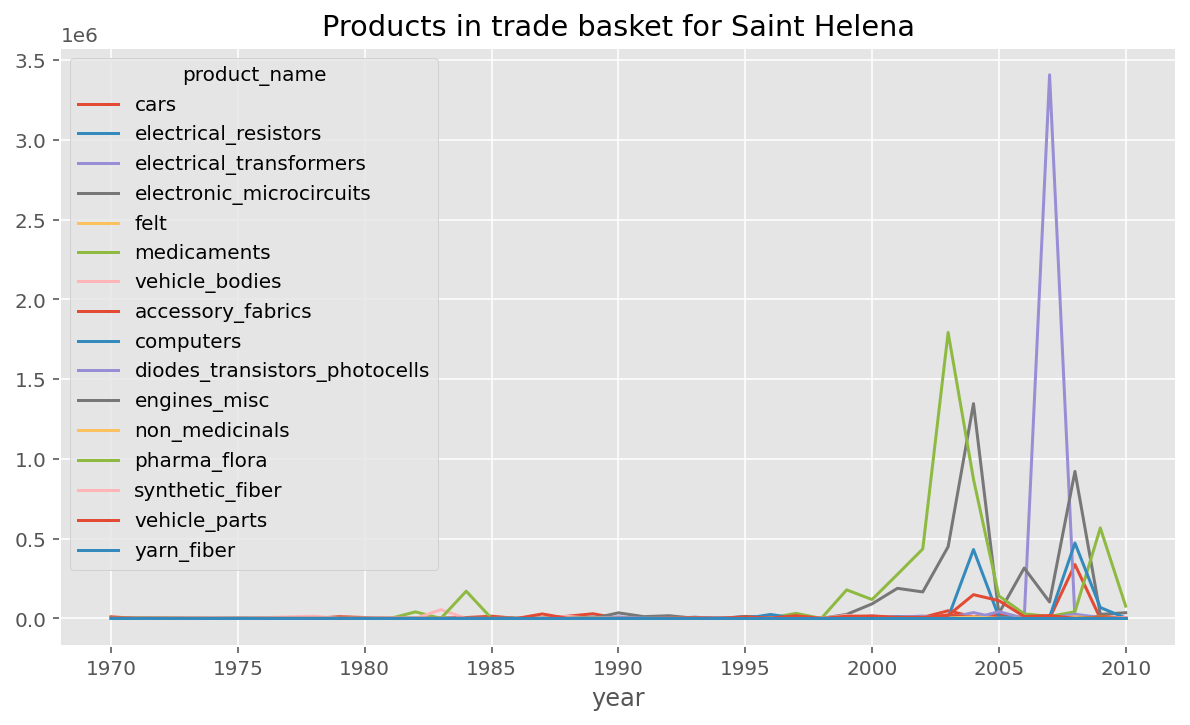

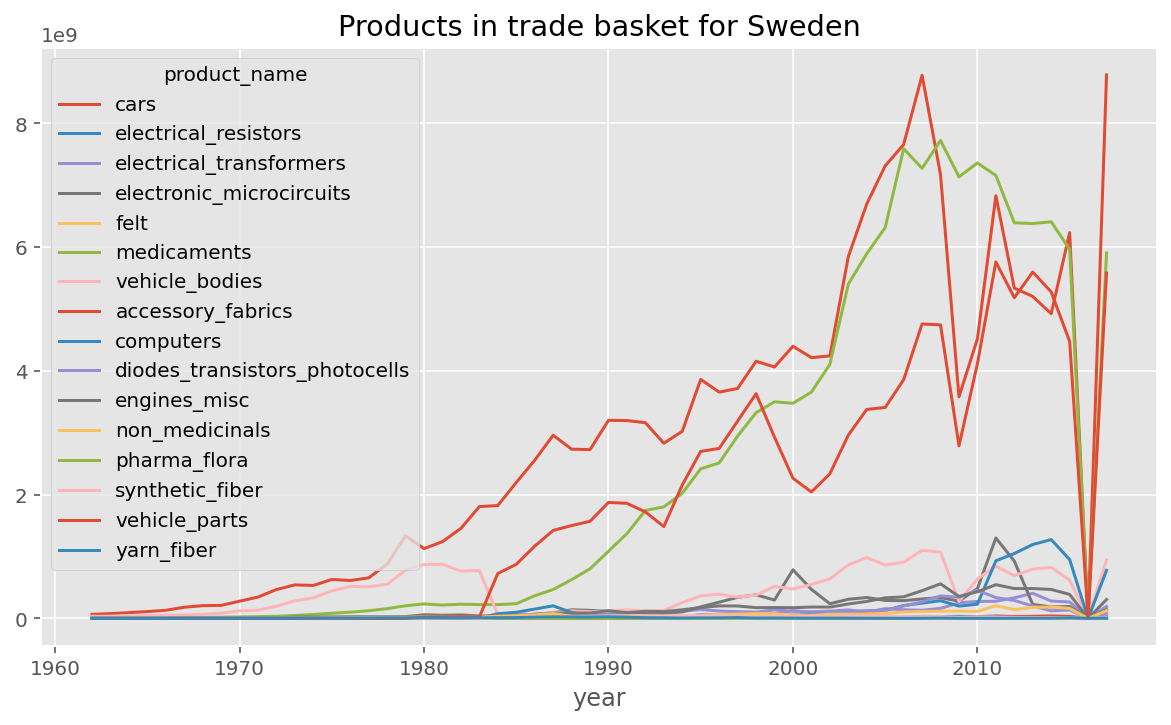

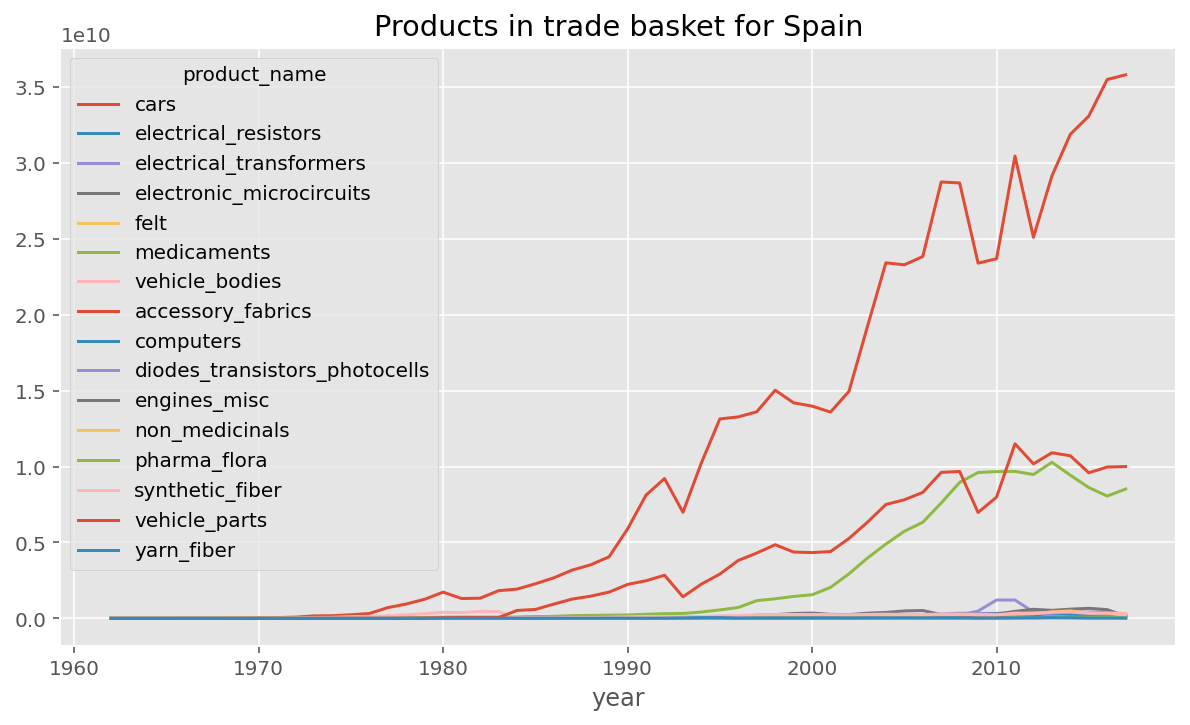

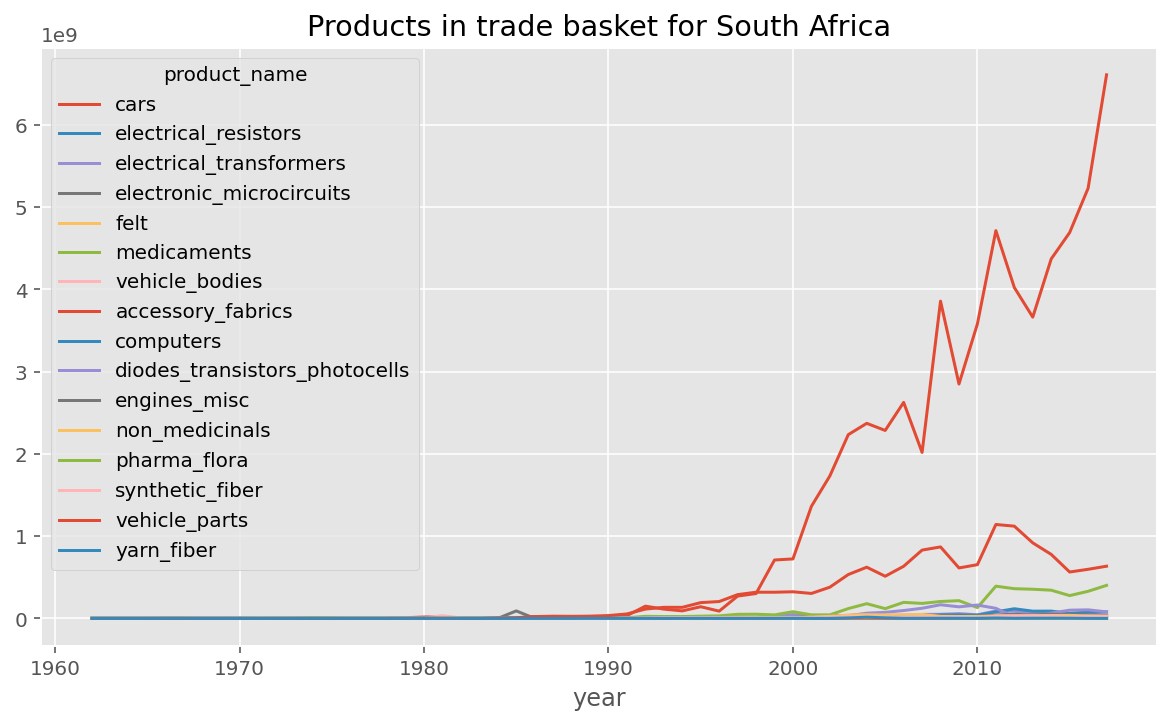

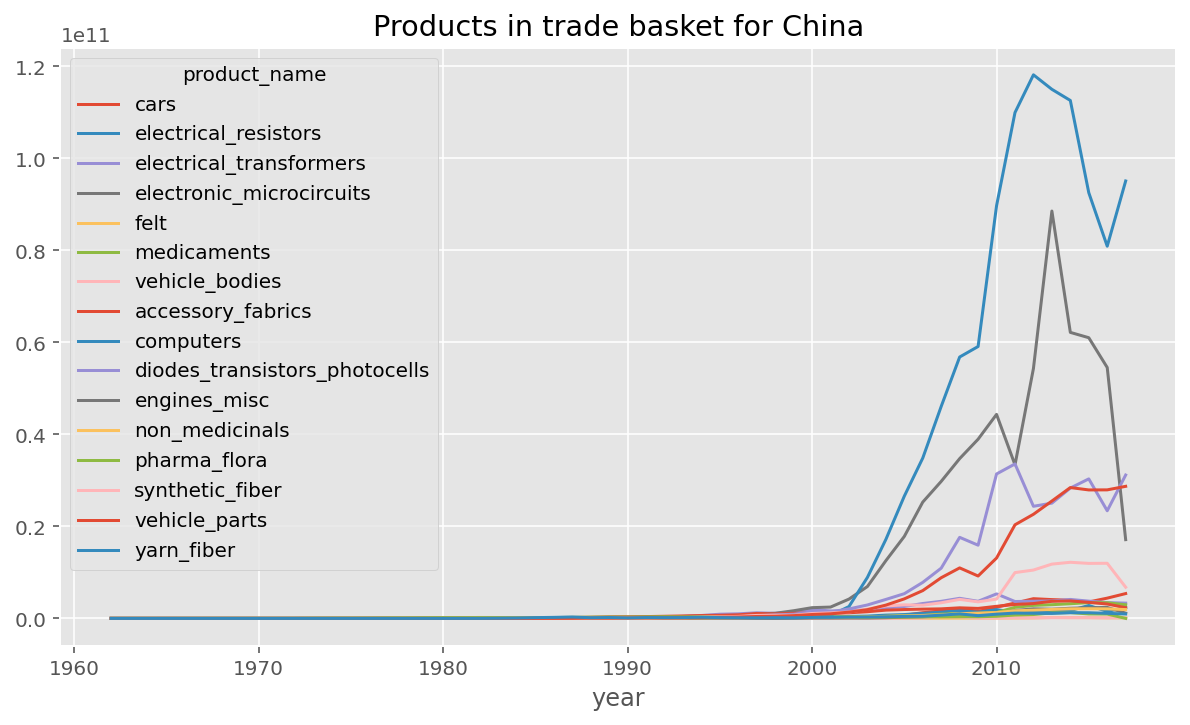

<Figure size 720x396 with 0 Axes>

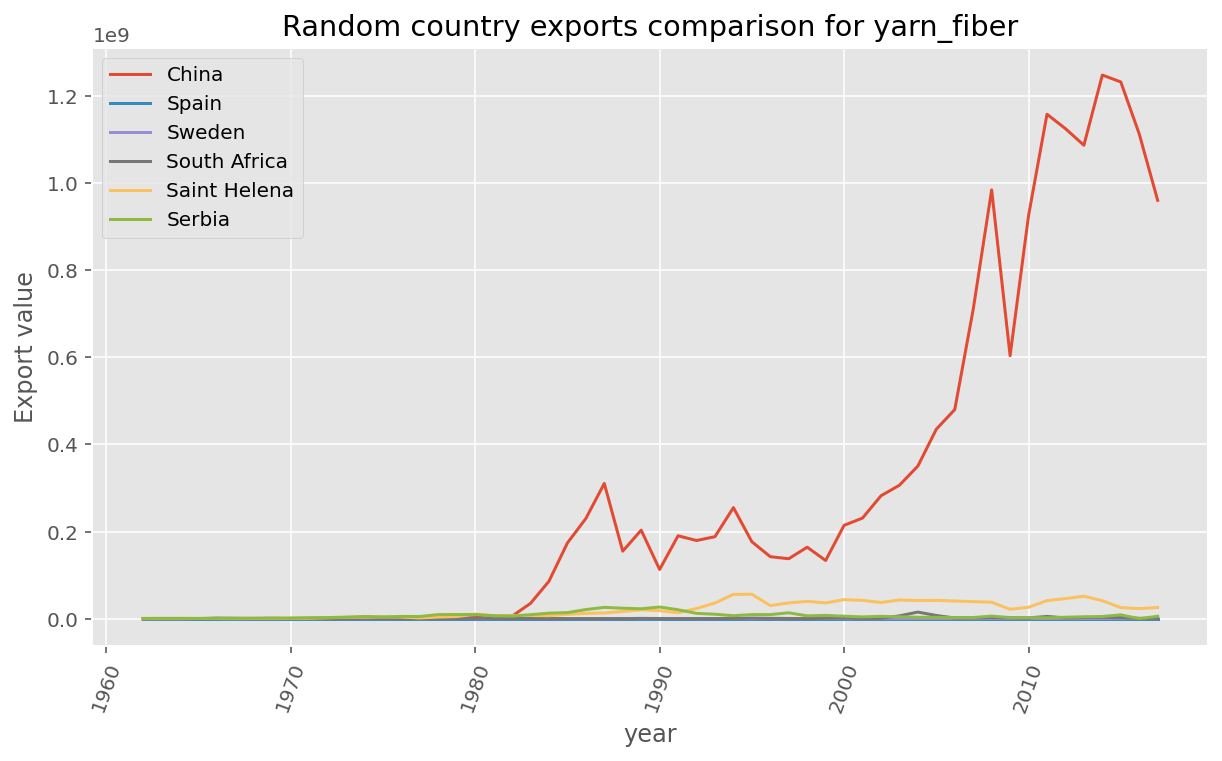

<Figure size 720x396 with 0 Axes>

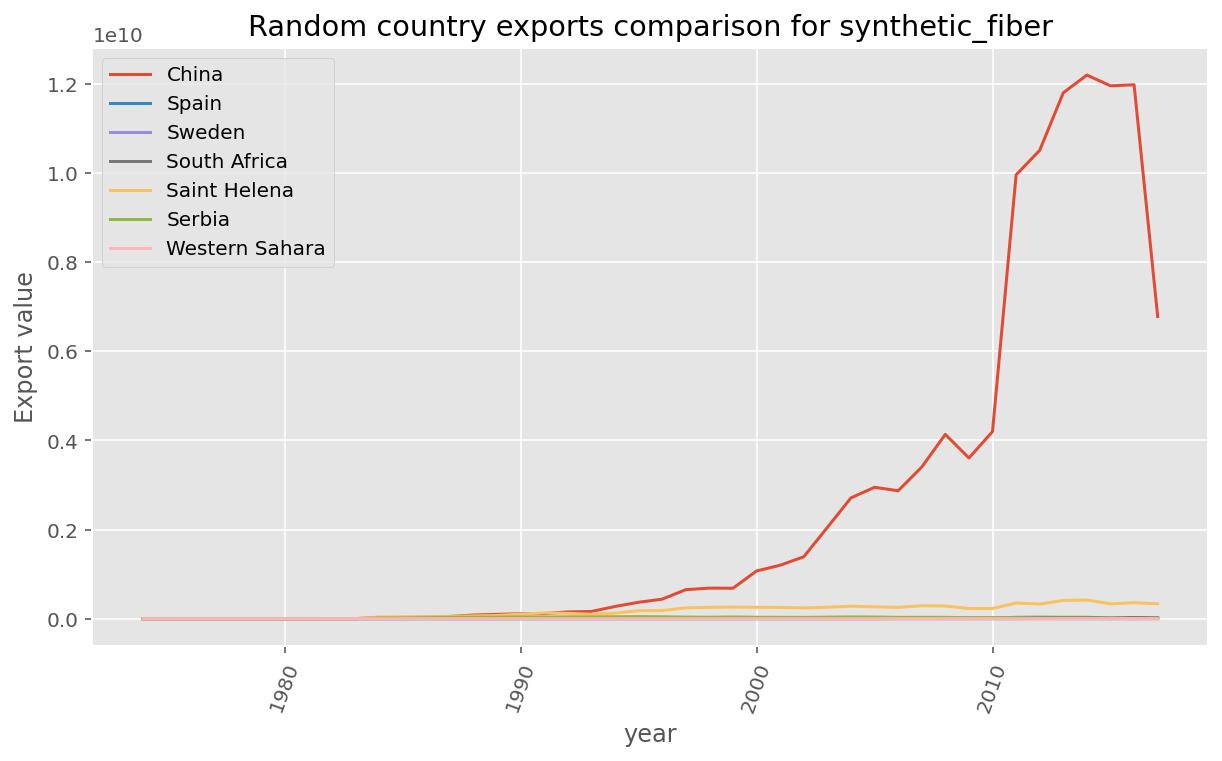

<Figure size 720x396 with 0 Axes>

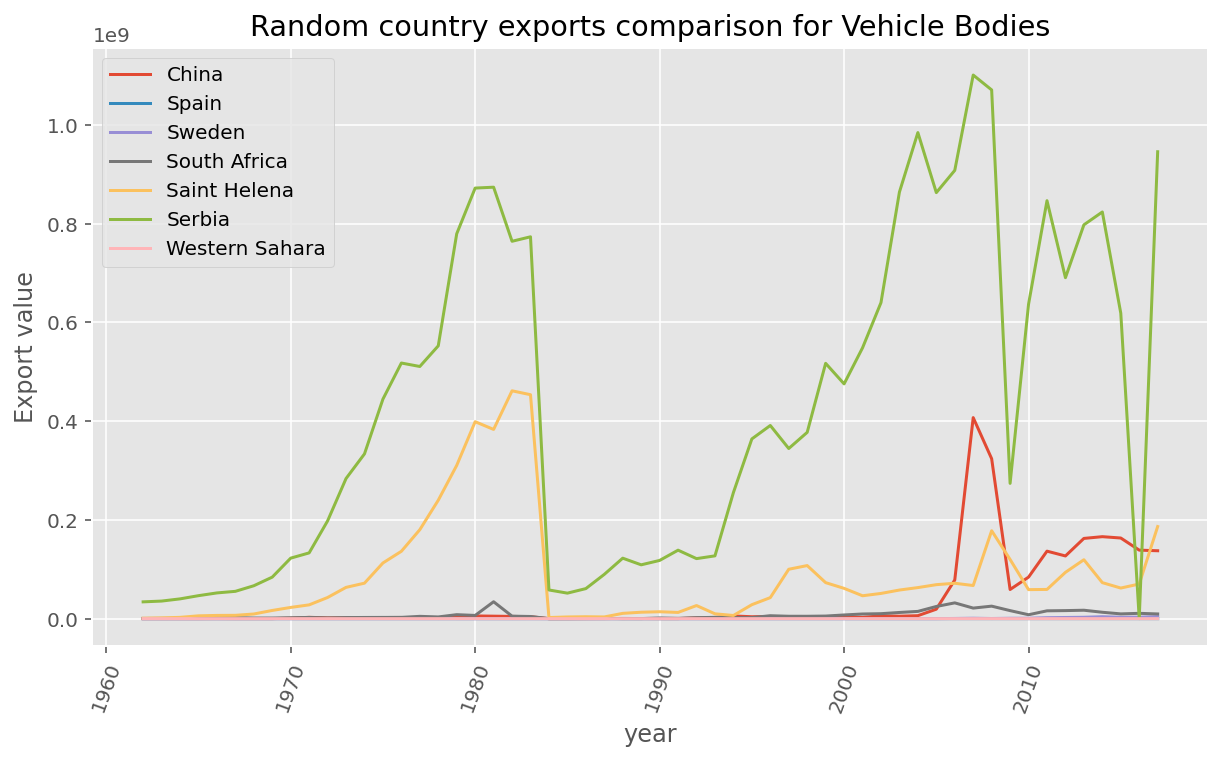

<Figure size 720x396 with 0 Axes>

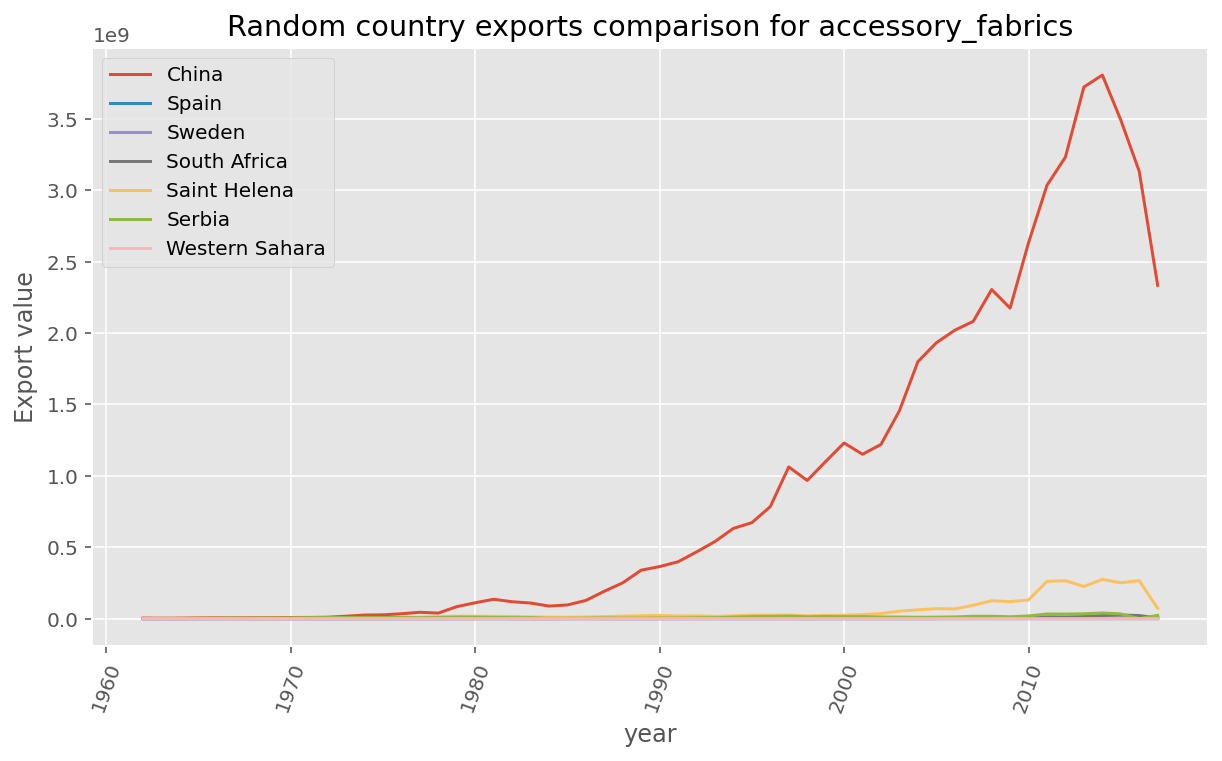

<Figure size 720x396 with 0 Axes>

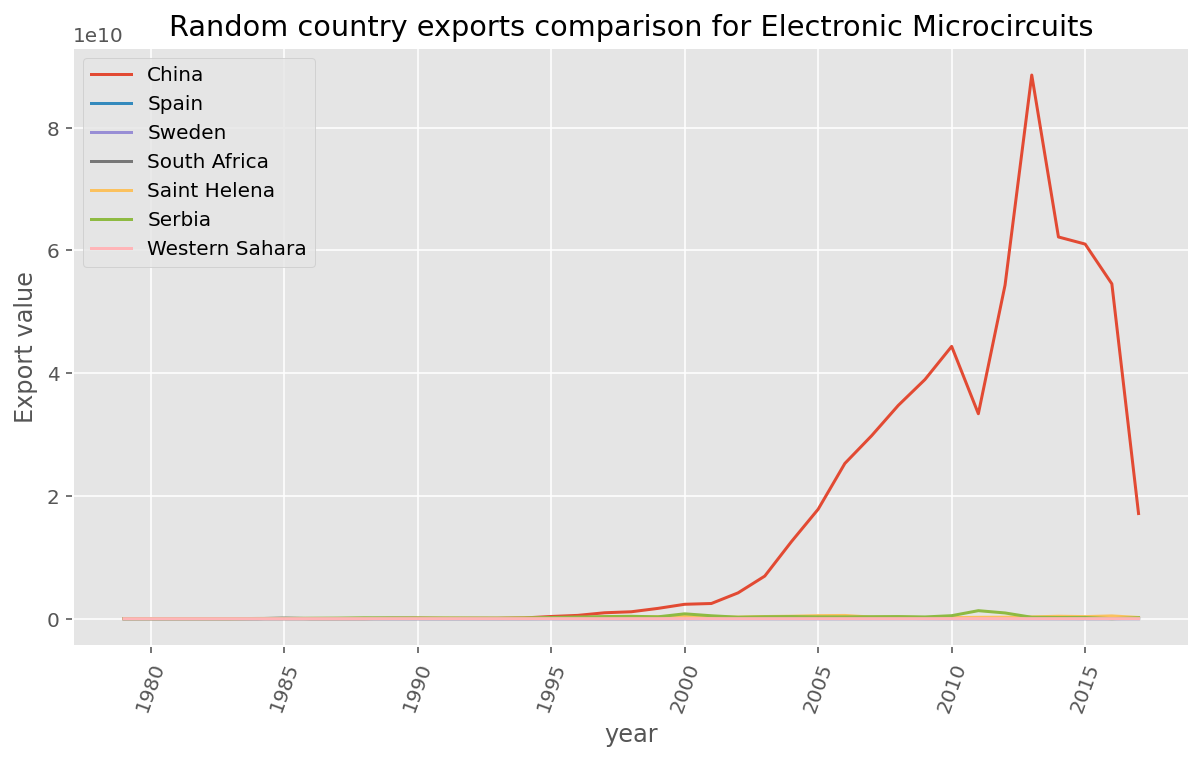

<Figure size 720x396 with 0 Axes>

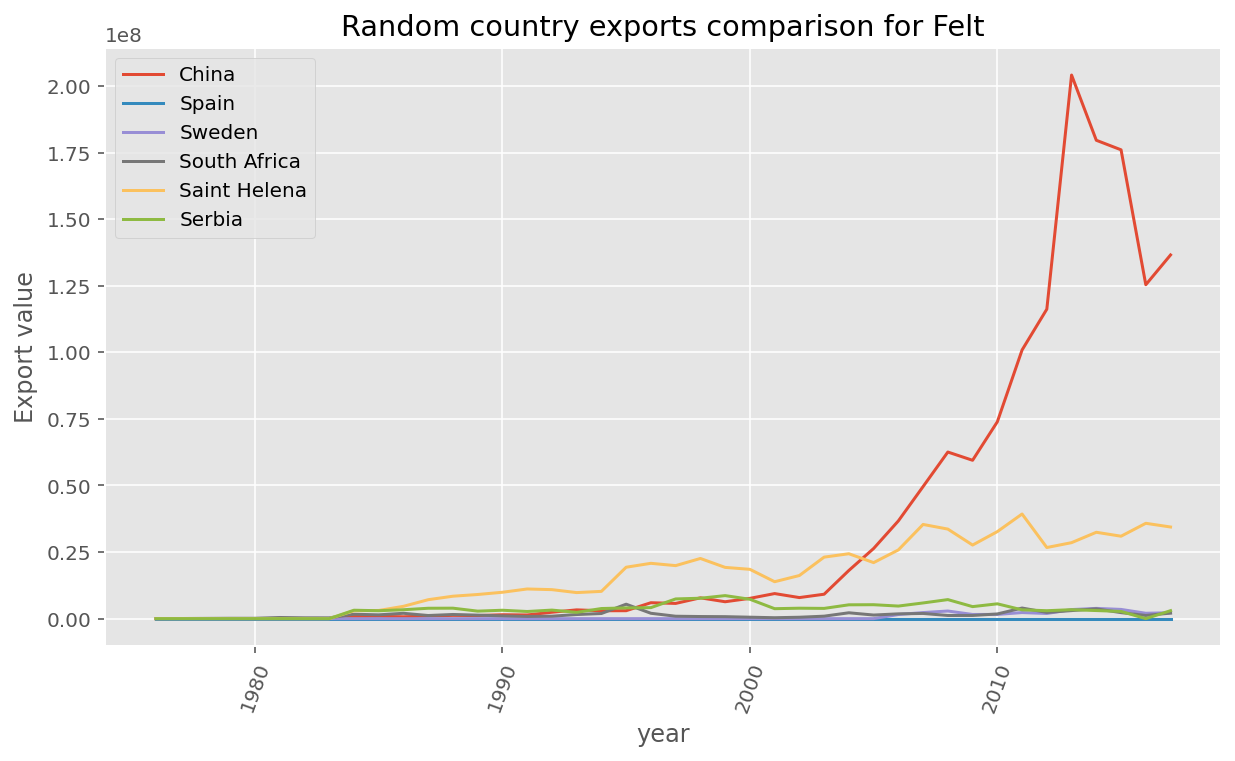

<Figure size 720x396 with 0 Axes>

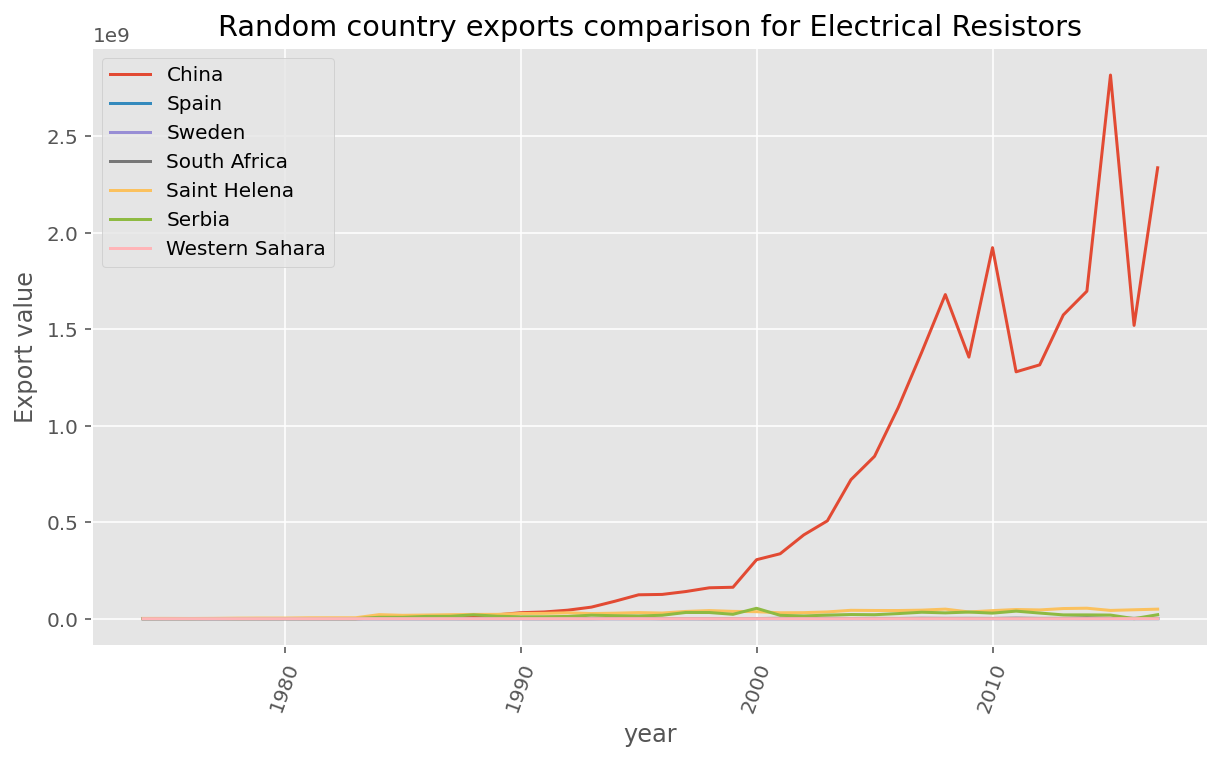

<Figure size 720x396 with 0 Axes>

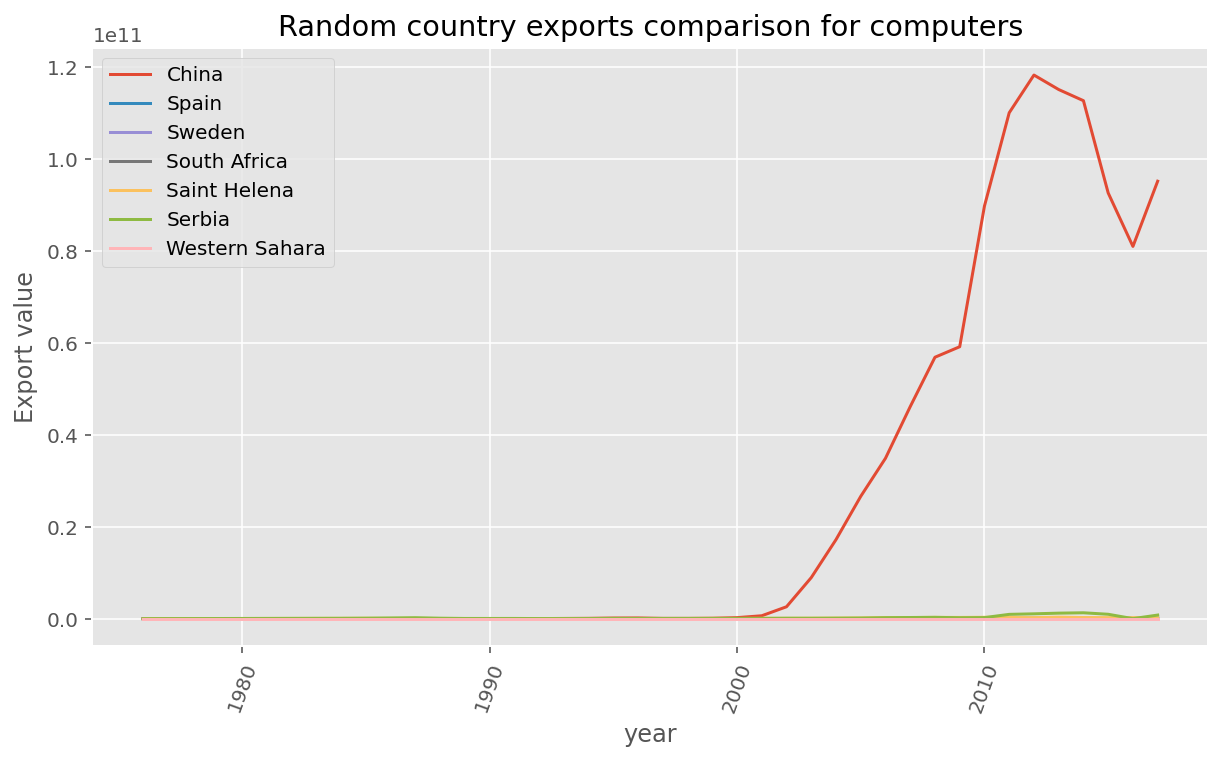

<Figure size 720x396 with 0 Axes>

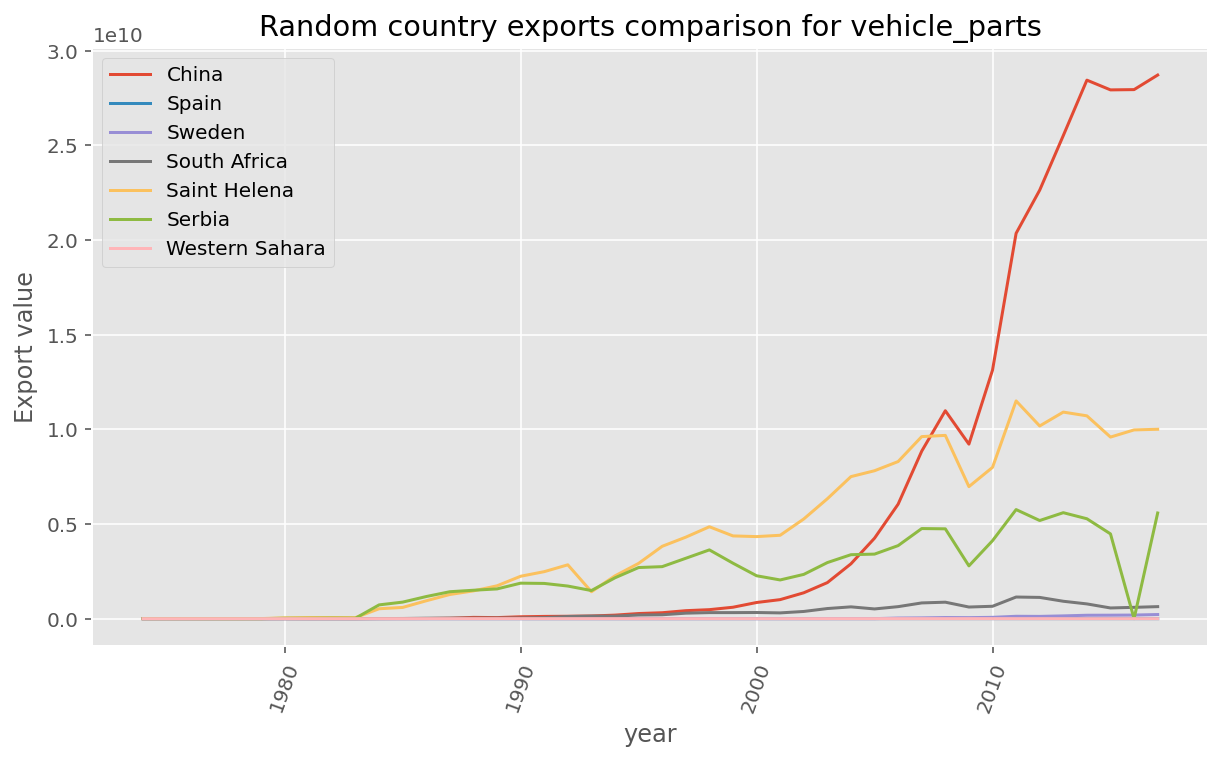

<Figure size 720x396 with 0 Axes>

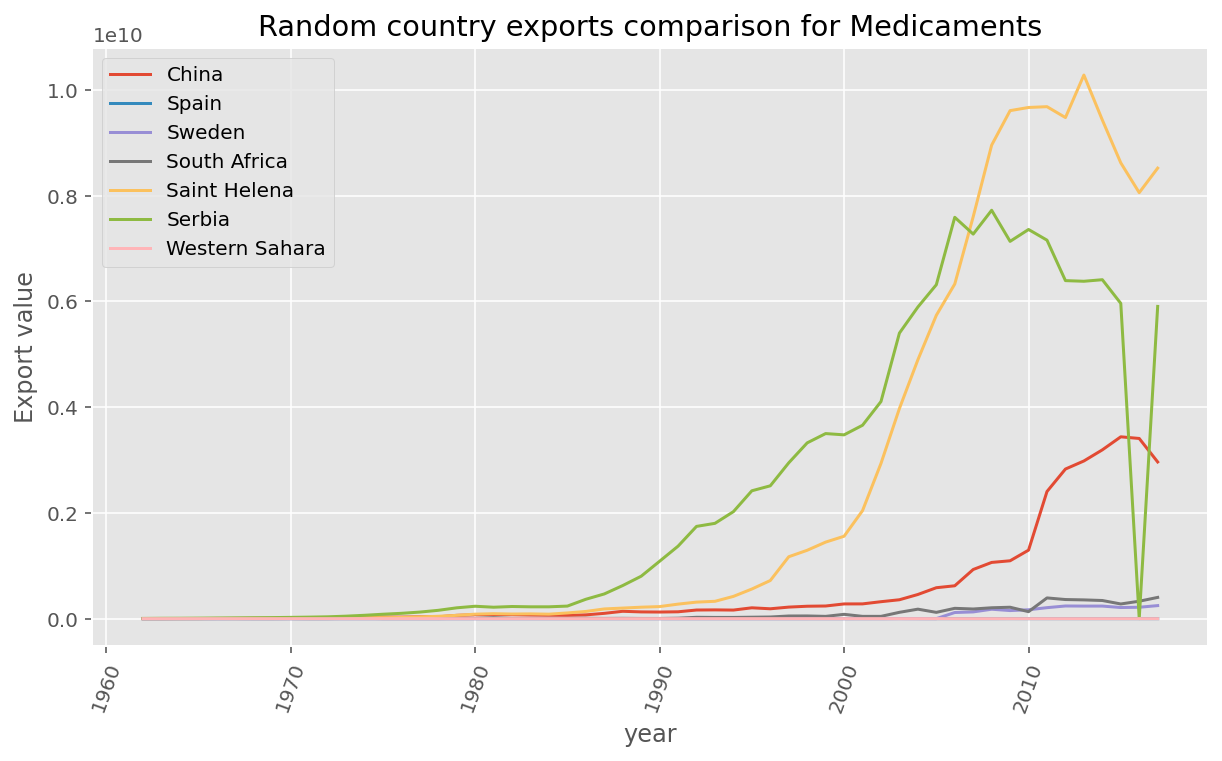

<Figure size 720x396 with 0 Axes>

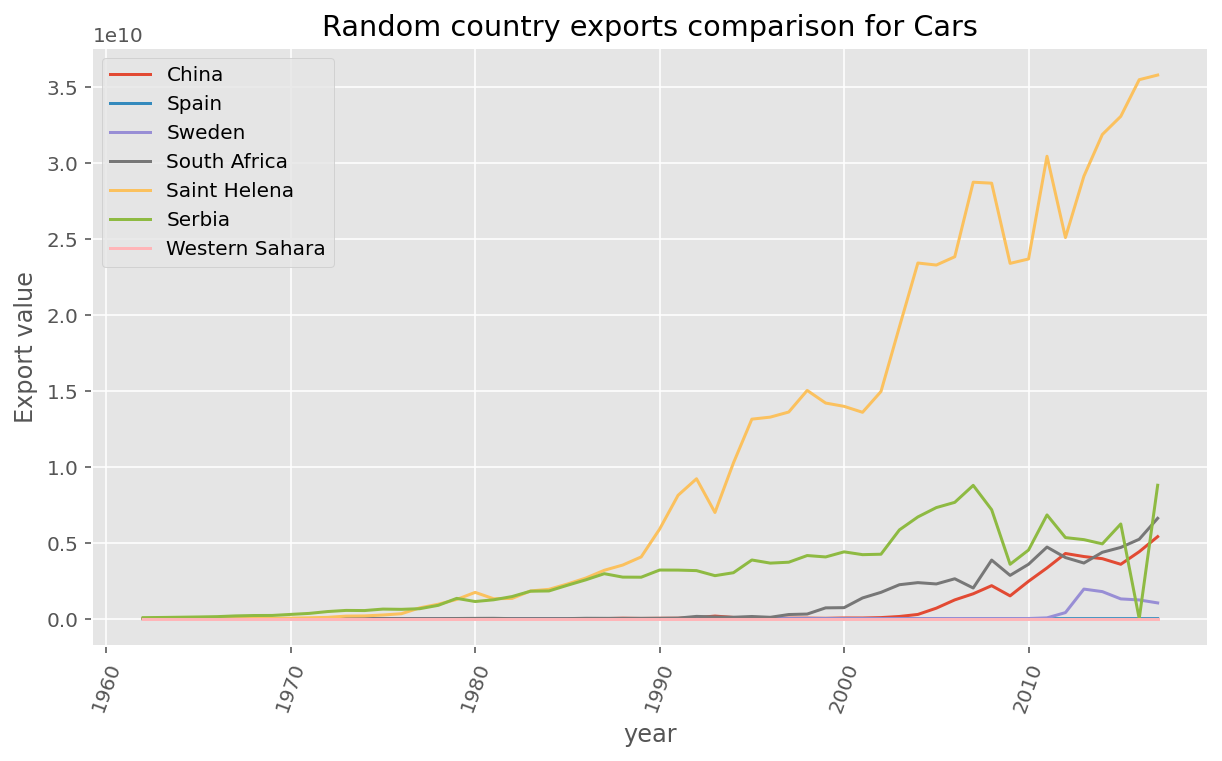

<Figure size 720x396 with 0 Axes>

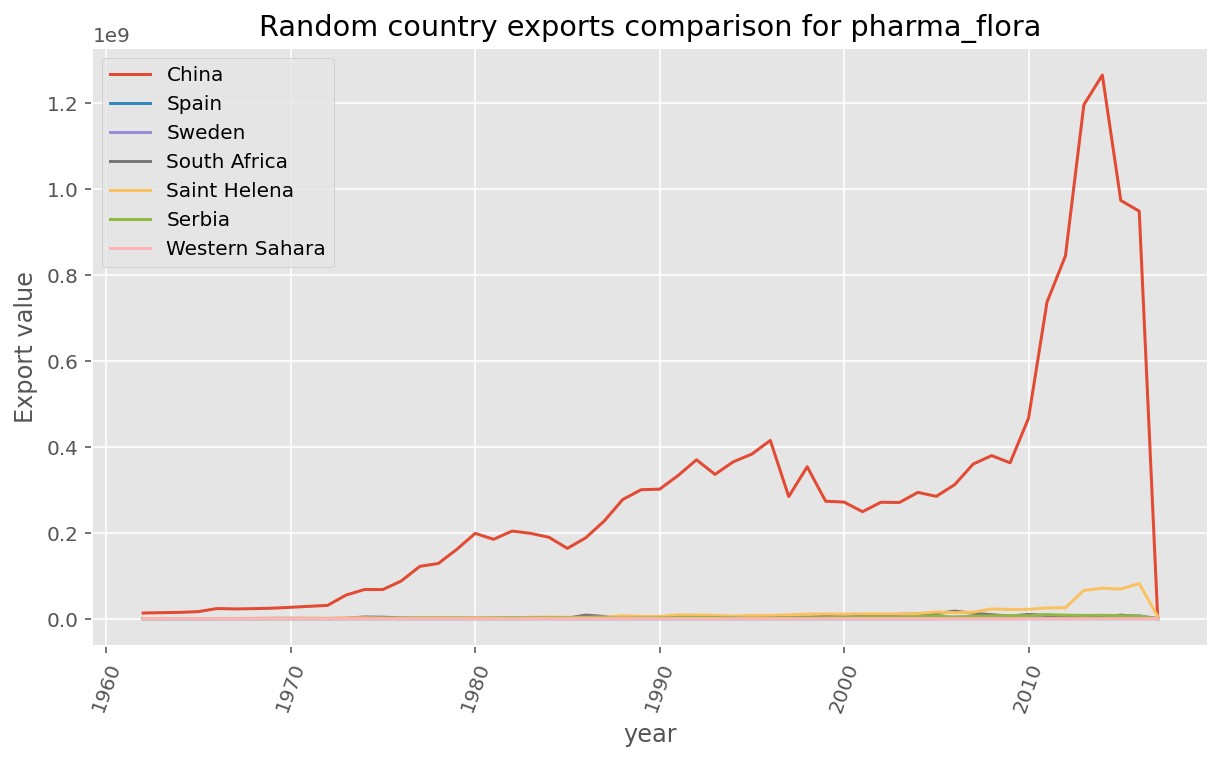

<Figure size 720x396 with 0 Axes>

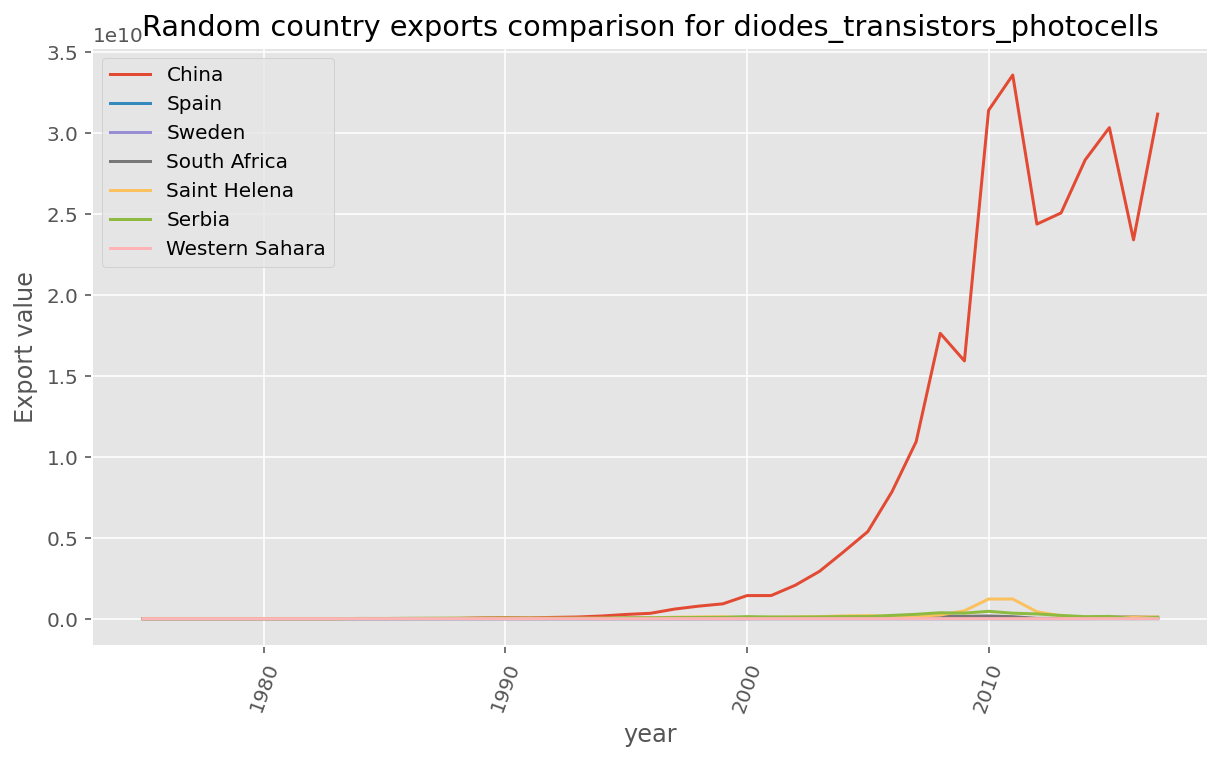

<Figure size 720x396 with 0 Axes>

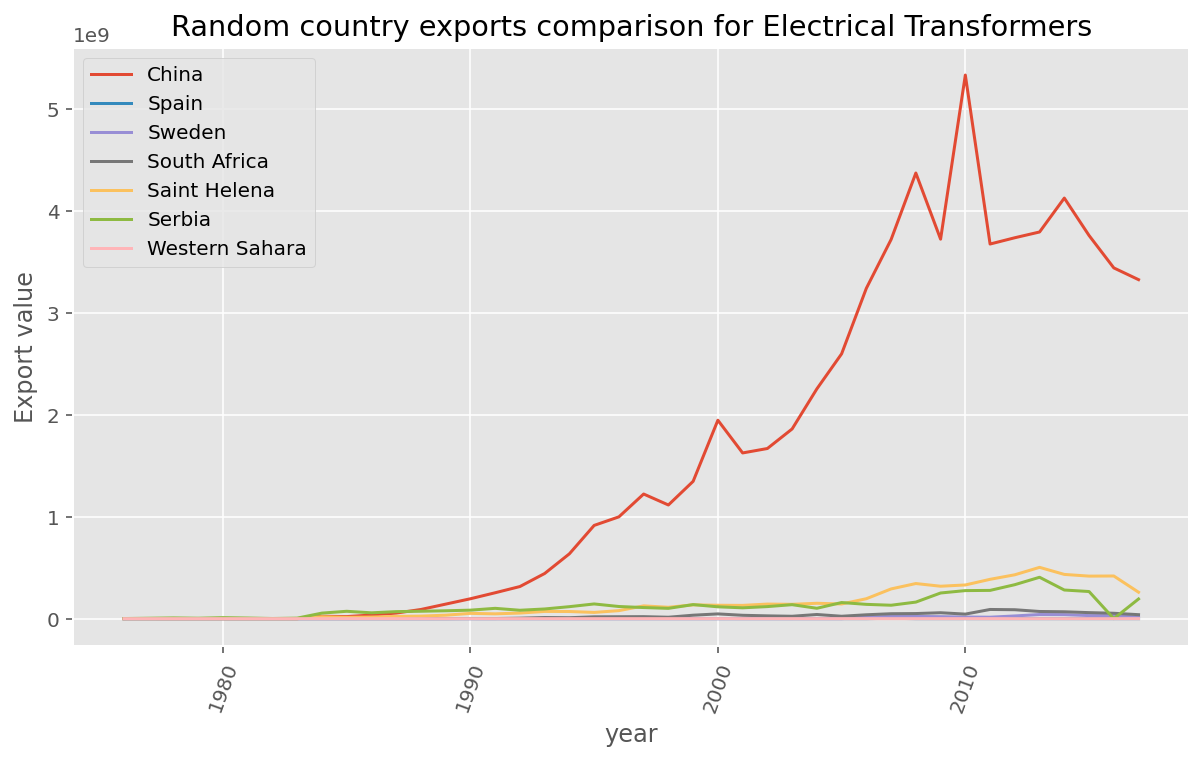

<Figure size 720x396 with 0 Axes>

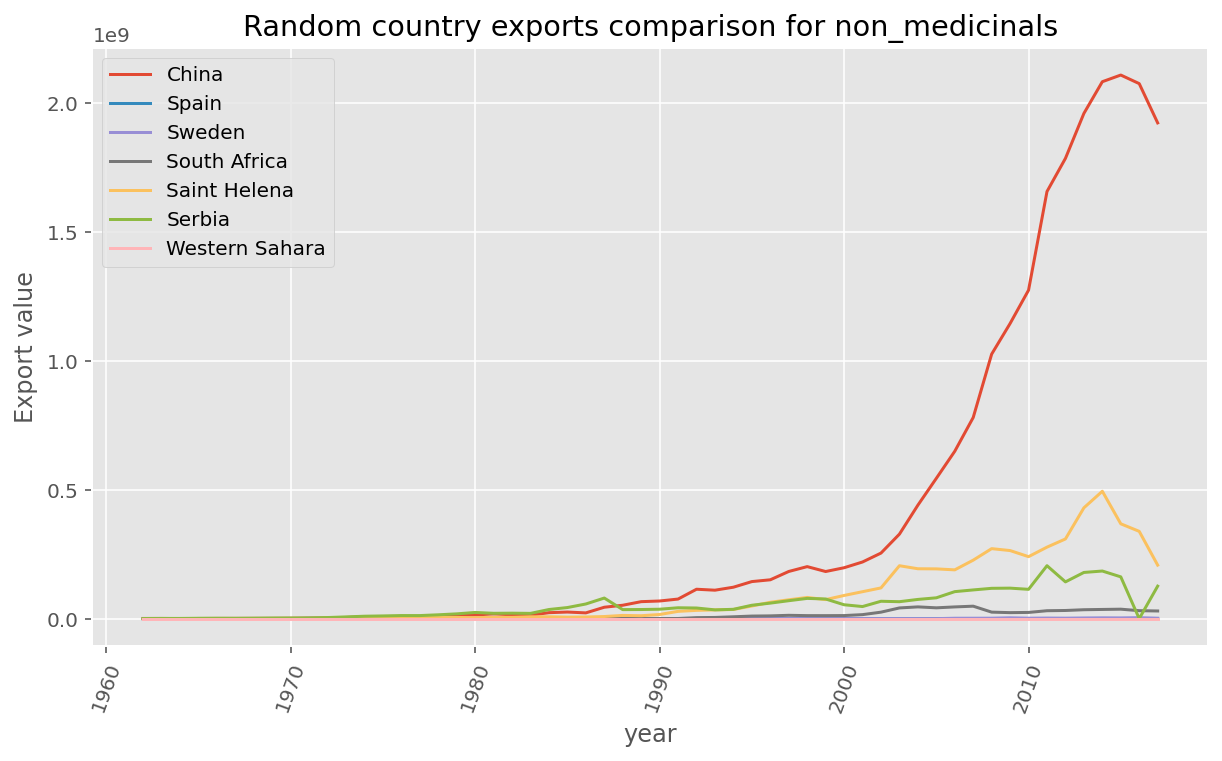

<Figure size 720x396 with 0 Axes>

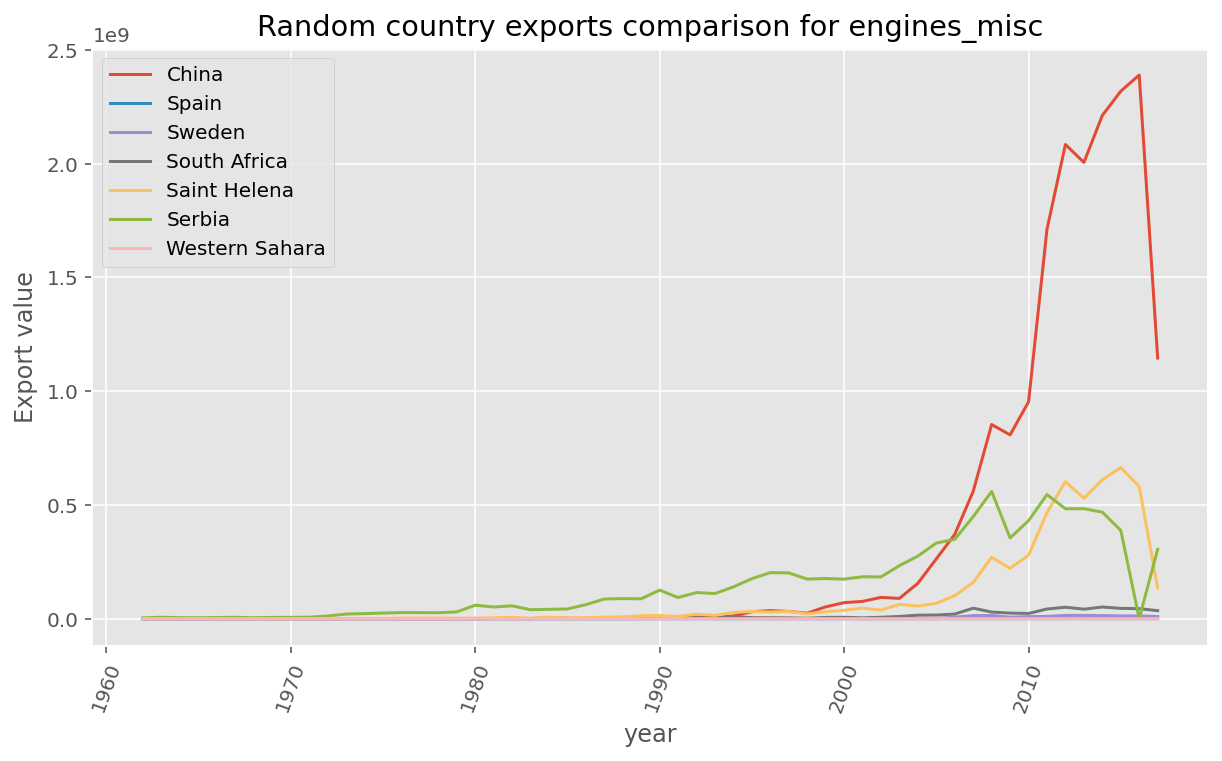

In [60]:
random.seed(20)
random_countries = sample(list(agg_country.columns), 5)
random_countries.extend(['South Africa','China'])
countries = trade_dframe[trade_dframe['country'].isin(random_countries)]
for c in random_countries:
  agg_random_countries = pd.pivot_table(trade_dframe[trade_dframe.country==c], 
                                        index='year', columns='product_name', 
                                        values='export_val',
                                        aggfunc=np.mean)
  agg_random_countries.fillna(0,inplace=True)
  underscore_header_names(agg_random_countries)
  agg_random_countries.plot(subplots=False,figsize=(10,5.5),
                            title=f"Products in trade basket for {c}",sharey=True)
  plt.savefig(f"{c}_trade_basket")

# Plots for country comparison per product 
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  product.fillna(0,inplace=True)
  product.to_csv(f'{PATH}/products_per_country/{id}_sitc.csv')
  product_by_countries = pd.pivot_table(countries[countries.product_name==id], index='year', 
                           columns='country',values='export_val',aggfunc=np.mean)
  product_by_countries.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  product_by_countries.plot(subplots=False,figsize=(10,5.5),
                            title=(f"Random country exports comparison for {id}"))
  plt.xticks(rotation=70)
  plt.ylabel("Export value")
  plt.legend(countries['country'].unique())
  plt.savefig(f"raw_{id}_country_comparison")
  plt.show()

## Rescale time series to the global mean for the product

Some random countries have no data, a fixed list will be plotted


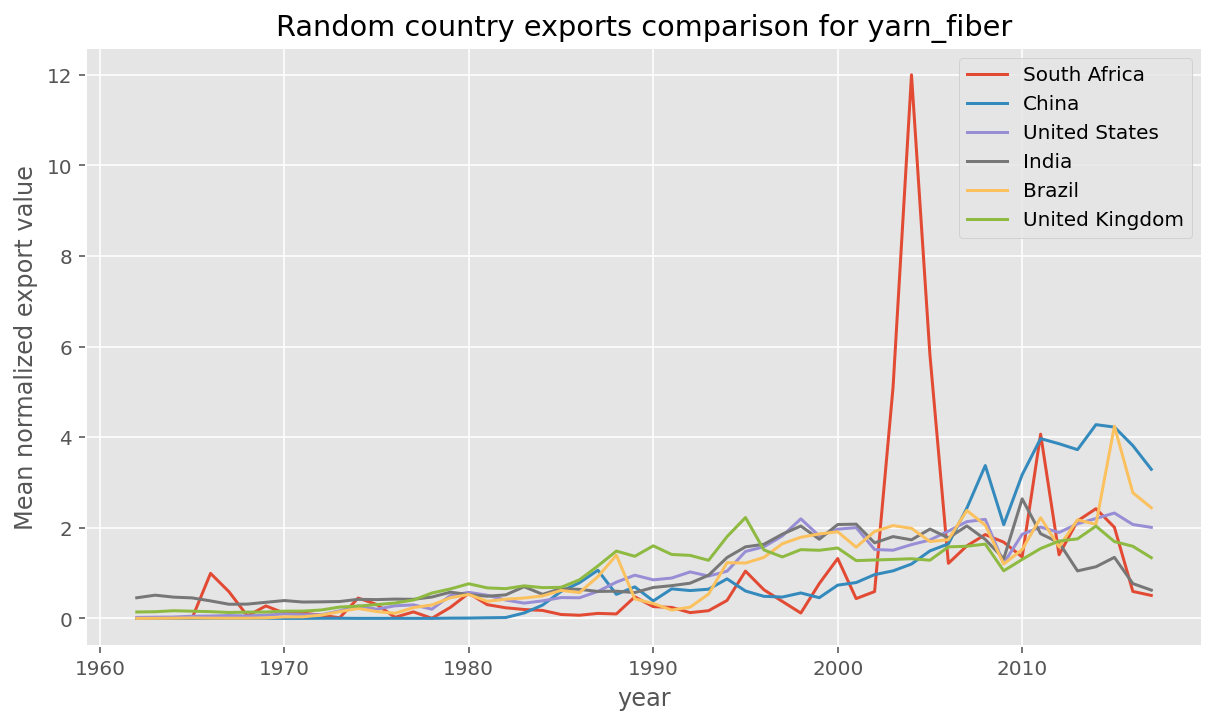

Some random countries have no data, a fixed list will be plotted


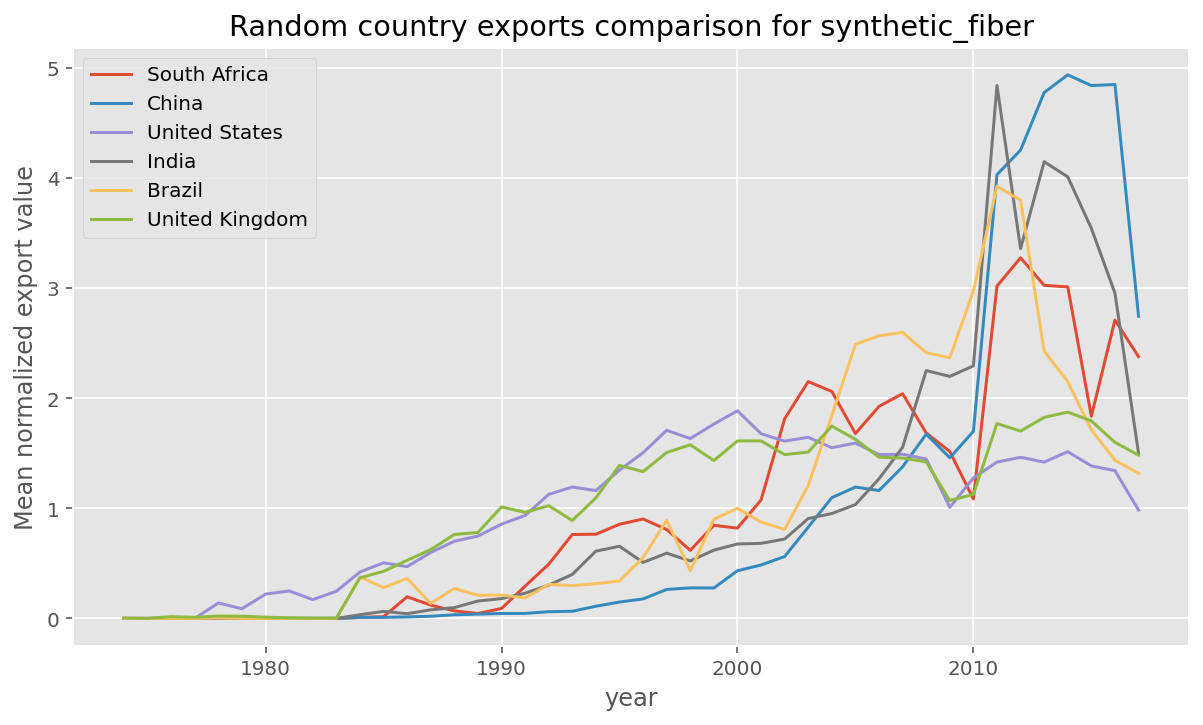

Some random countries have no data, a fixed list will be plotted


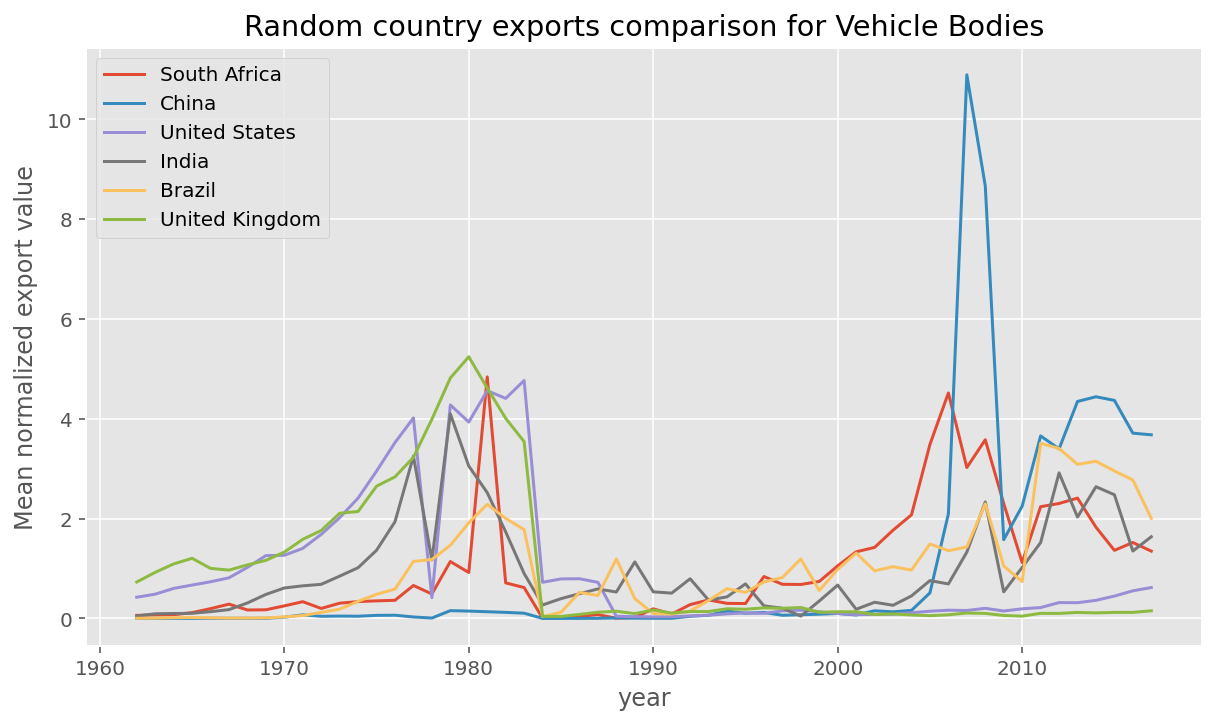

Some random countries have no data, a fixed list will be plotted


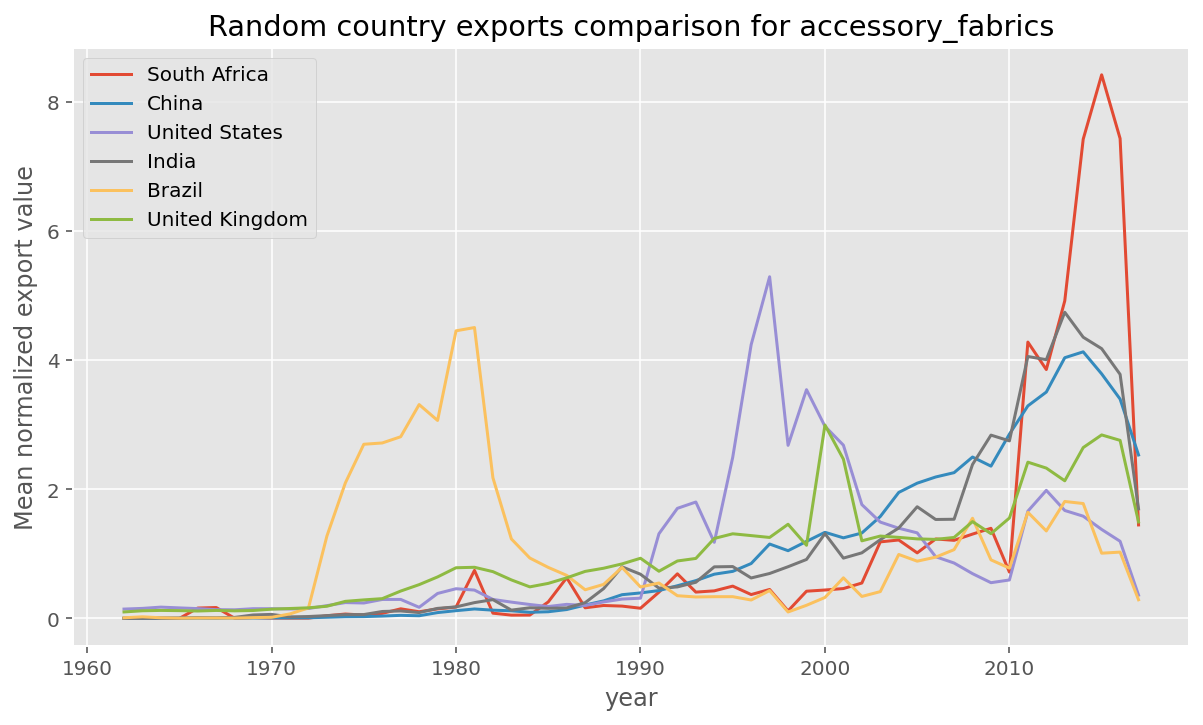

Some random countries have no data, a fixed list will be plotted


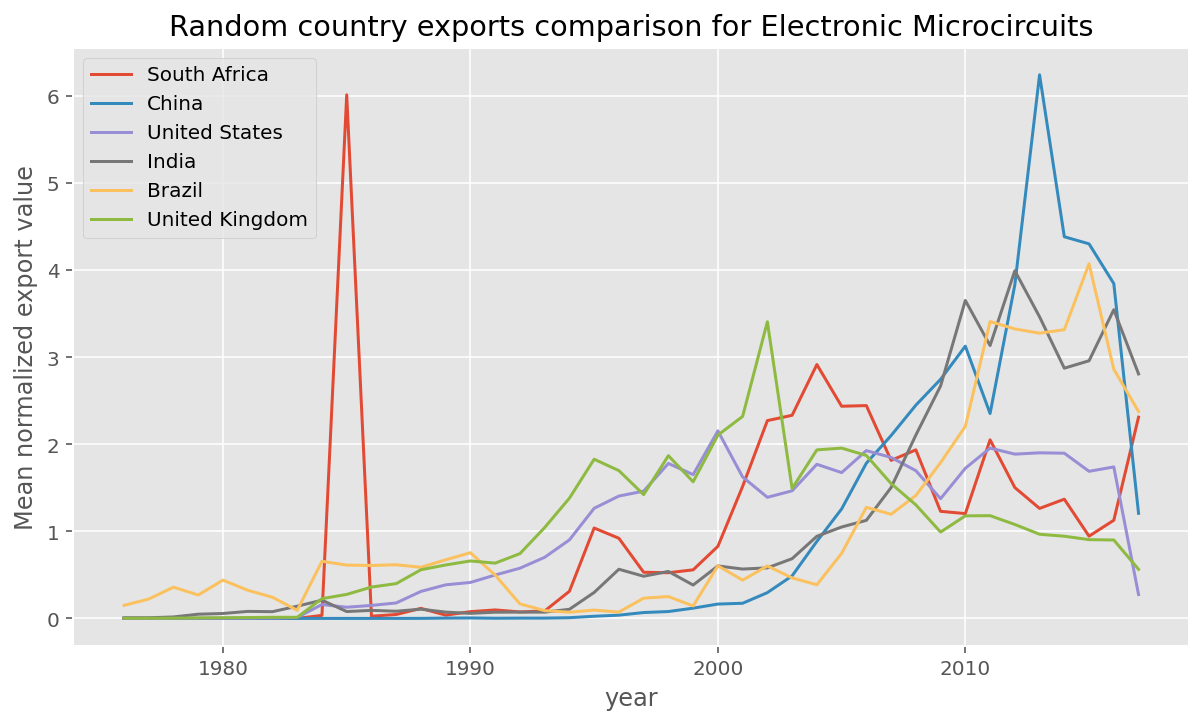

Some random countries have no data, a fixed list will be plotted


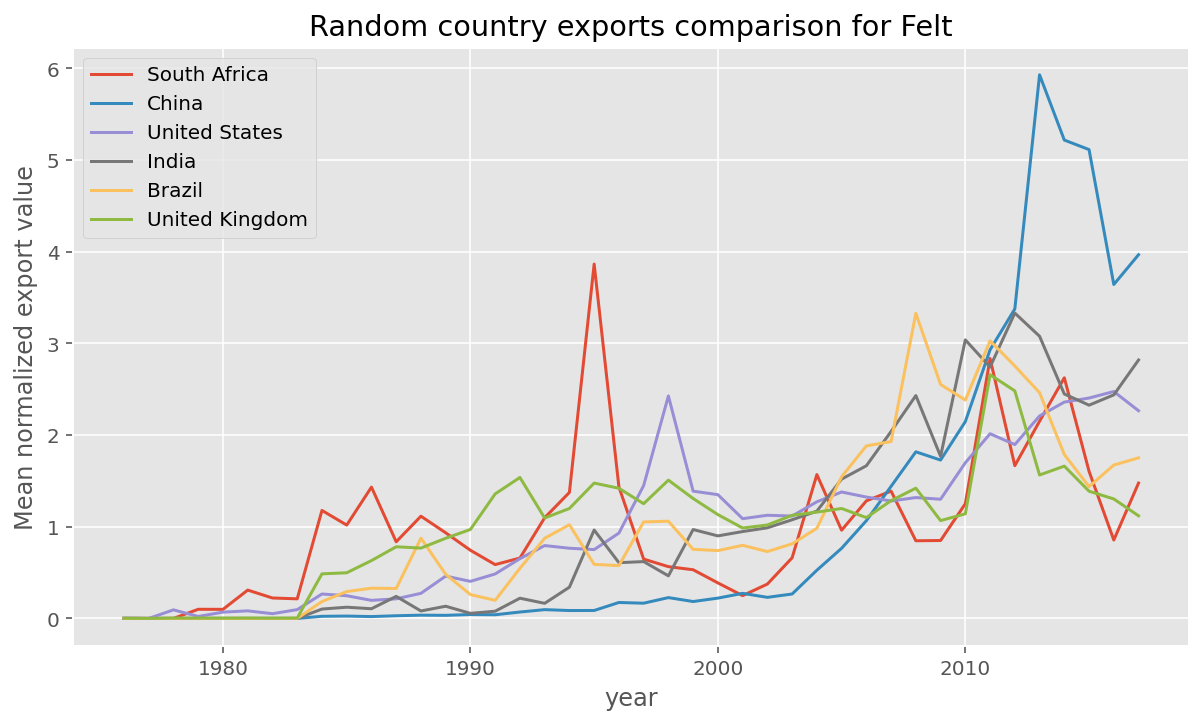

Some random countries have no data, a fixed list will be plotted


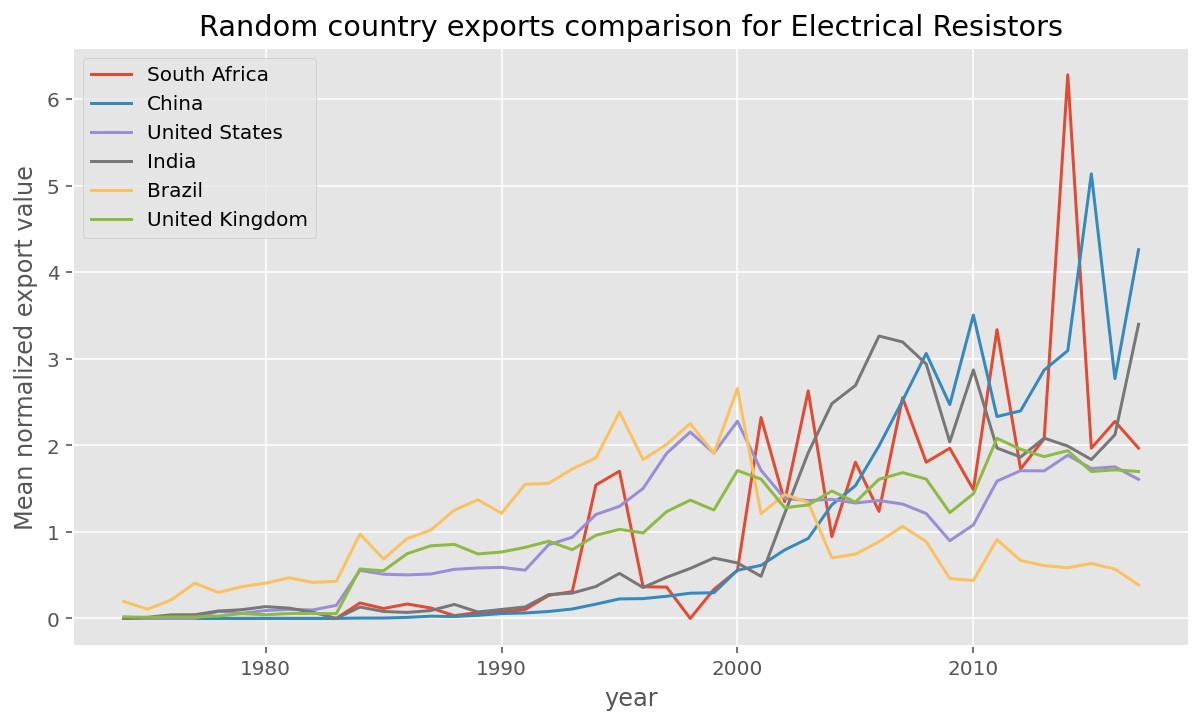

Some random countries have no data, a fixed list will be plotted


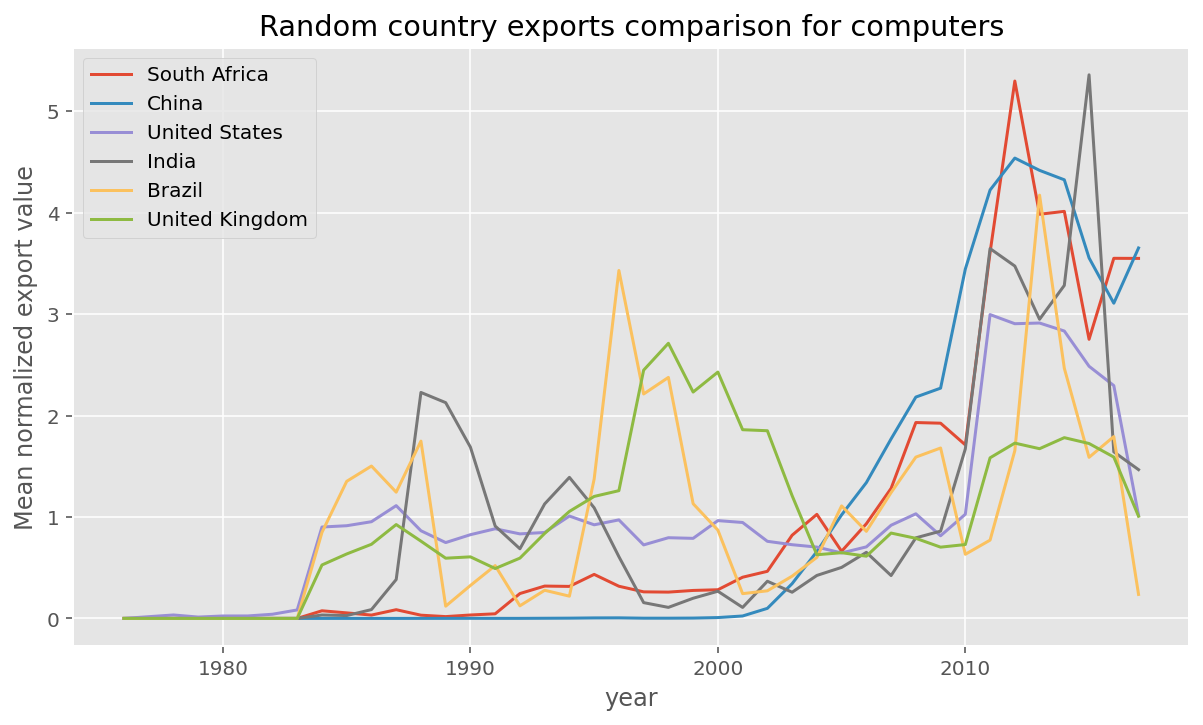

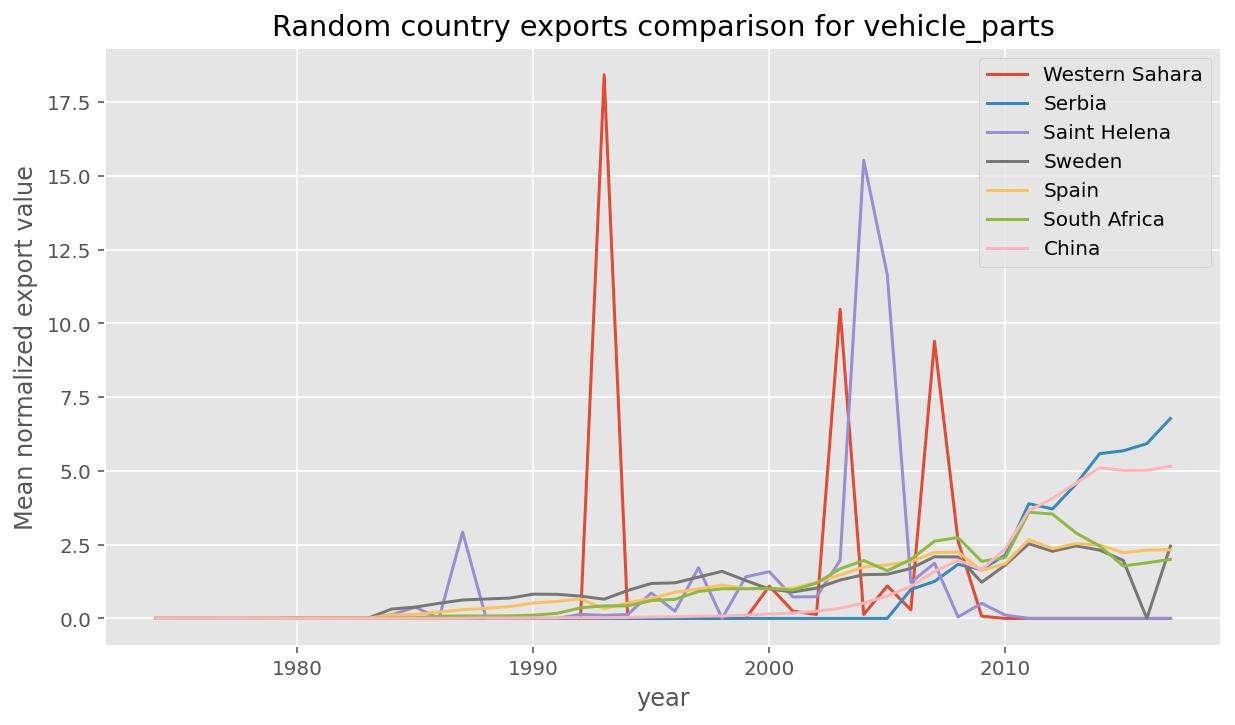

Some random countries have no data, a fixed list will be plotted


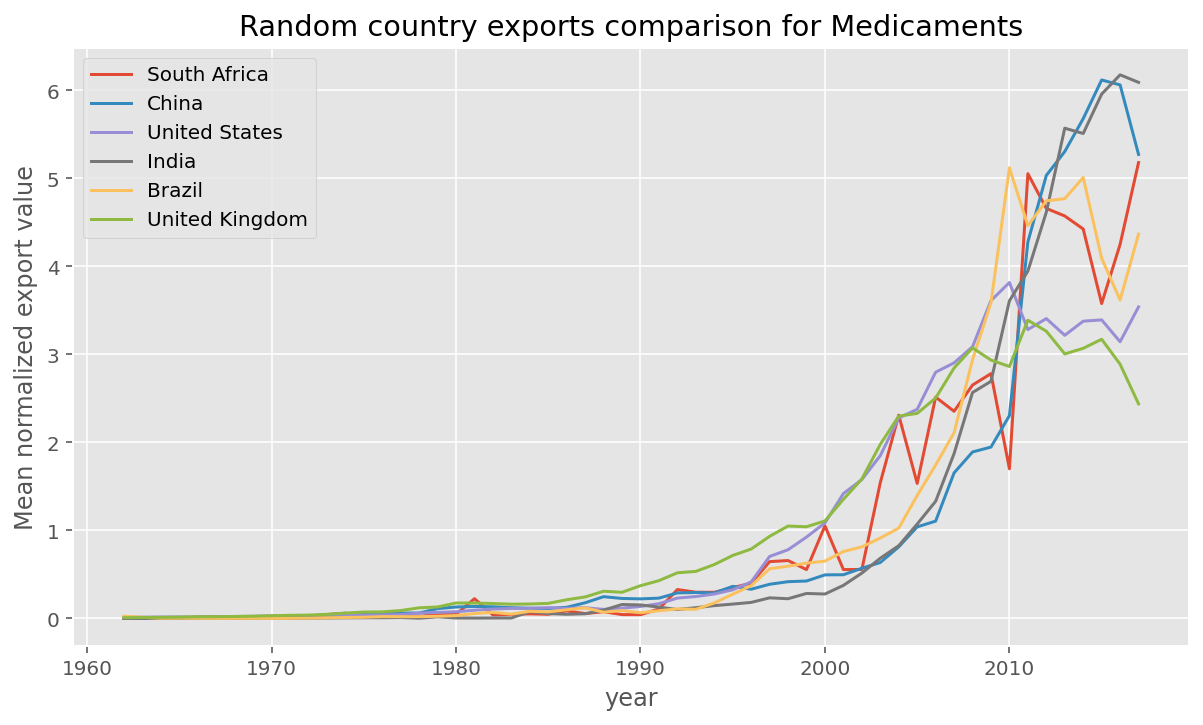

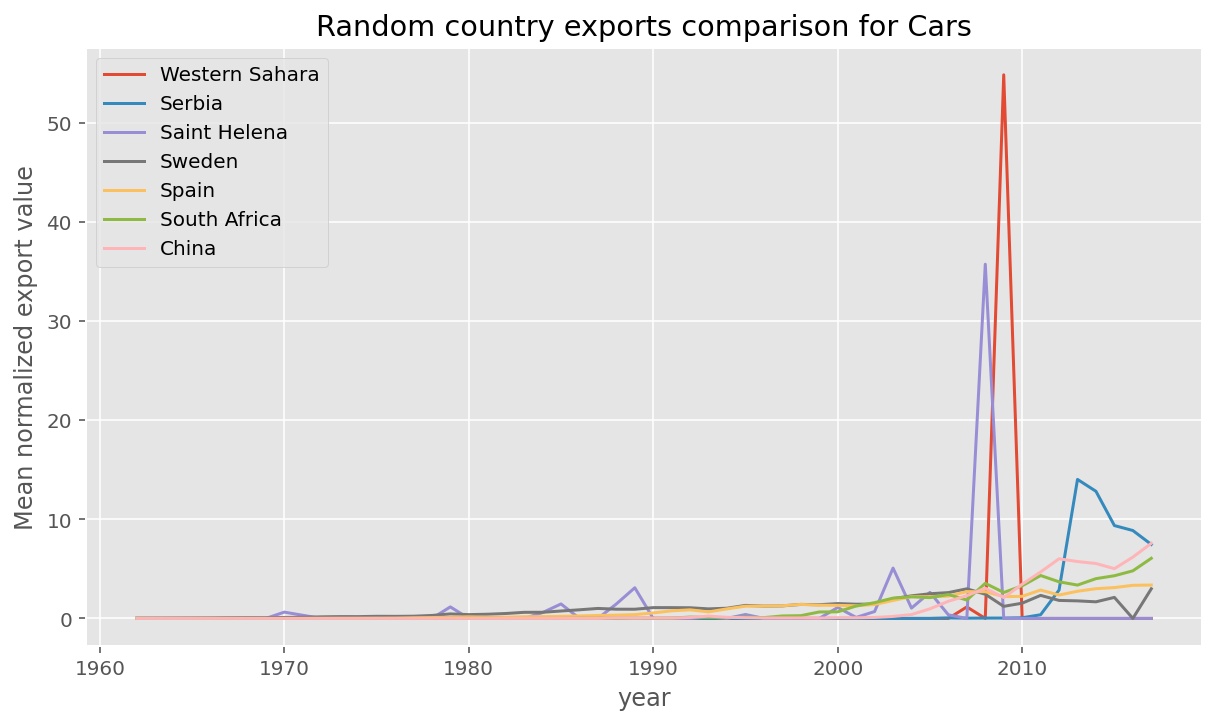

Some random countries have no data, a fixed list will be plotted


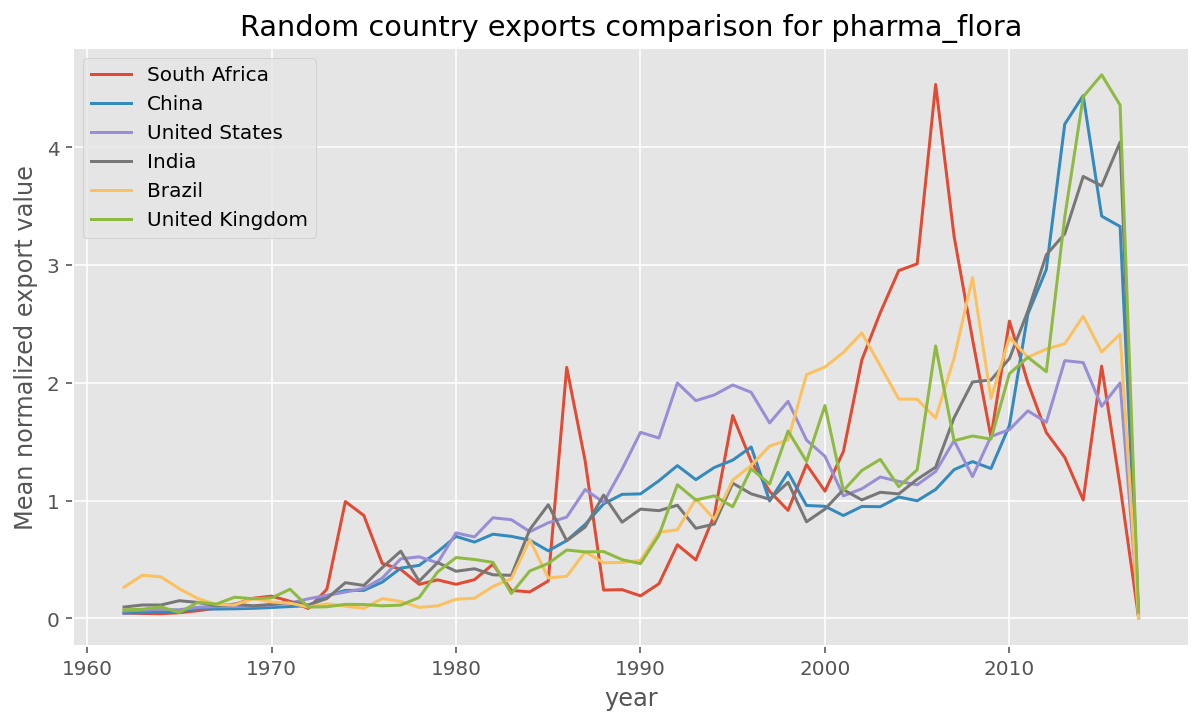

Some random countries have no data, a fixed list will be plotted


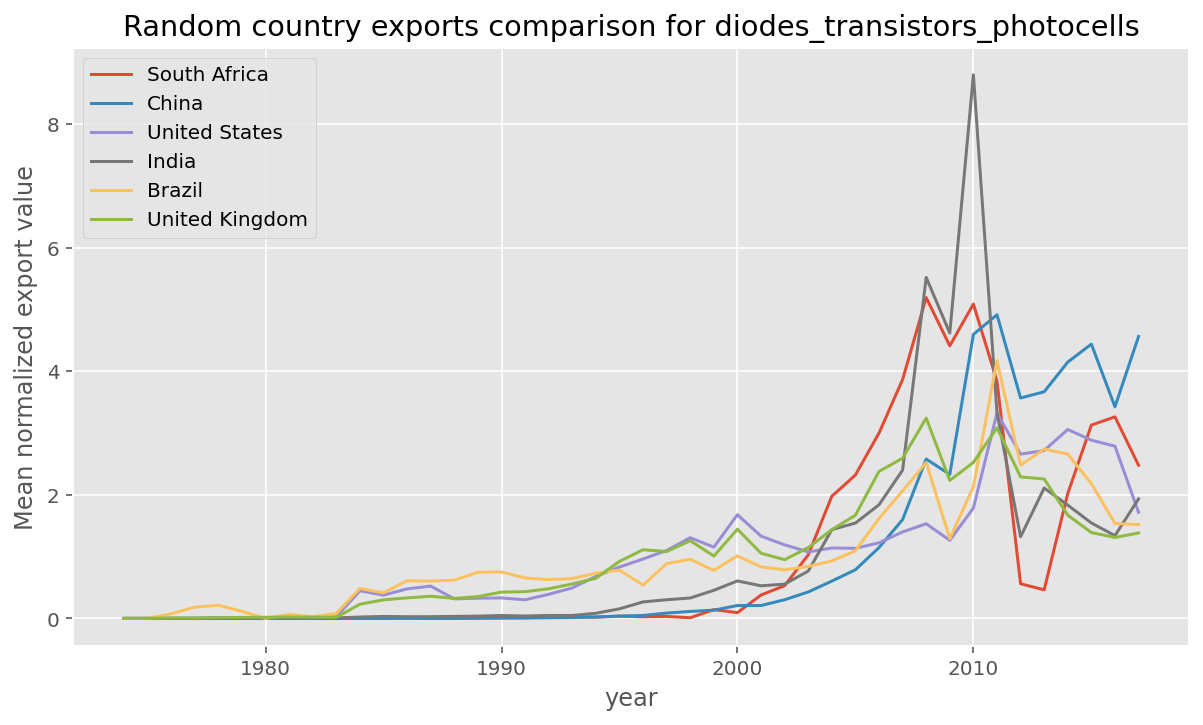

Some random countries have no data, a fixed list will be plotted


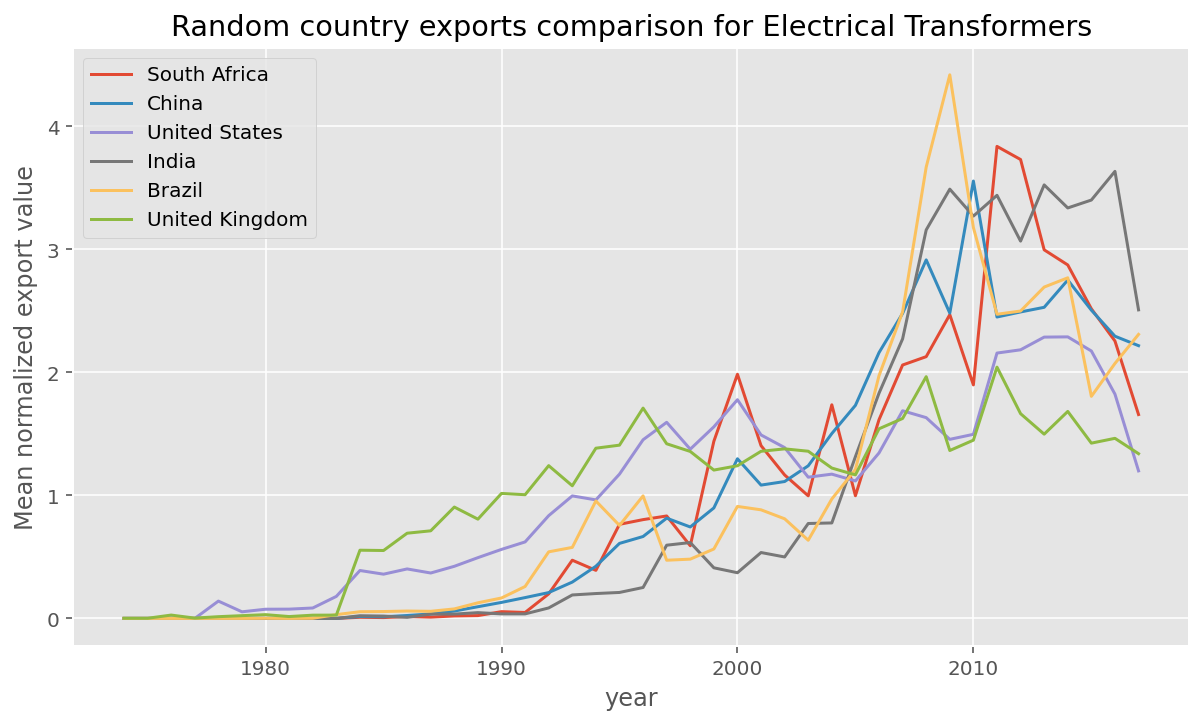

Some random countries have no data, a fixed list will be plotted


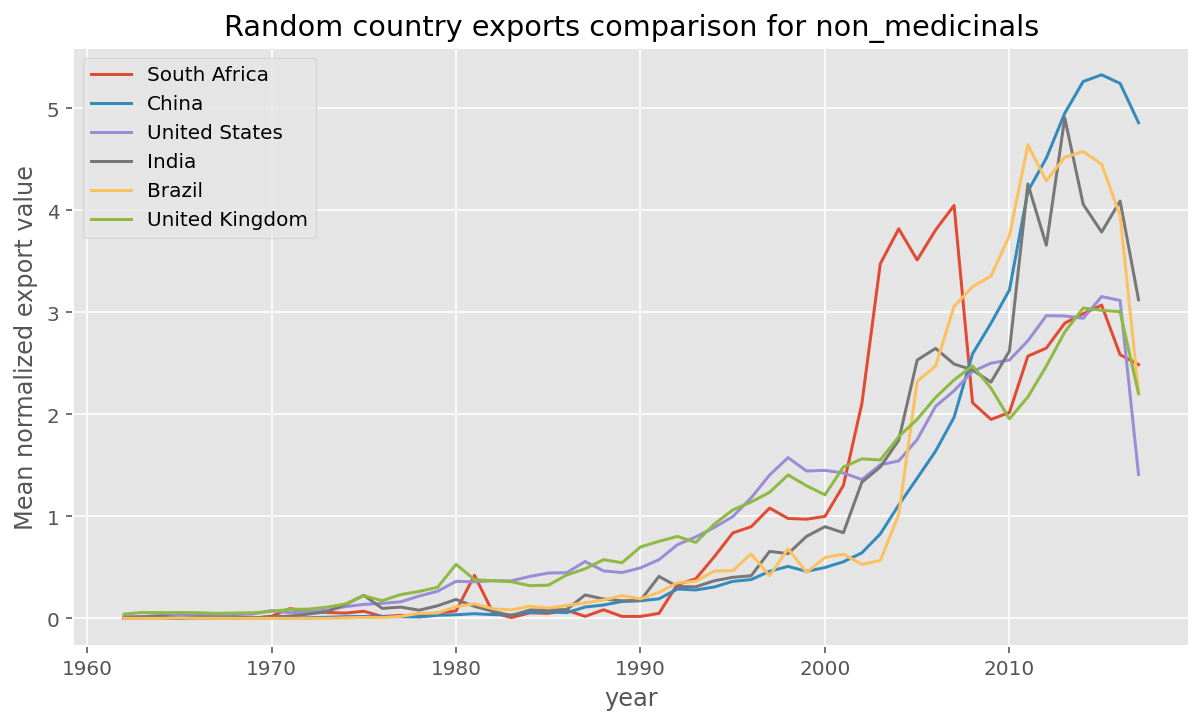

Some random countries have no data, a fixed list will be plotted


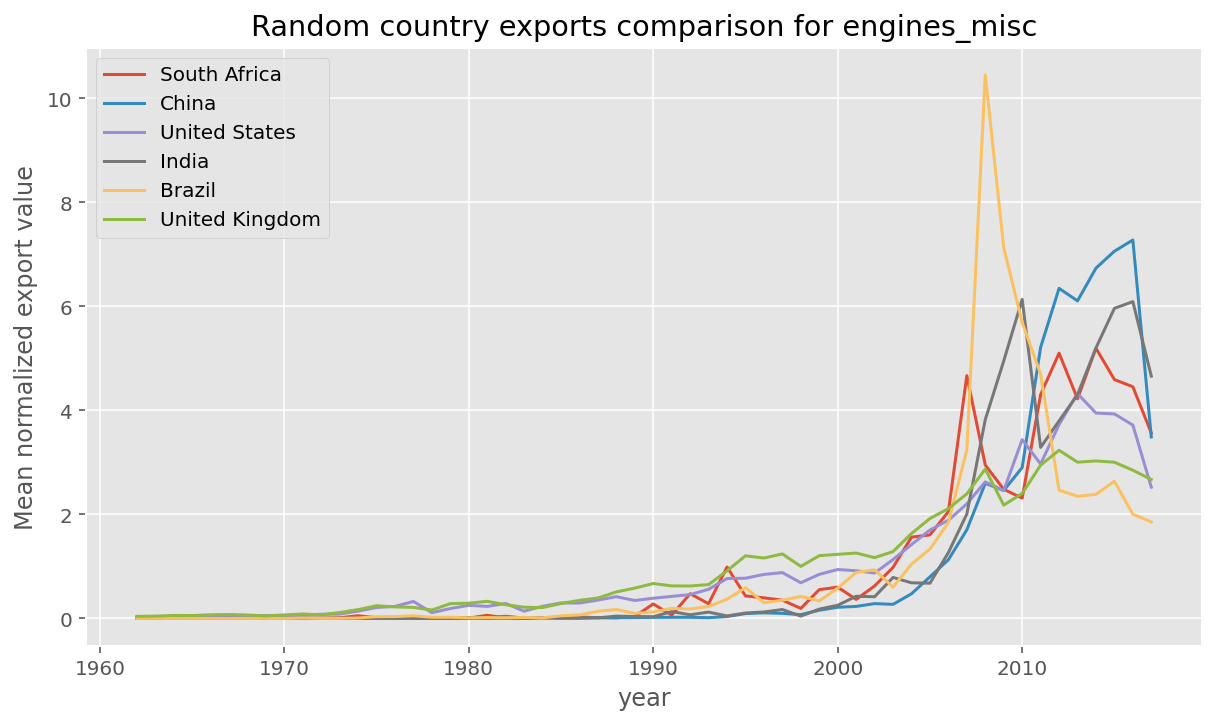

In [61]:
fixed_random_list = ["South Africa","China","United States","India","Brazil","United Kingdom"]
for id in trade_dframe.product_name.unique():
  product = pd.pivot_table(trade_dframe[trade_dframe.product_name==id], 
                           index='year', 
                           columns='country', 
                           values='export_val', 
                           aggfunc=np.mean)
  remove_null_values(product)
  
  mean_scaled_product = product.div(product.mean(axis=0),axis=1)
  mean_scaled_product.to_csv(f'{PATH}/mean_scaled_products/mean_scaled_{id}.csv')
  try:
    product_by_countries = mean_scaled_product[random_countries]
  except:
    print("Some random countries have no data, a fixed list will be plotted")
    product_by_countries = mean_scaled_product.loc[:,fixed_random_list]
  product_by_countries.plot(subplots=False,figsize=(10,5.5),title=(f'Random country exports comparison for {id}'))
  plt.ylabel("Mean normalized export value")
  plt.legend(product_by_countries.columns)
  plt.savefig(f"{PATH}/images/{id}_normalized")
  plt.show()

# Extract comprehensive features

### Packages for feature extraction

In [0]:
!pip install -q tsfresh 
import os
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

from tsfresh import extract_features, select_features
from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor,DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

import tsfresh
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

### Extract features

In [63]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def extract_product_features(df,fc_parameter,destination):
  features_product = []
  extraction_method = fc_parameter.__class__.__name__
  for p in df.sitc_id.unique():
    product = df[df.sitc_id==p]
    p_features = extract_features(product[["export_val","year","country"]],
                                  column_id="country",
                                  column_sort="year",
                                  column_value=None,column_kind=None,
                                  chunksize=None,
                                  default_fc_parameters=fc_parameter)
    features_product.append(p_features)
    p_features.to_csv(f"{p}_{extraction_method}_expval.csv")
    print(f'Extracted features for {p}: \n {features_product}')
  product_features = pd.concat(features_product)
  return p_features

Found GPU at: /device:GPU:0


In [0]:
# %timeit
# destination_1 =f'{PATH}/efficient_parameters'
# destination_2 = f'{PATH}/comprehensive_parameters'
# fc_parameters=[EfficientFCParameters(),ComprehensiveFCParameters()]
# extract_product_features(trade_dframe,fc_parameters[0],destination_1)
# extract_product_features(trade_dframe,fc_parameters[1],destination_2)

# Clustering raw time series

## Packages for clustering 

In [0]:
!pip install -q dtw-python
# dynamic time warping
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.metrics.cluster import homogeneity_score
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, SpectralClustering,DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

## Functions for clustering

In [0]:
# Functions for dendrograms
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model,type_of_data, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,5.5))
    dendrogram(linkage_matrix, **kwargs)
    plt.savefig(f"Dendrogram_{type_of_data}")
    return linkage_matrix

# Functions for dtw
def get_dtw_diff_matrix(df,cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df[col1]
        series2 = df[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

def plot_dtw(df,series1:str, series2:str) -> None:
  dtw_df = dtw(df[series1],\
            df[series2],\
            keep_internals=True,
            step_pattern=rabinerJuangStepPattern(2, "c"))
  plt.figure(figsize=(10,5.5))
  dtw_df.plot(type="twoway",offset=5)
  plt.set_title=(f'{series1} and {series2}')
  plt.savefig(f"DTW_{series1}_{series1}")
  plt.show()

def plot_elbow_silhoutte_k_evaluation(name_of_data: str,data_array,max_clusters):
  range_n_clusters = range(2,max_clusters)
  elbow = []
  s_score = []
  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters, random_state=42,init='k-means++',max_iter=1000,n_init=1)
    cluster_labels = clusterer.fit_predict(data_array)
    # Average silhouette score
    silhouette_avg = silhouette_score(data_array, cluster_labels)
    s_score.append(silhouette_avg)
    # Average SSE"
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
  fig = plt.figure(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=16)
  fig.add_subplot(121)
  plt.plot(range_n_clusters, elbow,'b-',label=f'{name_of_data} SSE')
  plt.xlabel("Number of cluster")
  plt.ylabel("Sum of squared error(SSE)")
  plt.legend()
  
  fig.add_subplot(122)
  # plt.title("Covid-19 Rt values silhouette method results")
  plt.plot(range_n_clusters, s_score,'b-',label=f'{name_of_data} \n Silhouette Score')
  plt.xlabel("Number of cluster")
  plt.ylabel("Silhouette Score")
  plt.legend()
  plt.show()

def plot_kmeans_clusters(data_array,number_of_clusters,name_of_data:str):
  # computing K-Means with K = number_of_clusters
  centroids,_ = kmeans(data_array,number_of_clusters)
  # assign each sample to a cluster
  idx,_ = vq(data_array,centroids)
  # some plotting using numpy's logical indexing
  fig, ax = plt.subplots(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=12)
  for cluster in range(number_of_clusters):
    colours = ['ob','ok','or','og','om','oc','oy']
    ax.plot(data_array[idx==cluster,0],data_array[idx==cluster,1],colours[cluster],label=f'cluster {cluster}')
    plt.legend()
  plt.savefig(f"{PATH}/images/k_means_{name_of_data}")
  plt.show()
  return idx

## Load data

In [0]:
scaled_data_location = f'{PATH}/mean_scaled_products/'
files = os.listdir(scaled_data_location)
files[0]
yarn_fiber = pd.read_csv(f'{scaled_data_location}/{files[0]}',parse_dates=['year'],index_col='year')
remove_null_values(yarn_fiber)

## Hierarchical clustering on mean scaled time series

<Figure size 720x396 with 0 Axes>

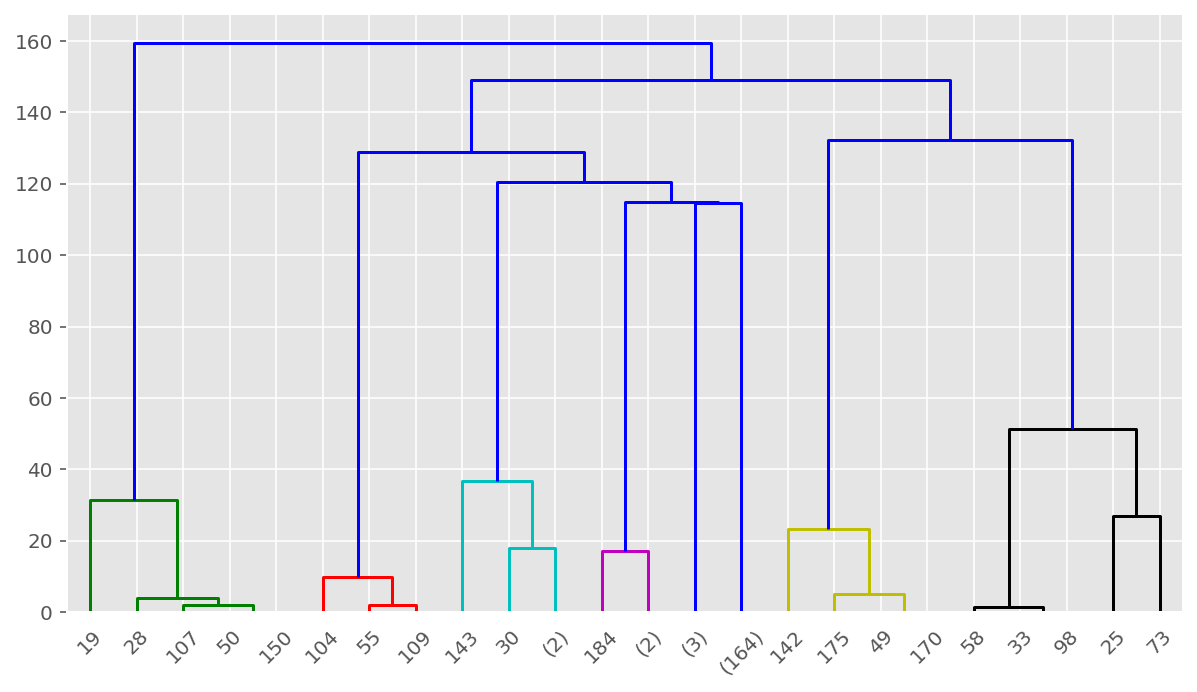

[ 9  5  6  1 11  3  7  8 10  2  4]


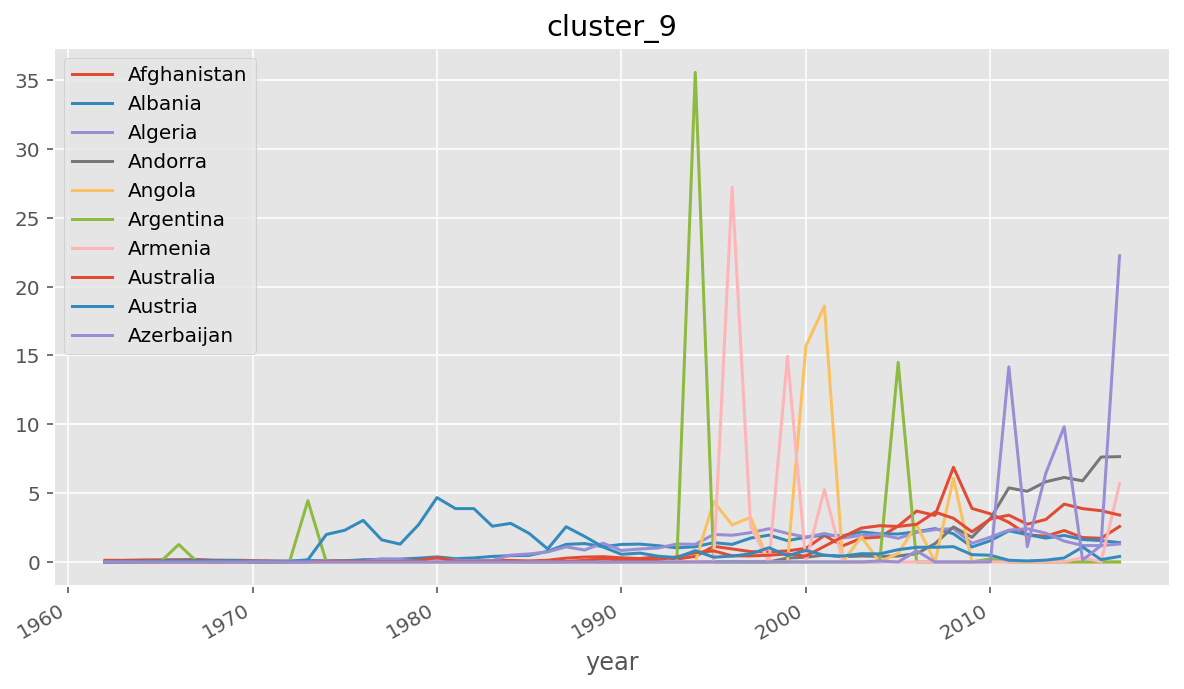

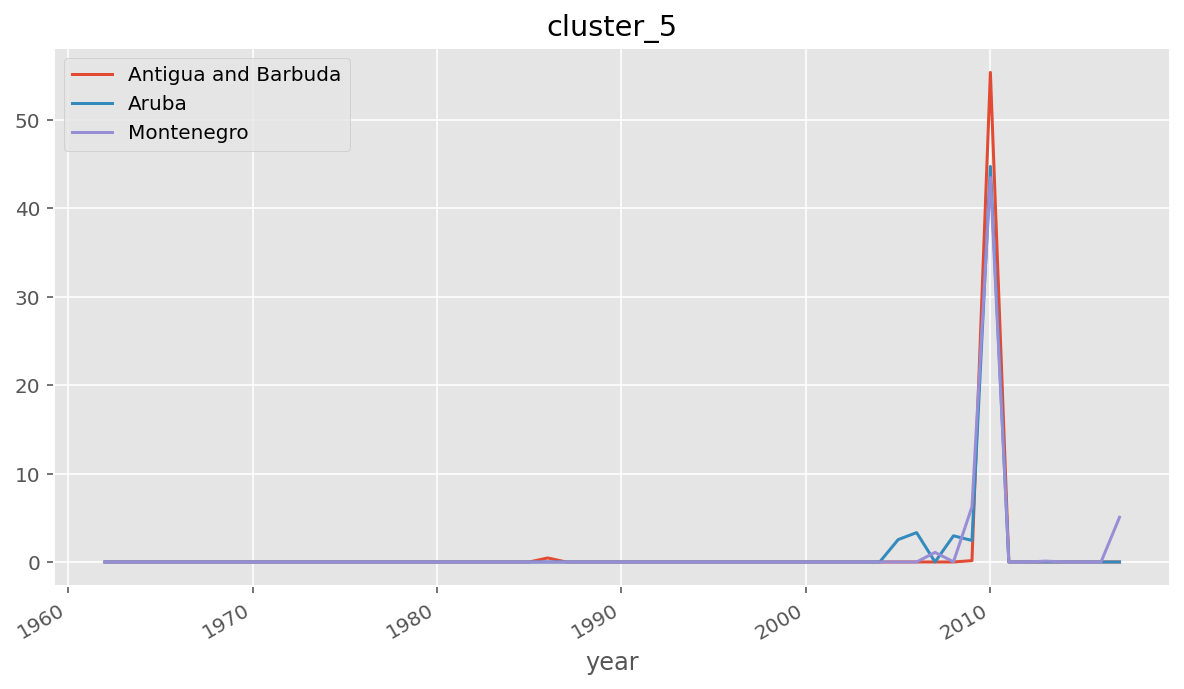

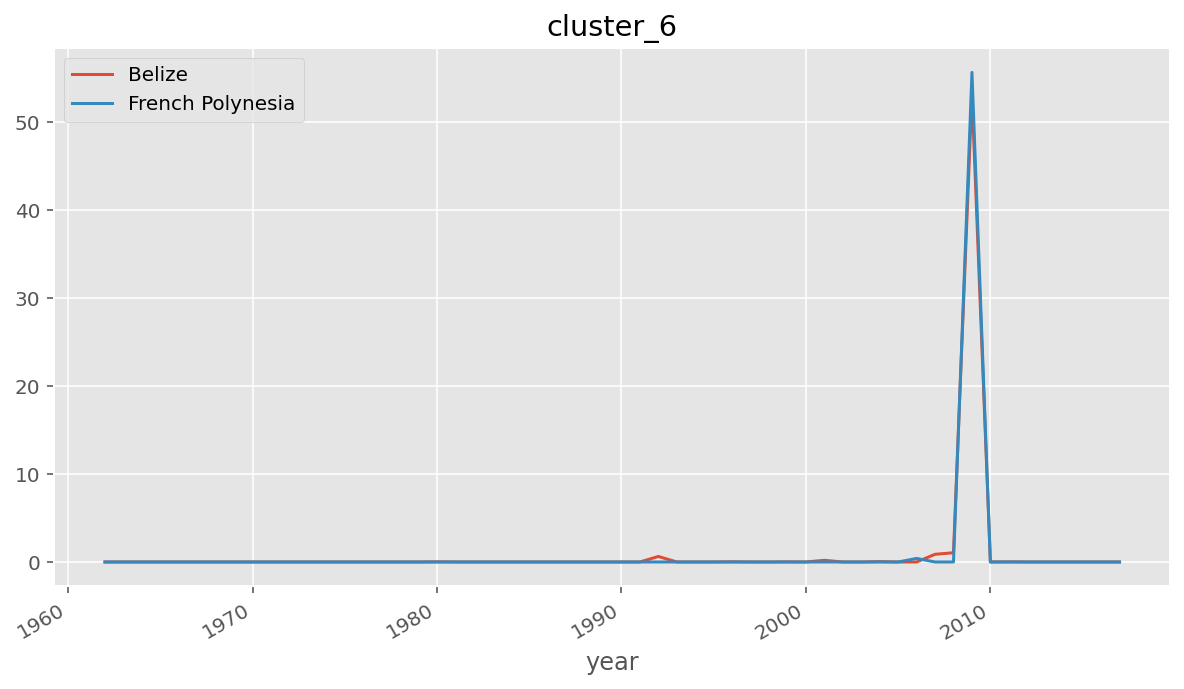

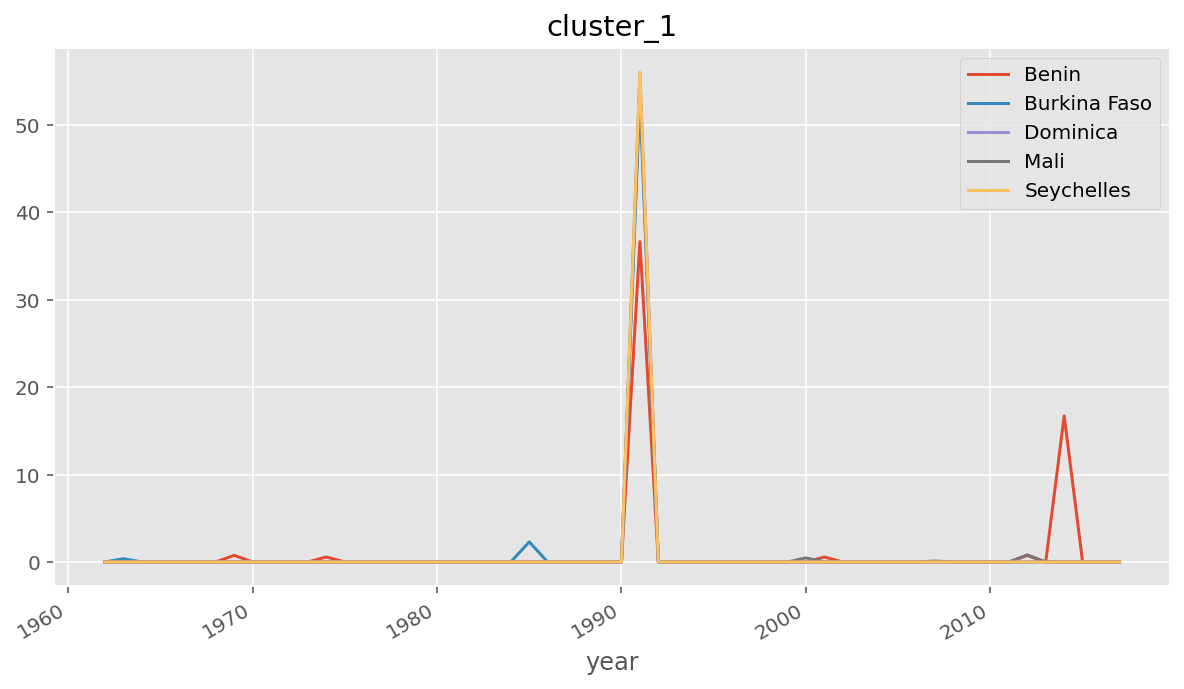

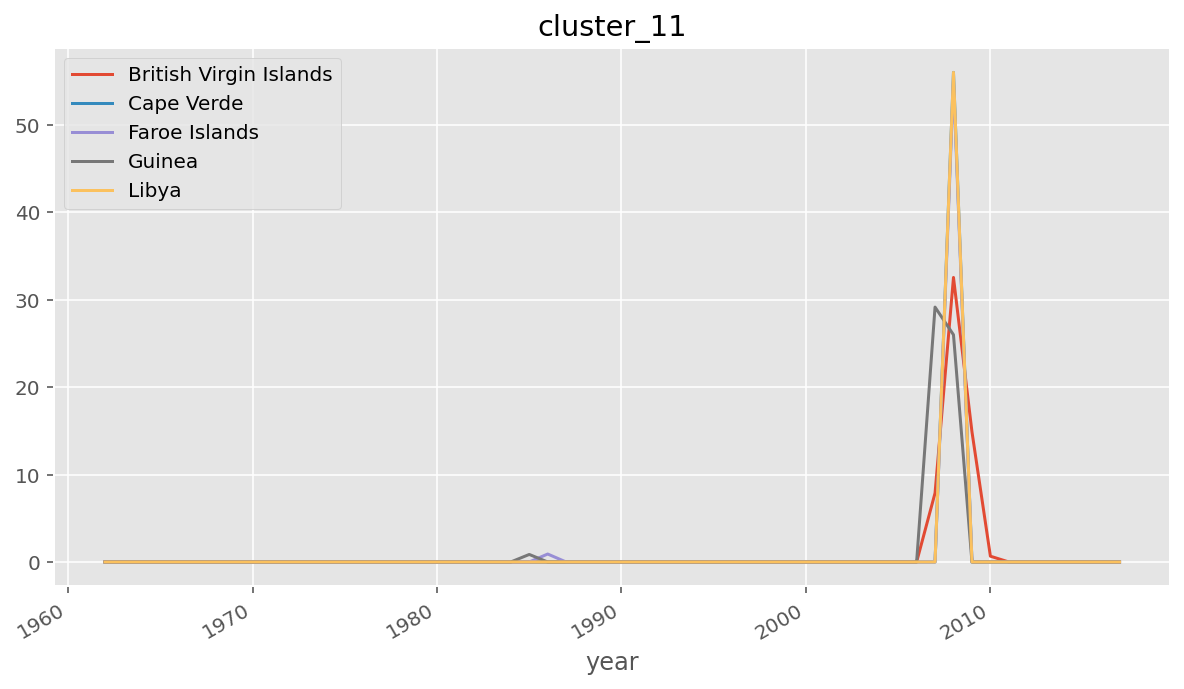

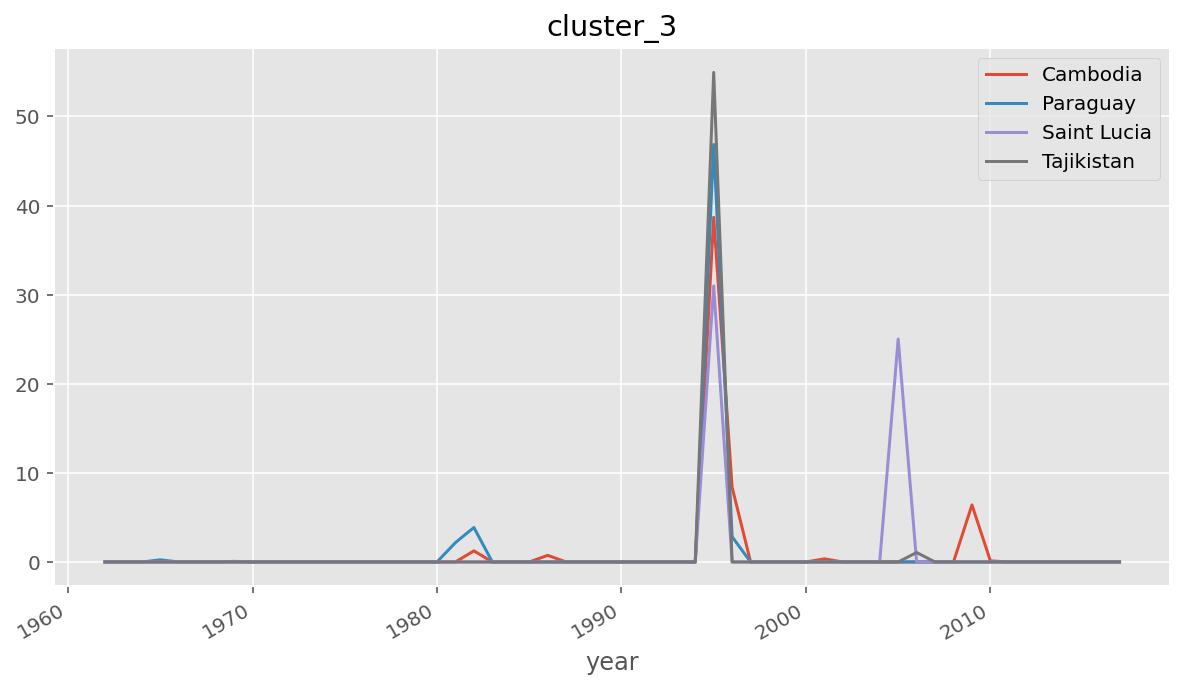

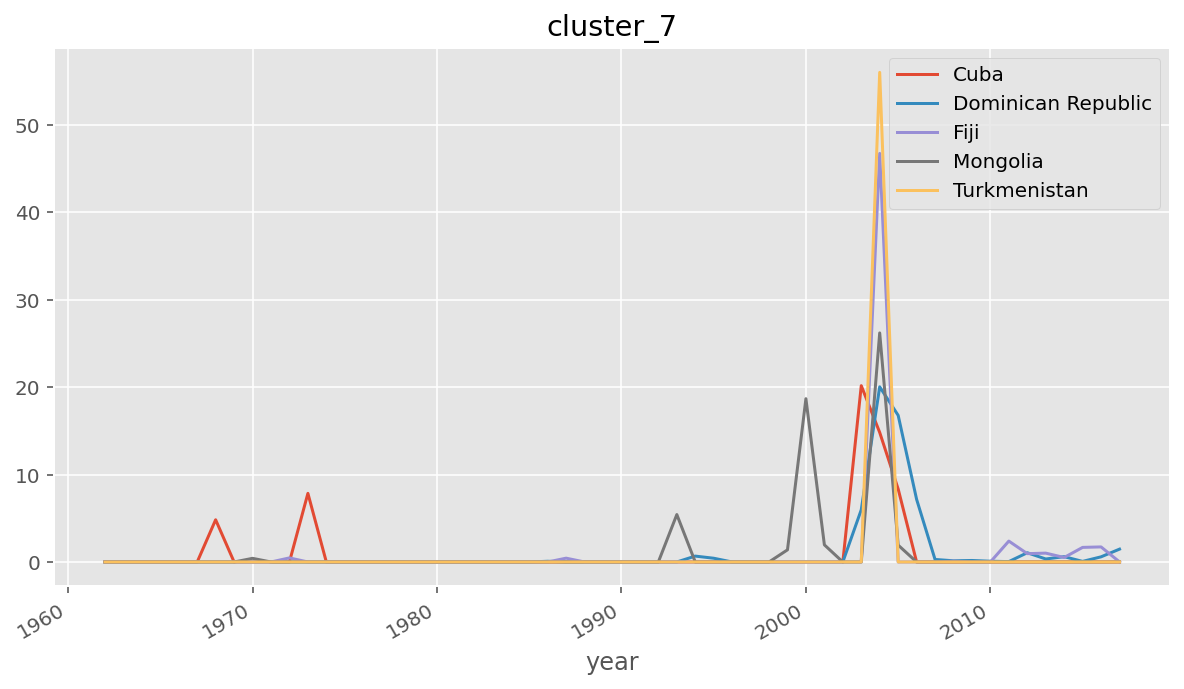

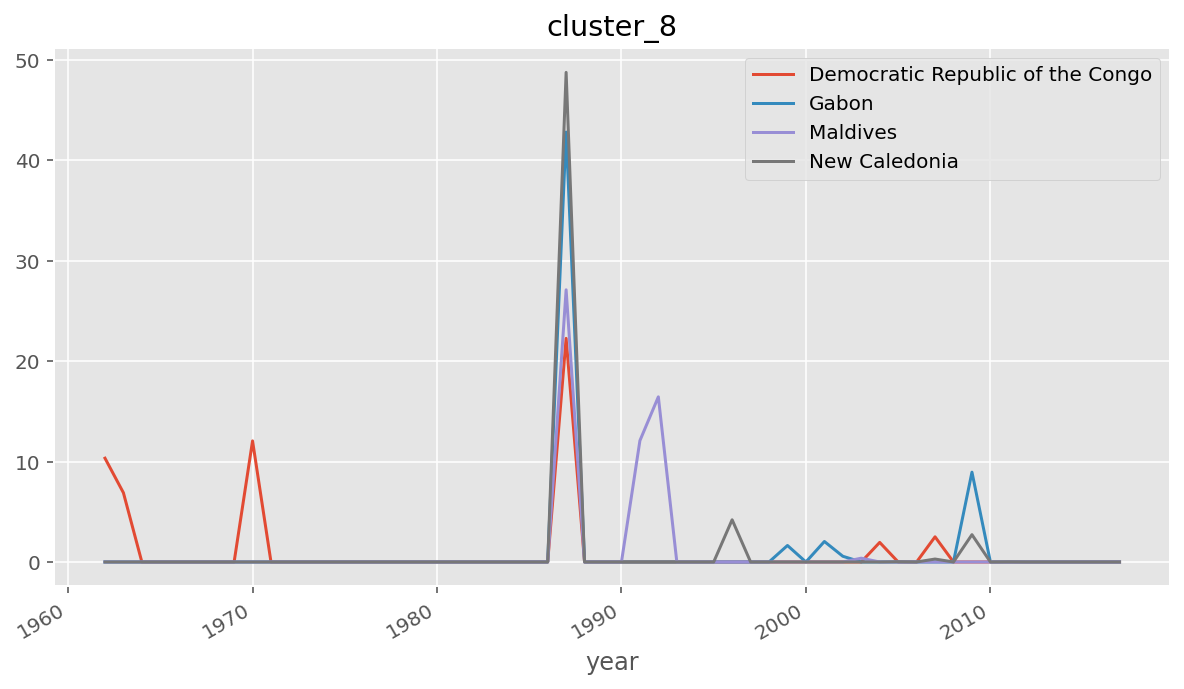

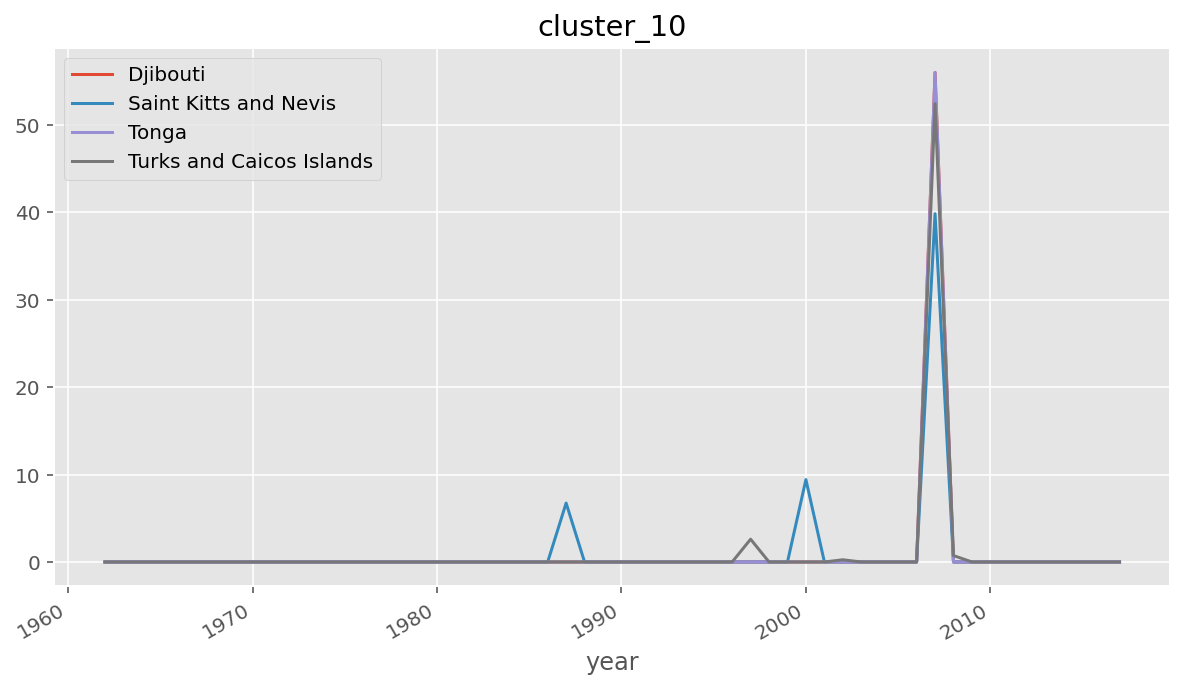

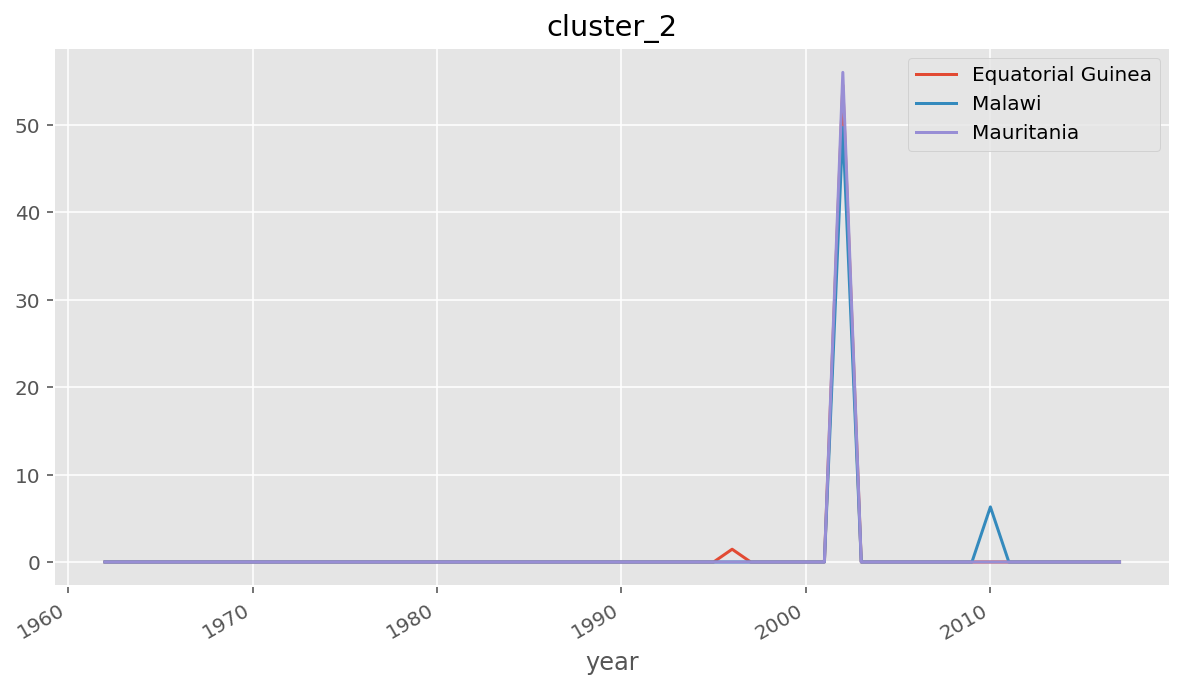

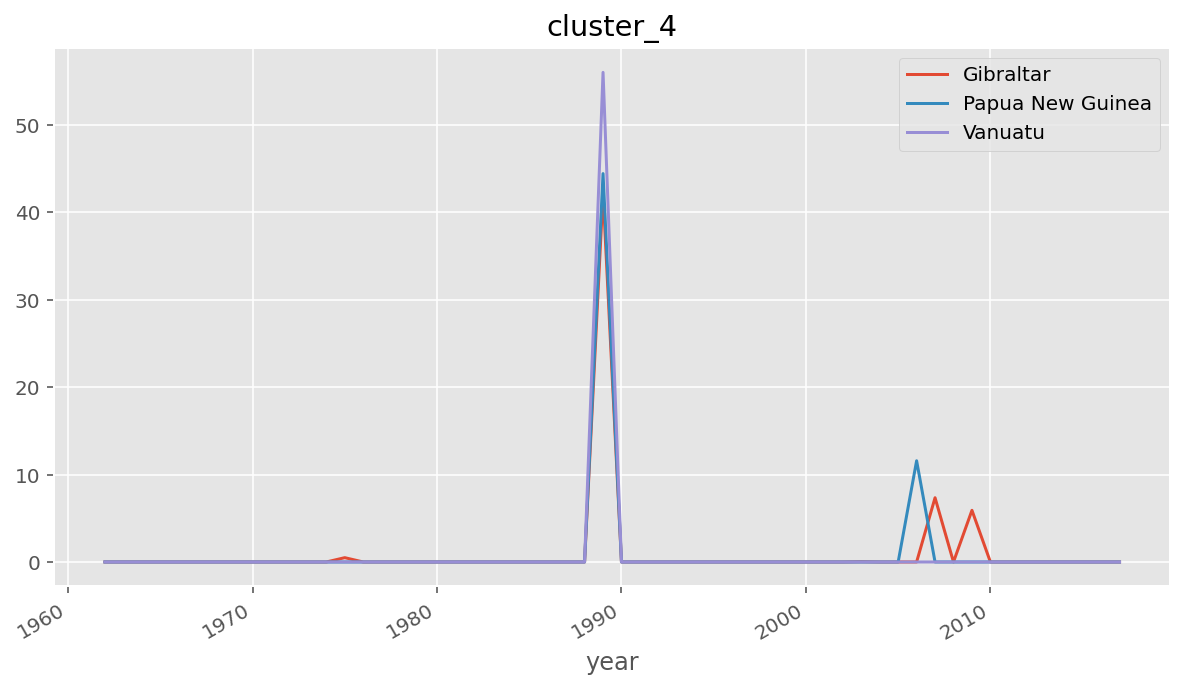

In [67]:
clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(yarn_fiber.T.values)

# plot the top five levels of the dendrogram
plt.figure(figsize = (10,5.5))
plt.title=('Raw data hierarchical Clustering Dendrogram')
linkage_matrix = plot_dendrogram(clf, "raw_data",p=5, color_threshold = 110,truncate_mode='level')
plt.savefig("raw_data_hierarchical")
plt.show()
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = yarn_fiber.T.reset_index()
yarn_fiber_clusters["cluster"] = clusters
yarn_fiber_clusters.rename(columns={'index':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
    .sort_index()

# cluster analysis
clusters = yarn_fiber_clusters.cluster.unique()
print(clusters)
for c in clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  # random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=False,figsize = (10,5.5),title=f"cluster_{c}")
  plt.legend(countries)
  # plt.savefig(f"{PATH}/images/raw_data_cluster{c}")
  plt.show()

## Dynamic time warping clustering

In [0]:
# # These two series look similar but are misaligned, it wouldn't be easily visble to the human eye
# yarn_fiber[['India','Turkey']].plot(title= "Example export value comparison",figsize=(15,4))

# ## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
# plt.figure(figsize=(10,5.5))
# dtw_data = dtw(yarn_fiber['India'],yarn_fiber['Turkey'],
#                keep_internals=True,step_pattern=rabinerJuangStepPattern(3, "c"))
# dtw_data.plot(type="twoway",offset=5)

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1450: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_yticks(self.tick_pos)


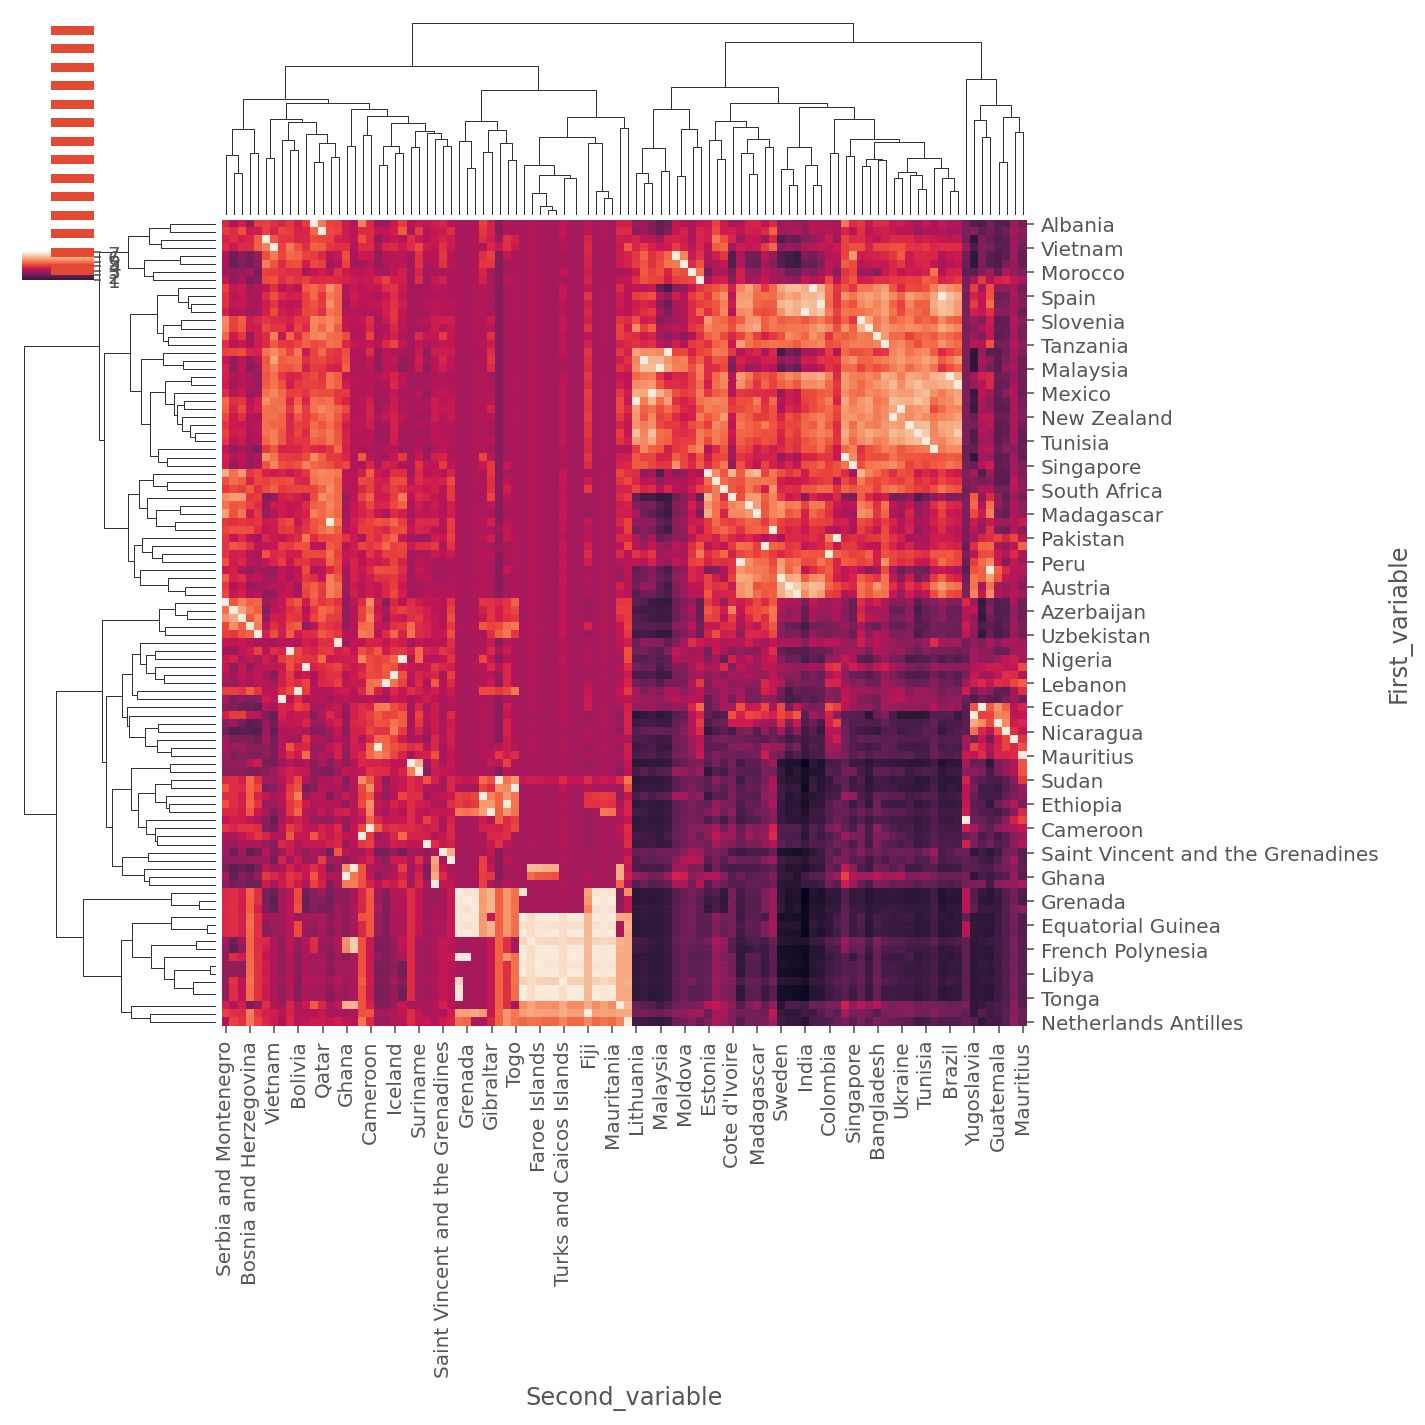

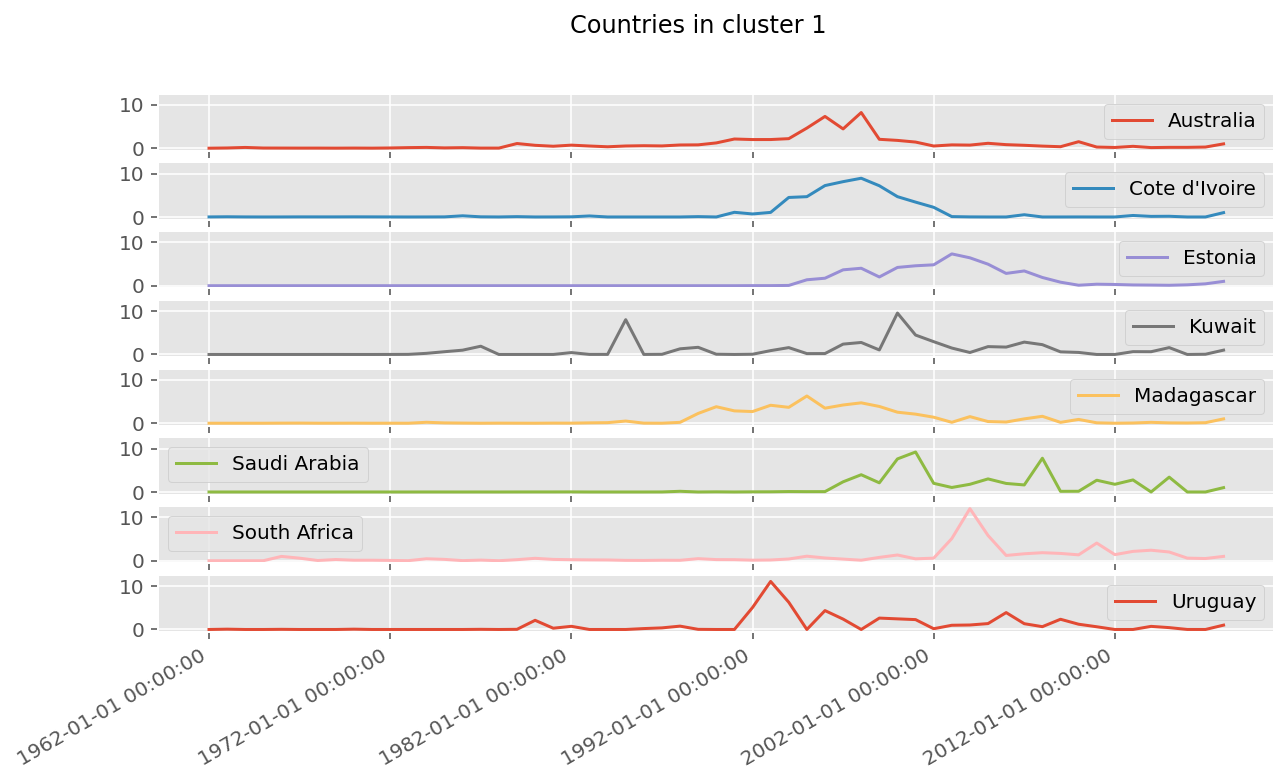

DTW for Turkey and India


<Figure size 720x396 with 0 Axes>

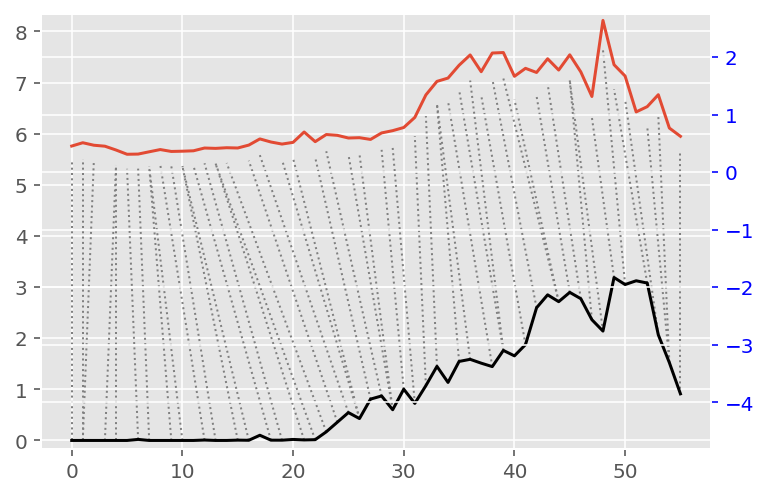

<Figure size 432x288 with 0 Axes>

DTW for Rwanda and Montenegro


<Figure size 720x396 with 0 Axes>

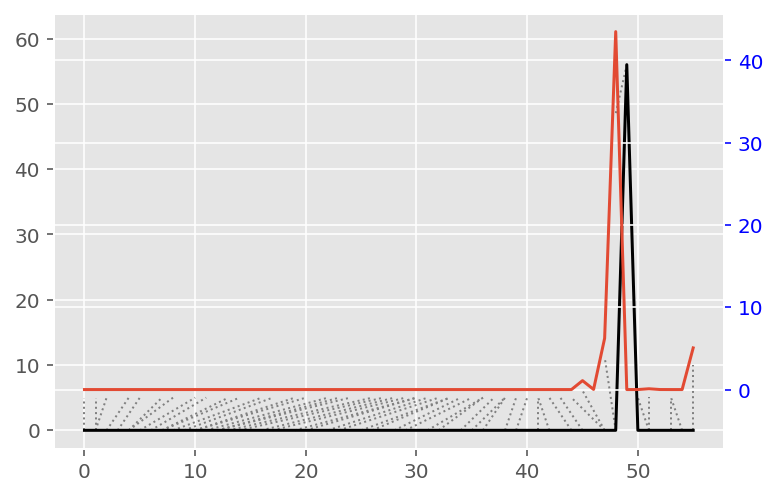

<Figure size 432x288 with 0 Axes>

DTW for Niger and Republic of the Congo


<Figure size 720x396 with 0 Axes>

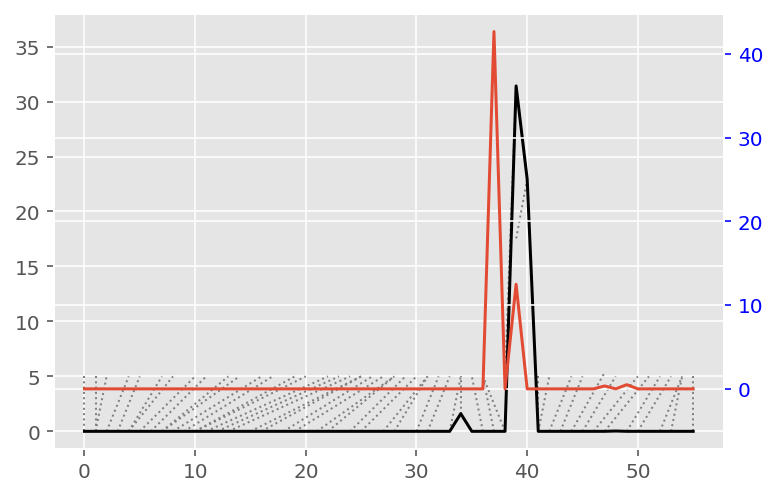

<Figure size 432x288 with 0 Axes>

In [69]:
# sample 50 series, and compute the DTW distance matrix
random.seed(10)
sample_cols = random.sample(list(yarn_fiber.columns), 100)
dtw_diff_dict = get_dtw_diff_matrix(yarn_fiber,sample_cols)

# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"First_variable", "level_1":"Second_variable", 0:"diff"})\
    .pivot_table(index = "First_variable", columns = "Second_variable", values = "diff")

# plot a similarity matrix, with a dendogram imposed
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
time_warp = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(time_warp, 1.15)}, index = dtw_diff_df.index)
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title=("Frequency of DTW clusters")

# Check time series for any cluster
# TODO: Function to loop through all clusters and plot
# What cluster is South Africa? 
#print(dtw_clusters[dtw_clusters.index=='South Africa'])
cluster = 1
yarn_hc_clusters = yarn_fiber.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster ==cluster], 
    left_index = True,
    right_index = True)\
    .T
yarn_hc_clusters.plot(subplots=True,figsize = (10,5.5),sharey=True,title=f'Countries in cluster {cluster}')
plt.show()

print('DTW for Turkey and India')
plot_dtw(yarn_fiber,"Turkey", "India")

print('DTW for Rwanda and Montenegro')
plot_dtw(yarn_fiber,"Rwanda", "Montenegro")

print('DTW for Niger and Republic of the Congo')
plot_dtw(yarn_fiber,"Niger", "Republic of the Congo")

# Clustering for minimum extracted features

## Data and EDA

In [0]:
path_to_min_features = f'{PATH}/min_feats_ts'
path_to_parameter_eff_features = f'{PATH}/efficient_parameters'
path_to_parameter_comp_features = f'{PATH}/comprehensive_parameters'
min_feats = os.listdir(path_to_min_features)
yarn_fiber_min_feats = pd.read_csv(f'{path_to_min_features}/{min_feats[0]}',index_col='id')
remove_null_values(yarn_fiber_min_feats)

# Exclude highly correlated features
exclude = [
          #  'export_val__kurtosis',
           'export_val__variance',
          #  'export_val__mean',
           'export_val__skewness',
          #  'export_val__standard_deviation',
          #  'export_val__median',
           'export_val__sum_values',
           'export_val__maximum',
          #  'export_val__minimum',
           'export_val__length'
           ]
min_feats_yarn = yarn_fiber_min_feats[yarn_fiber_min_feats.columns[
                                                                   ~yarn_fiber_min_feats.columns.isin(exclude)]]

                          columns Outliers
0            export_val__kurtosis        0
1                export_val__mean       52
2              export_val__median       50
3             export_val__minimum       53
4  export_val__standard_deviation       47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


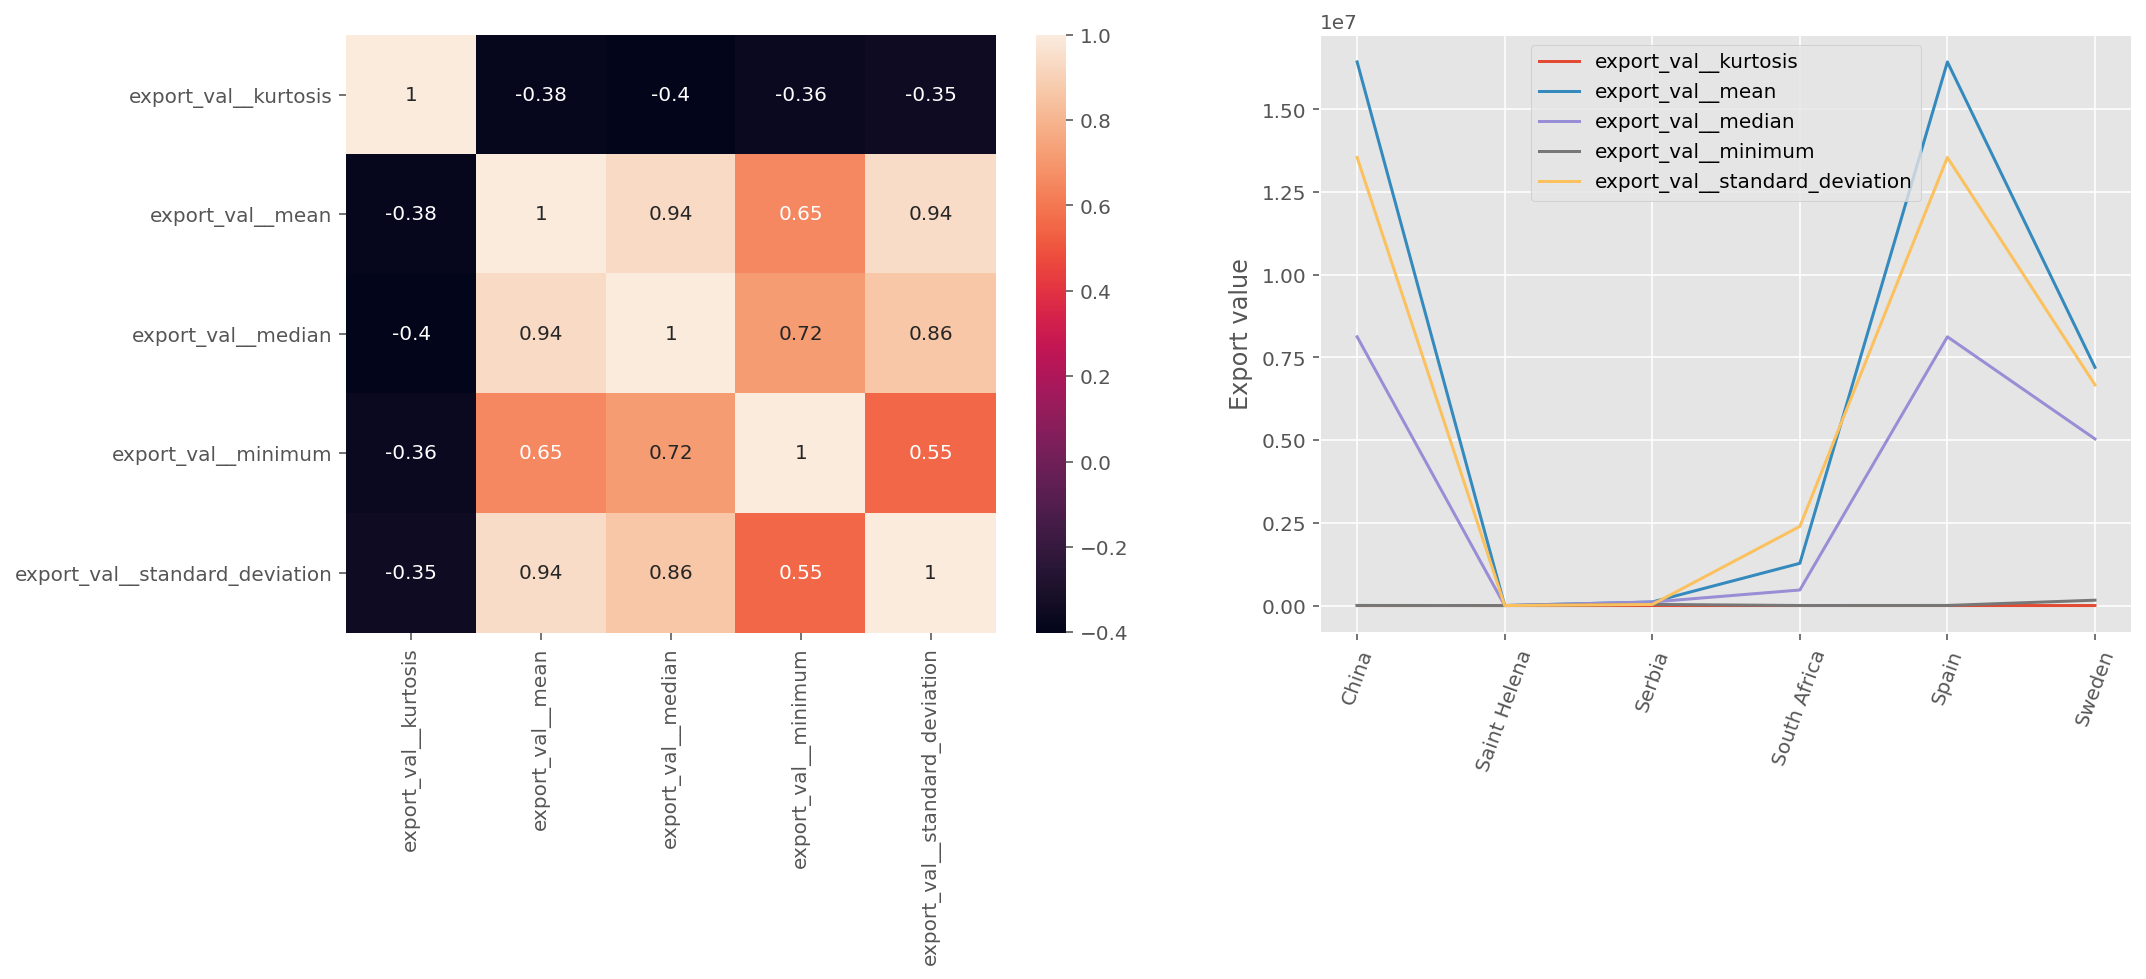

In [71]:
print(check_outliers(min_feats_yarn))
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
from scipy.stats.mstats import winsorize
scaler = StandardScaler()
yarn_fiber_min_feats = removing_outliers(min_feats_yarn)

min_feats_yarn = min_feats_yarn.div(min_feats_yarn.mean(axis=0),axis=1)
product_excl_countries = yarn_fiber_min_feats[yarn_fiber_min_feats.index.isin(random_countries)]
product_by_countries = min_feats_yarn[min_feats_yarn.index.isin(random_countries)]


fig = plt.figure(figsize=(16,5.5))
fig.add_subplot(121)
sns.heatmap(min_feats_yarn.corr(),annot=True)
# plt.title("Correlation between time series features")
plt.savefig(f"{PATH}/images/correlation_stats_features")

fig.add_subplot(122)
plt.plot(product_excl_countries,label="Here")
# plt.title("Yarn fiber features for randomly picked \n countries excluding outliers")
plt.xticks(rotation=70)
plt.ylabel("Export value")
plt.legend(product_excl_countries.columns)
plt.show()

scaled_yarn_min_feats = scaler.fit_transform(yarn_fiber_min_feats)

## Hierarchical clustering - minimum features

<Figure size 1008x432 with 0 Axes>

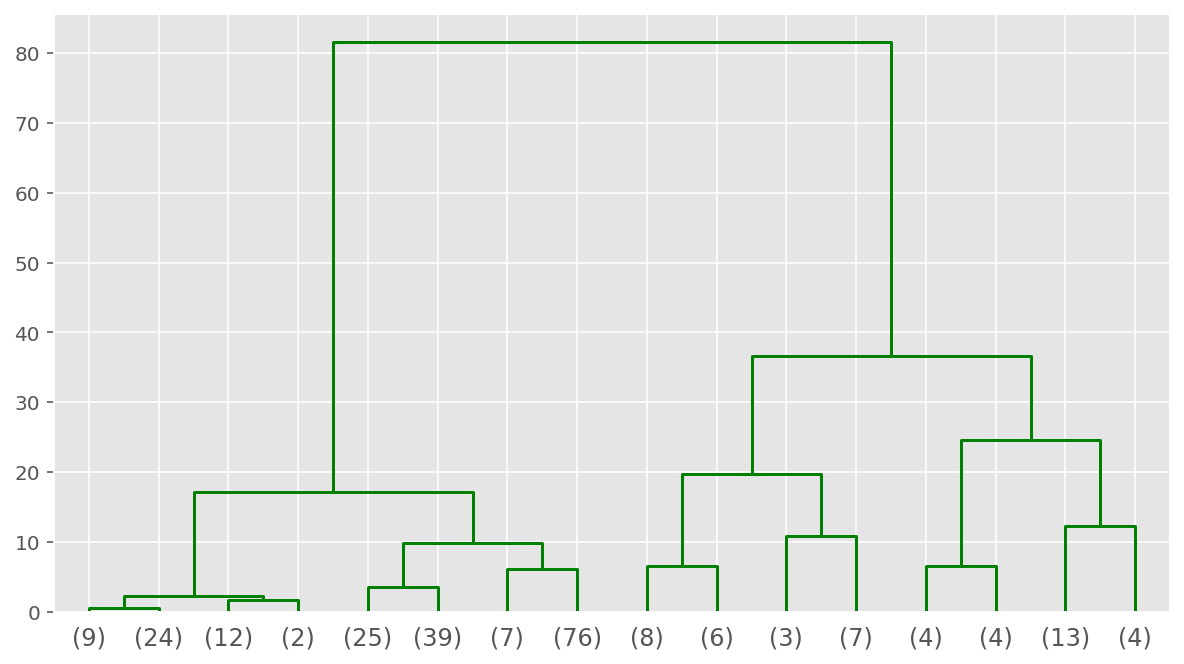

Unique clusters: [1]


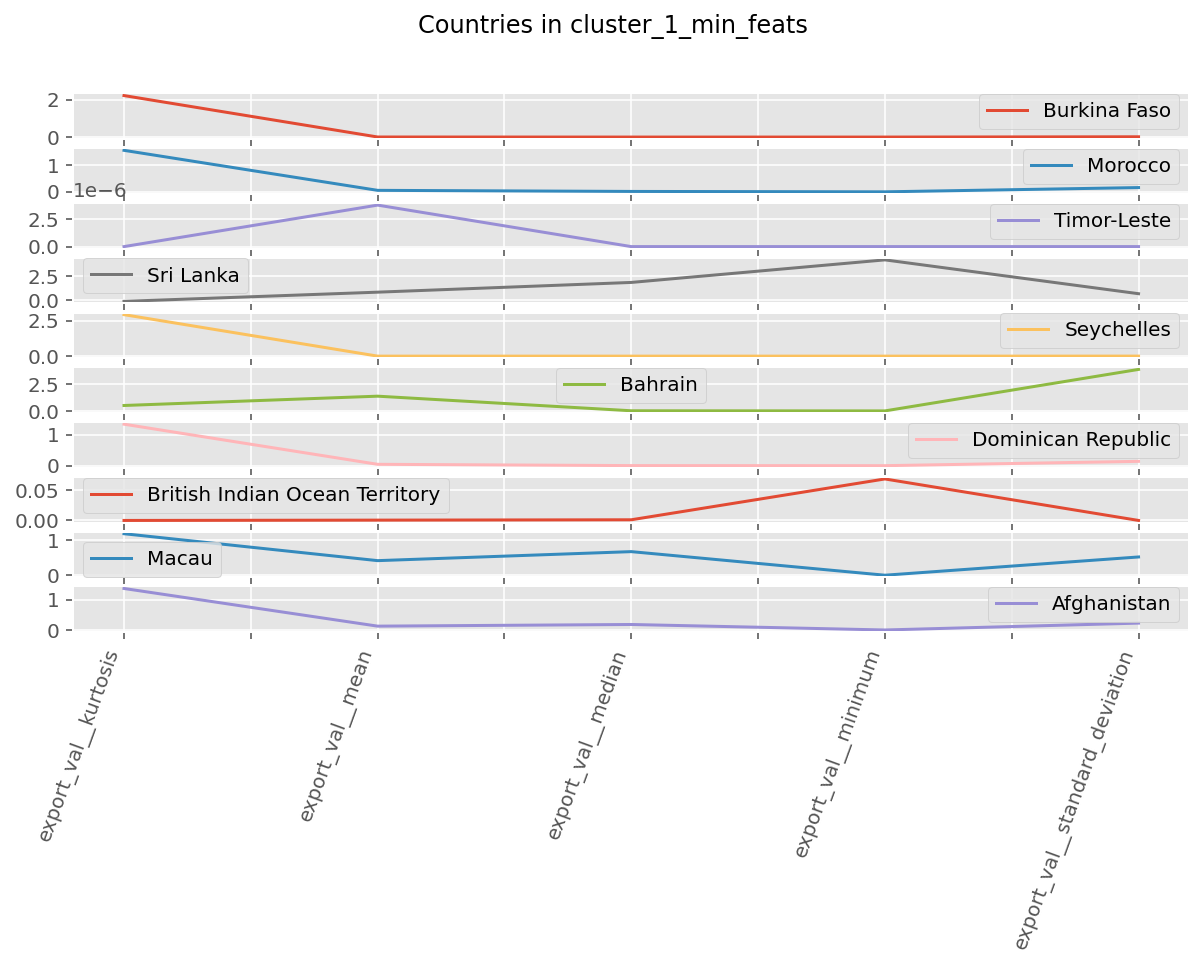

In [72]:
feats_clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(min_feats_yarn.values)

plt.figure(figsize = (14,6))
# plot the top five levels of the dendrogram
linkage_matrix = plot_dendrogram(feats_clf,"min_feats_raw", p=3,color_threshold = 110,truncate_mode='level')
plt.show()

# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = min_feats_yarn.reset_index()
yarn_fiber_clusters["cluster"] = clusters
clusts = yarn_fiber_clusters['cluster'].unique()
print(f'Unique clusters: {clusts}')
yarn_fiber_clusters.rename(columns={'id':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
.sort_index()


# cluster analysis
feats_clusters = yarn_fiber_clusters.cluster.unique()
for c in feats_clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=True,figsize=(10,5.5),
                          title=f"Countries in cluster_{c}_min_feats")
  plt.xticks(rotation=70)
  plt.legend(countries)
  plt.savefig(f"{PATH}/images/cluster_{c}_min_feats")
  plt.show()

## K-means clusetring

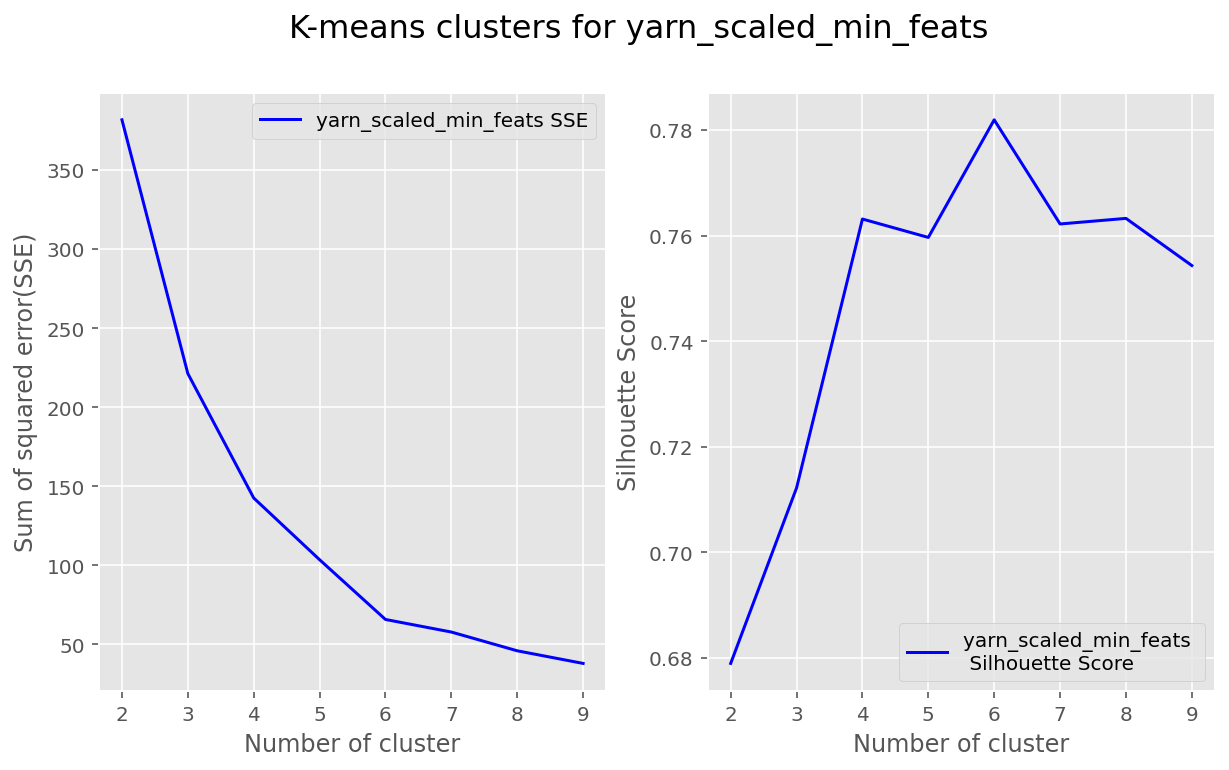

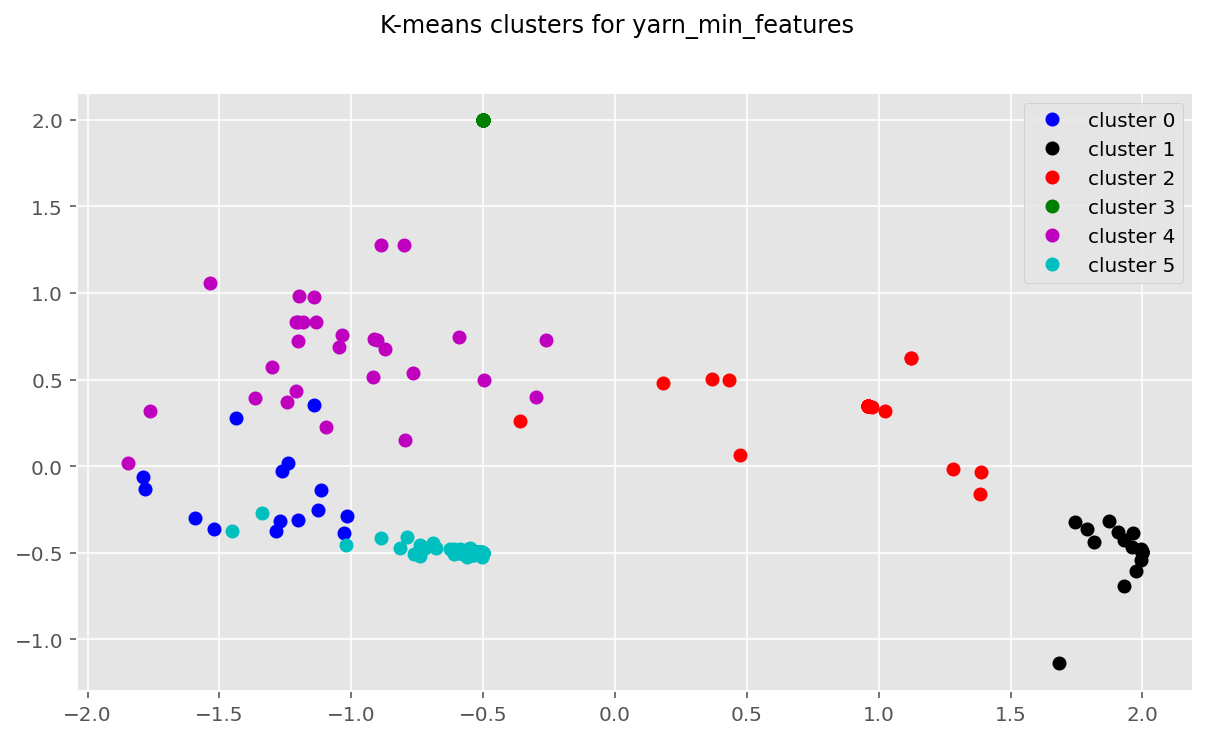

array(['American Samoa', 'Austria', 'Bangladesh', 'Belgium',
       'Belgium-Luxembourg', 'China Free Trade Zone (FTZ)',
       'Czech Republic', 'Estonia', 'Falkland Islands',
       'Federal Republic of Germany', 'France', 'Germany', 'Hungary',
       'India', 'Italy', 'Japan', 'Netherlands', 'Russia', 'Slovakia',
       'Tokelau', 'Ukraine', 'United Kingdom', 'United States'],
      dtype=object)

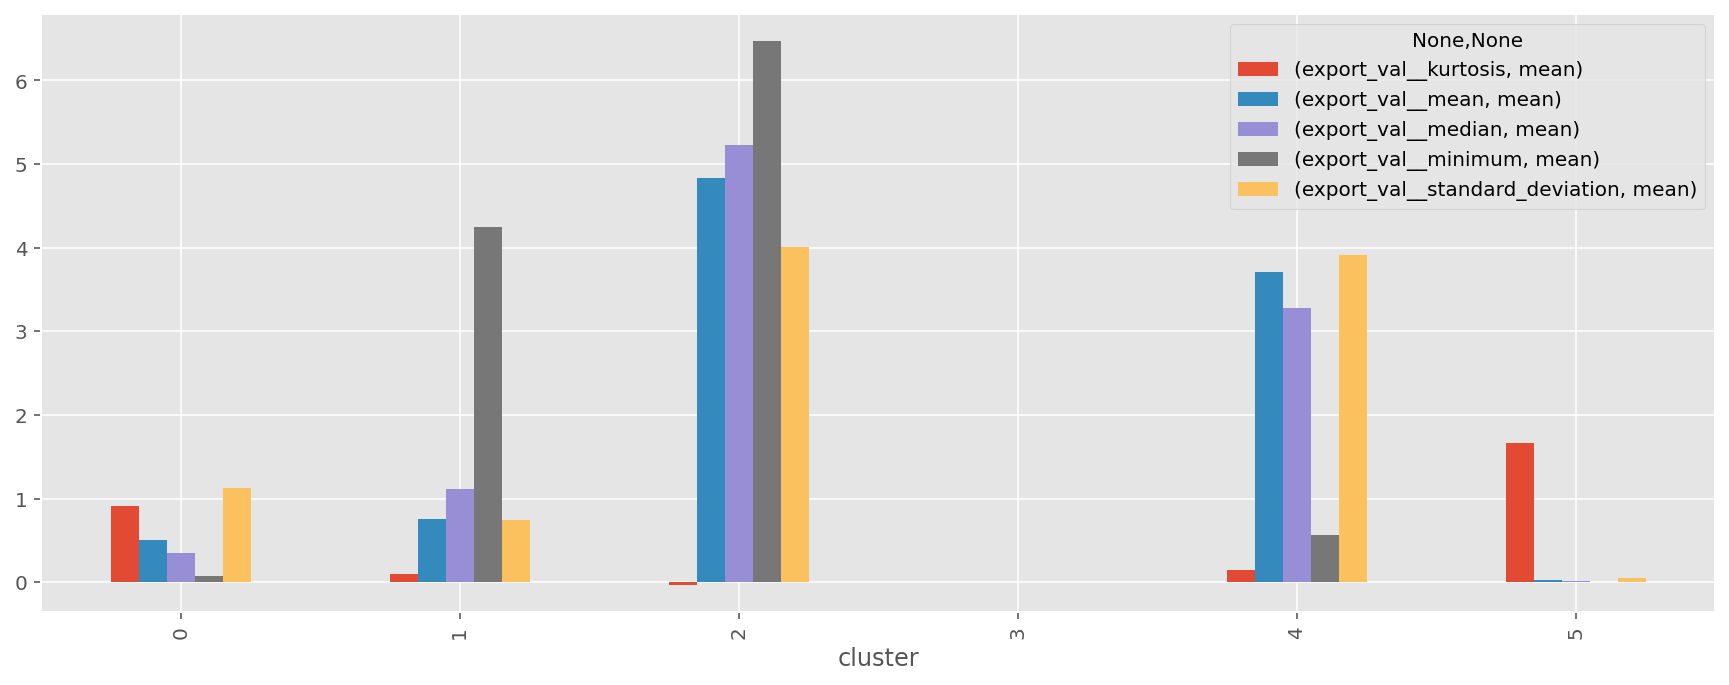

In [73]:
# TODO: create function that loops through list columns to be included in  
X_scaled_transposed = preprocessing.scale(
    np.asarray([
                np.asarray(min_feats_yarn['export_val__minimum']),
                np.asarray(min_feats_yarn['export_val__mean']),
                # np.asarray(min_feats_yarn['export_val__length']),
                # np.asarray(min_feats_yarn['export_val__skewness']),
                np.asarray(min_feats_yarn['export_val__kurtosis']),
                np.asarray(min_feats_yarn['export_val__median']),
                # np.asarray(min_feats_yarn['export_val__mean']),
                np.asarray(min_feats_yarn['export_val__standard_deviation']),
                # np.asarray(min_feats_yarn['export_val__variance'])
                ])).T

# X = data
plot_elbow_silhoutte_k_evaluation("yarn_scaled_min_feats",X_scaled_transposed,10)  
clusters_yarn_min_feats = plot_kmeans_clusters(X_scaled_transposed,6,"yarn_min_features") #TODO: seperate def get_clusters() \\ plot_kmeans_clusters()

#TODO: function for getting names from cluster
# def get_cluster_elements()
details = [(name,cluster) for name, cluster in zip(min_feats_yarn.index,clusters_yarn_min_feats)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = min_feats_yarn.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)
groups.plot(figsize=(15,5.5),kind='bar')
country_cluster[country_cluster.cluster==2]['names'].unique()

## PCA + Kmeans

 - First 2 components explain majority of variance

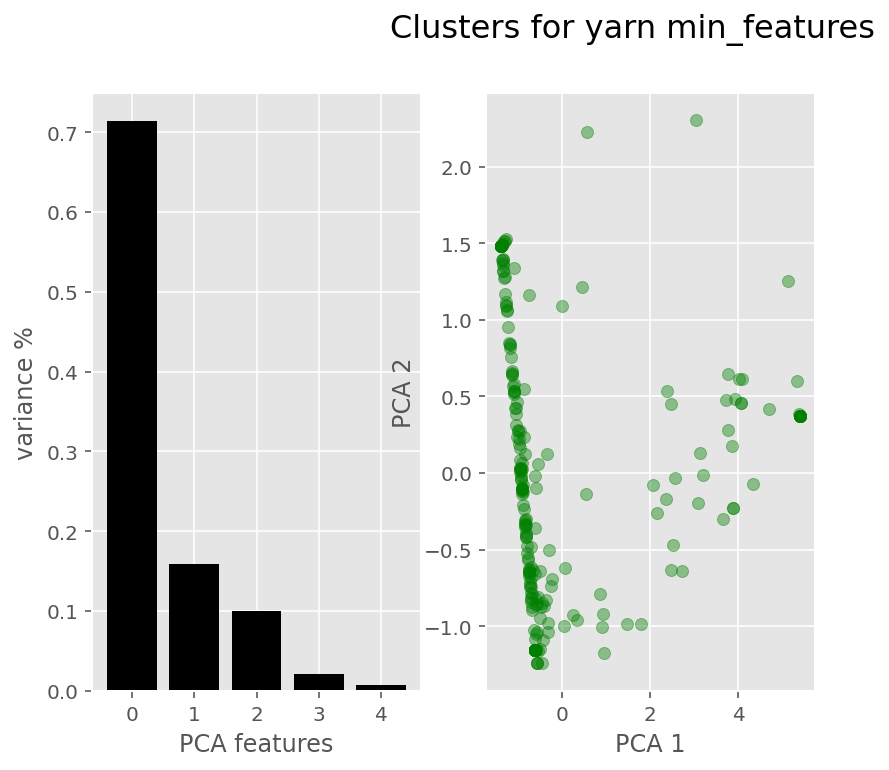

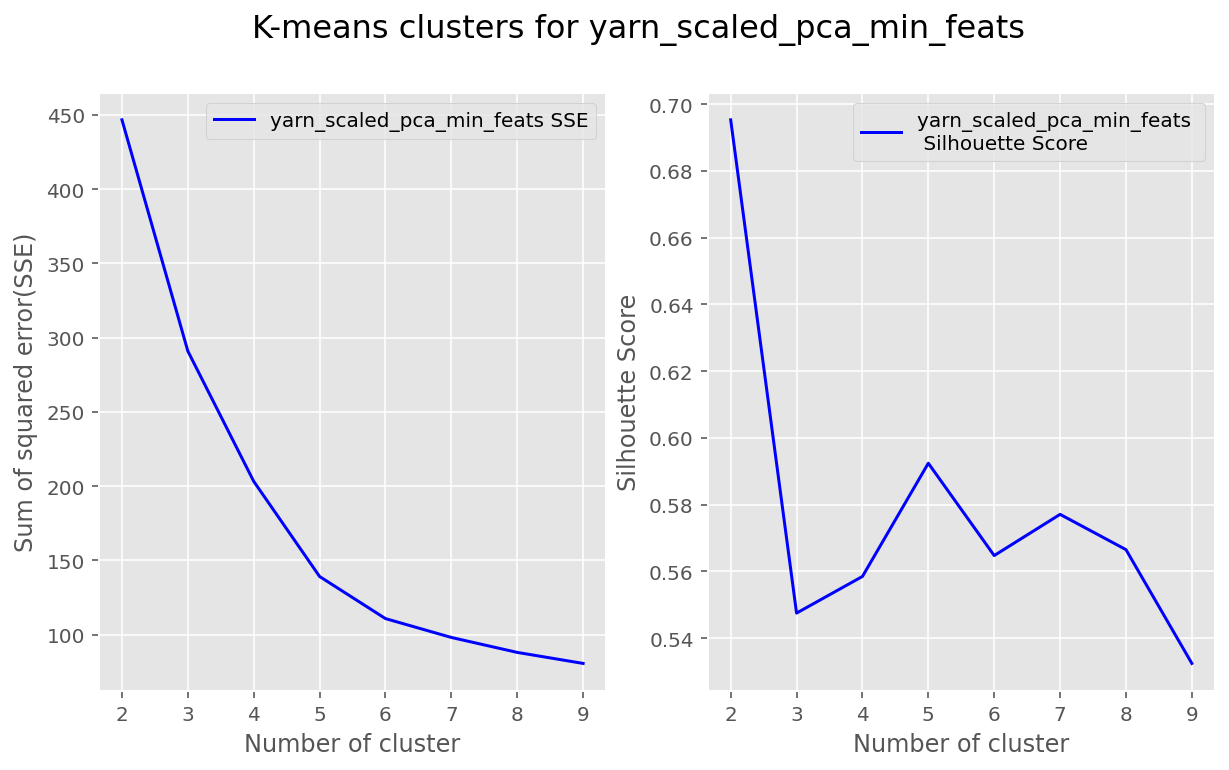

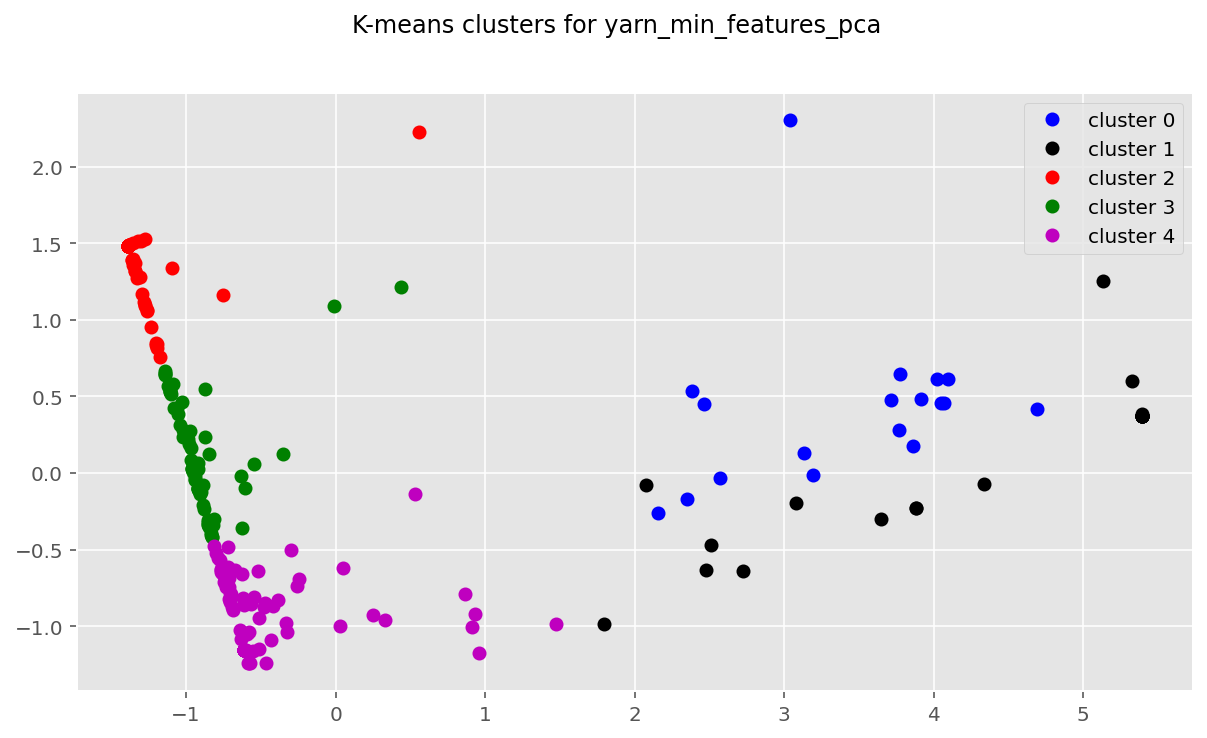

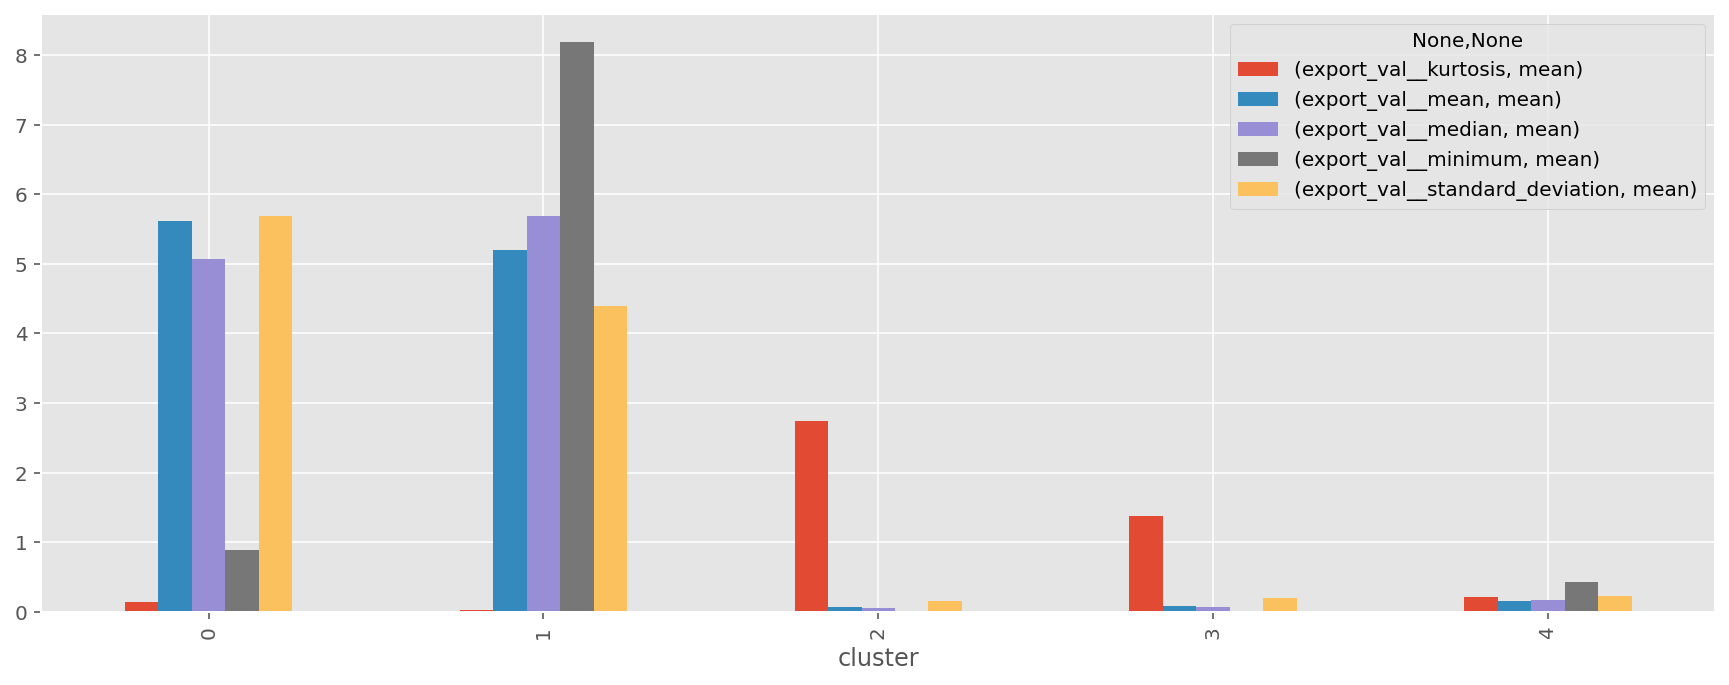

In [74]:
# Standardize the data to have a mean of ~0 and a variance of 1

# TODO: PCA plots and evaluation
# Create a PCA instance: pca
# def calculate_pca():
  # return pca_components_df

X_std = StandardScaler().fit_transform(min_feats_yarn)
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_std)

# def plot_pca_eveluation():
# Plot the explained variances
features = range(pca.n_components_)

fig = plt.figure(figsize=(10,5.5))
fig.suptitle("Clusters for yarn min_features", fontsize=16)
fig.add_subplot(131)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
fig.add_subplot(132)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.4, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


plot_elbow_silhoutte_k_evaluation("yarn_scaled_pca_min_feats",np.asarray(PCA_components),10)  
clusters_yarn_min_feats = plot_kmeans_clusters(np.asarray(PCA_components),5,"yarn_min_features_pca")

details = [(name,cluster) for name, cluster in zip(min_feats_yarn.index,clusters_yarn_min_feats)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = min_feats_yarn.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)
groups.plot(figsize=(15,5.5),kind='bar')
plt.savefig('clusters_yarn_min_features_pca_kmeans')

## DBSCAN - hyperparameter tuning

  0%|          | 1/245 [00:00<00:26,  9.18it/s]

[dbscan] >Normalize data (unit variance, zero-mean).
[dbscan] Gridsearch on epsilon to determine optimal clusters using silhouette scores.


100%|██████████| 245/245 [00:26<00:00,  9.13it/s]

[clusteval] >Fin.


<Figure size 720x396 with 0 Axes>

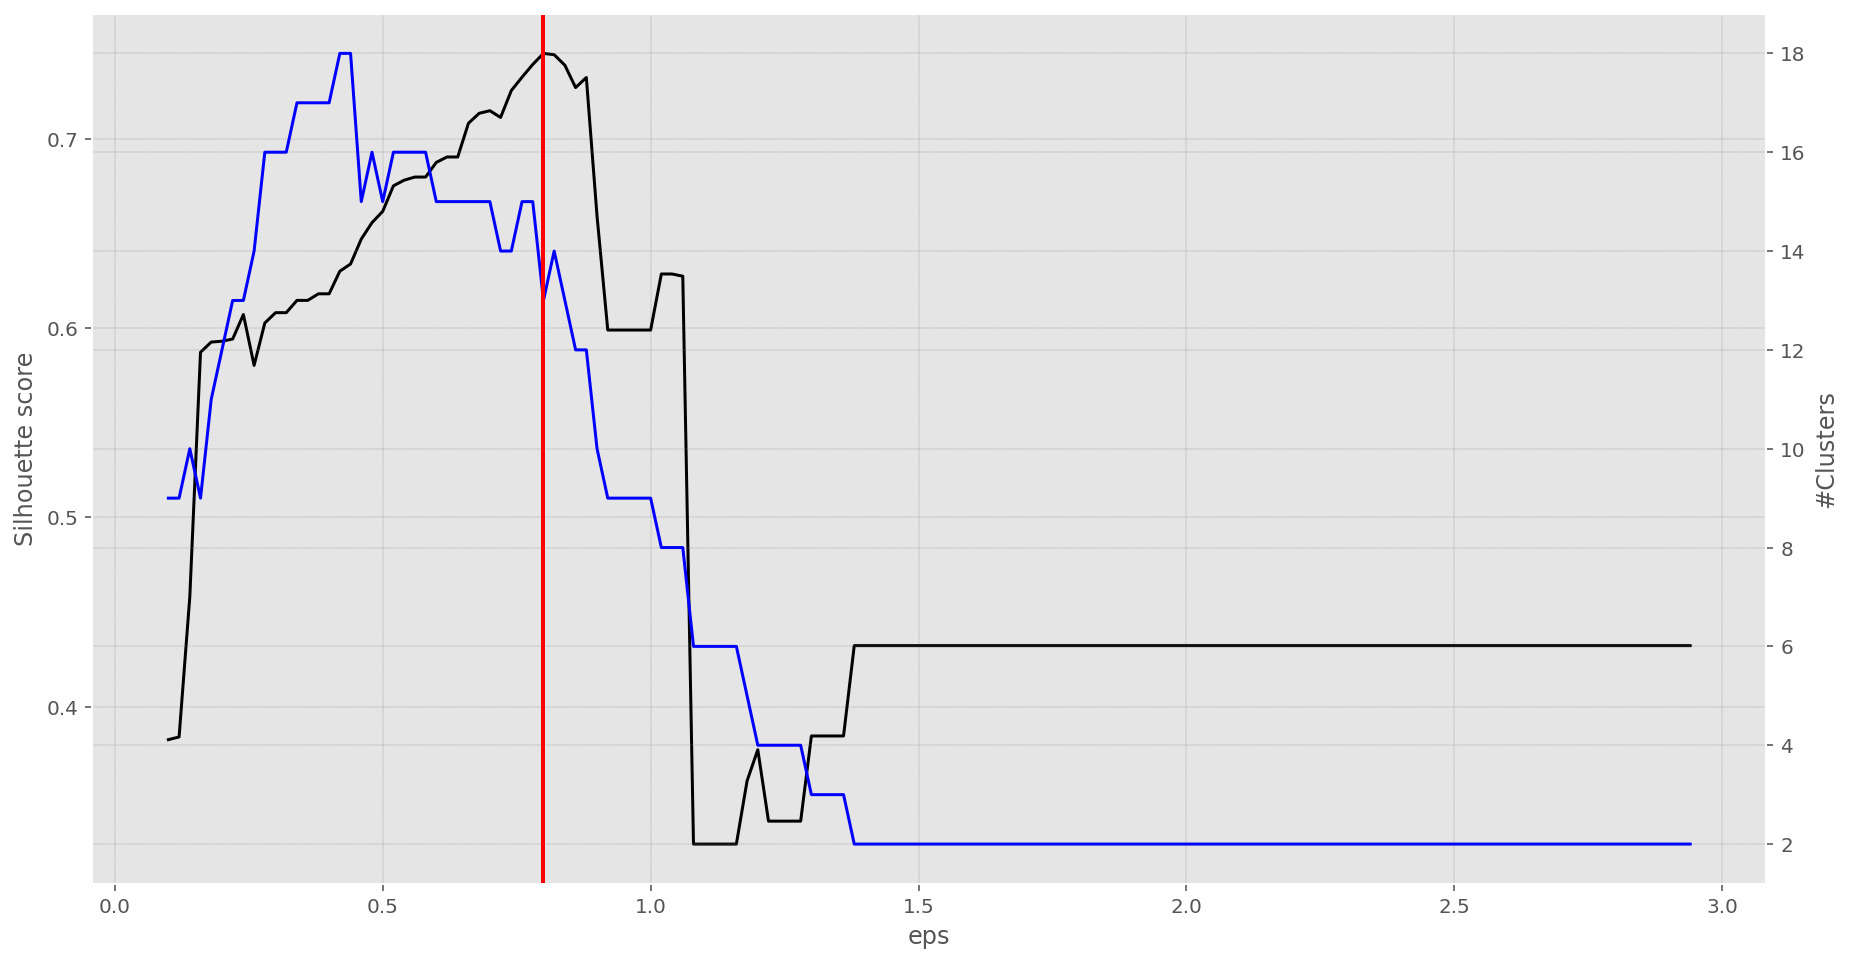

[silhouette] >Estimated number of n_clusters: 12, average silhouette_score=0.739


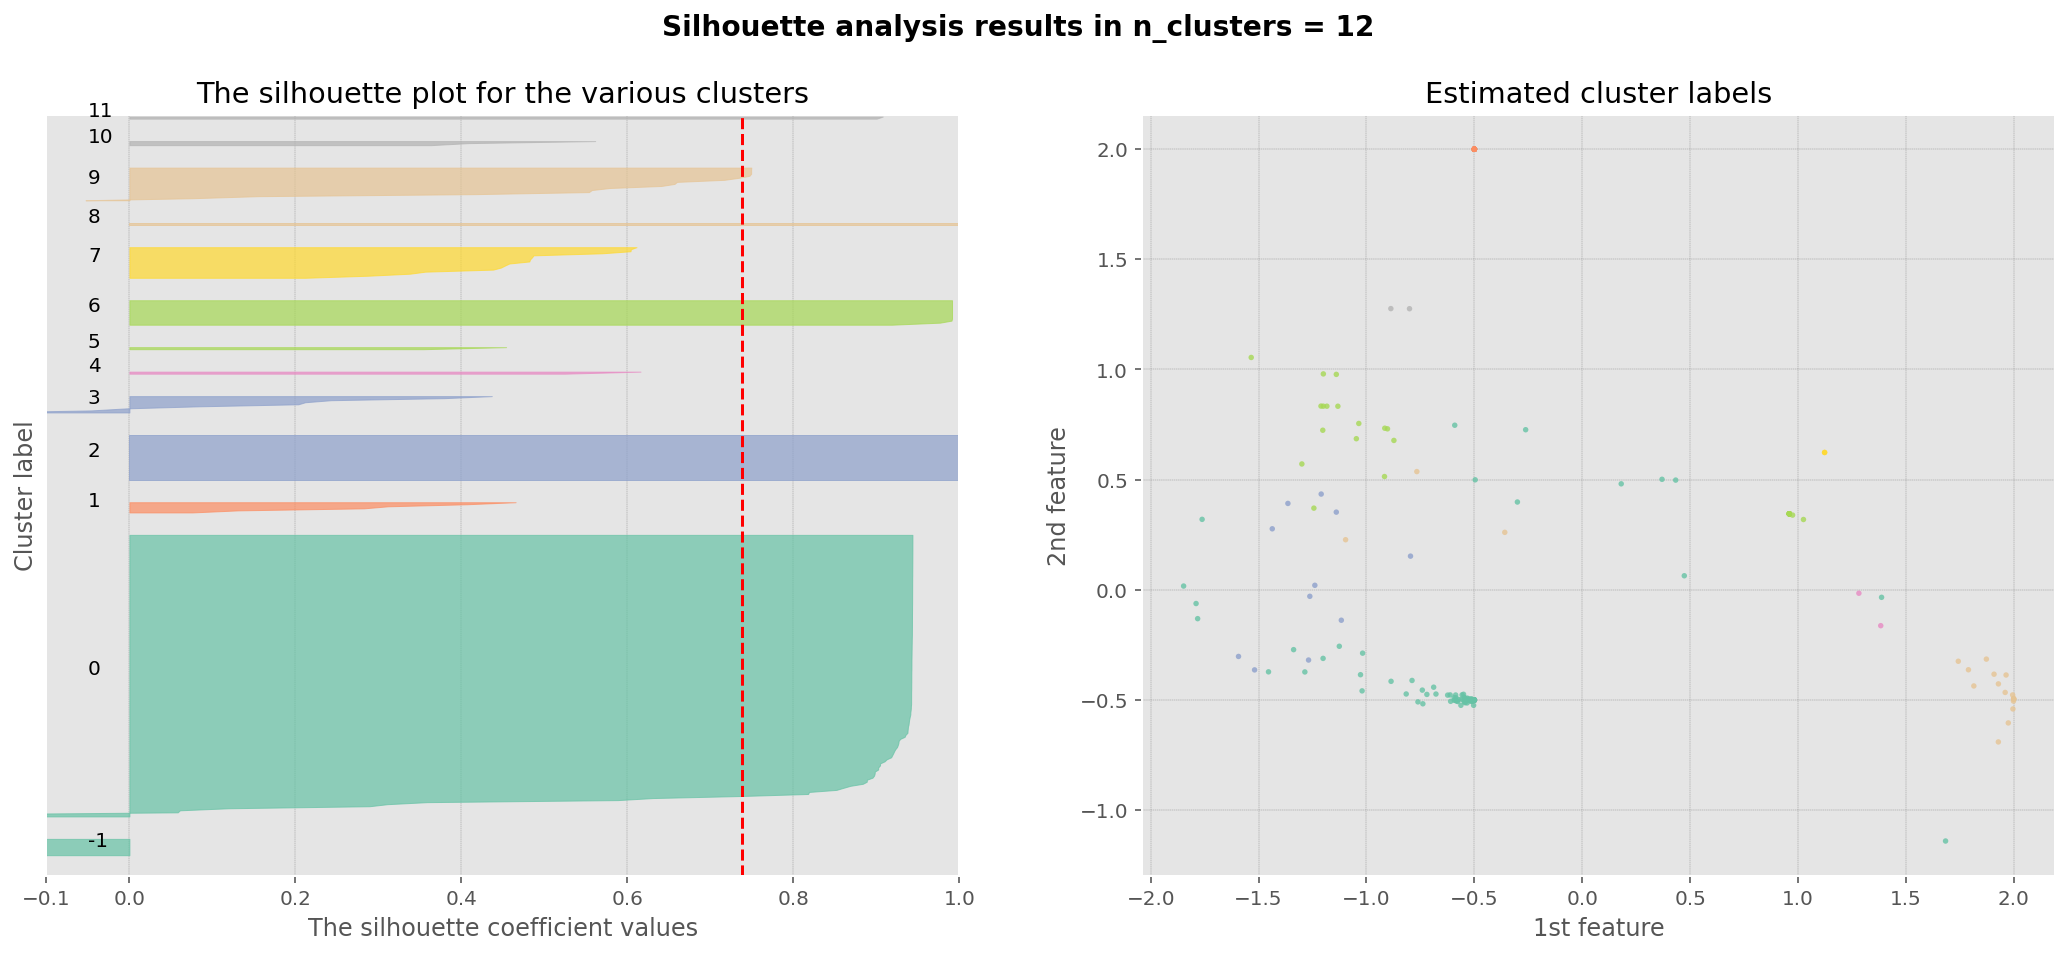

In [75]:
# https://stackoverflow.com/questions/34611038/grid-search-for-hyperparameter-evaluation-of-clustering-in-scikit-learn
!pip install -q clusteval
# Import library
from clusteval import clusteval
# Set parameters, as an example dbscan
ce = clusteval(method='dbscan')
# Fit to find optimal number of clusters using dbscan
results= ce.fit(X_scaled_transposed)
# Make plot of the cluster evaluation
plt.figure(figsize=(10,5.5))
ce.plot()
# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(X_scaled_transposed)
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

## DBSCAN

In [76]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan_results_yarn = dbscan.fit(X_scaled_transposed)
print(np.unique(dbscan.labels_))

[-1  0  1  2  3  4  5]


[-1  0  1  2  3  4  5]


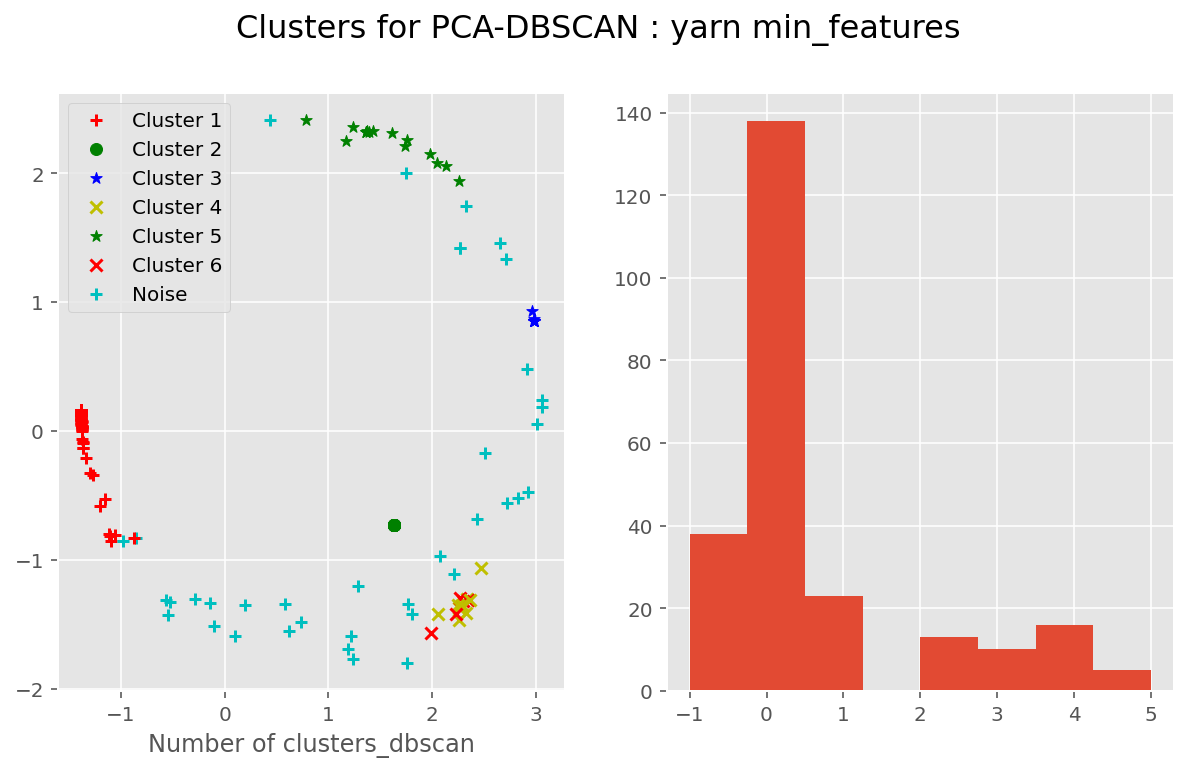

In [77]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan.fit(X_scaled_transposed)
fig = plt.figure(figsize=(10,5.5))
fig.suptitle("Clusters for PCA-DBSCAN : yarn min_features", fontsize=16)
print(np.unique(dbscan.labels_))
fig.add_subplot(121)
# fig.set_title('Clusters')
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled_transposed)
for i in range(0, pca_2d.shape[0]):
  if dbscan.labels_[i] == 0:
    c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
  elif dbscan.labels_[i] == 1:
    c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
  elif dbscan.labels_[i] == 2:
    c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
  elif dbscan.labels_[i] == 3:
    c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='x')
  elif dbscan.labels_[i] == 4:
    c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='*')
  elif dbscan.labels_[i] == 5:
    c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='x')
  elif dbscan.labels_[i] == -1:
    c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='+')
plt.xlabel("Number of clusters_dbscan")
plt.legend([c1, c2, c3,c4,c5,c6,c7], ['Cluster 1', 
                                'Cluster 2',
                                'Cluster 3',
                                'Cluster 4',
                                'Cluster 5',
                                'Cluster 6',
                                'Noise'])

# plt.title('DBSCAN finds 2 clusters and noise')
fig.add_subplot(122)
# plt.set_title=("Cluster instances/frequency")
plt.hist(dbscan.labels_,bins=8)
plt.savefig(f"{PATH}/images/yarn_min_feats_pca_dbscan")
plt.show()